<a href="https://colab.research.google.com/github/Doclikam/Causal-inference-for-Treatment-Effects-in-Head-Neck-Radiotherapy./blob/main/Notebooks/Causal_Modelling_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RADCURE - CHEMOTHERAPY/RADIOTHERAPY CANCER RESPONSE**

# **Assumptions of Cuasal Machine Learning**

**Positivity(overlap):**  Every patient must have a non-zero probability of receiving either treatment option, given their baseline confounders.

**Consistency (SUTVA):**
Each patient’s outcome corresponds to the treatment they received, with no interference across patients.

**Conditional Exchangeability:**
Given baseline confounders 𝑋 treatment assignment 𝐴 is independent of potential outcomes:

                                        Y(a)⊥A∣X
**Ignorability**

Ignorability assumes that after adjusting for all measured confounders,
treatment assignment is ‘as good as random.’
This assumption allows us to estimate causal effects from observational data

In [98]:
pip install joblib --quiet


In [99]:
pip install econml --quiet

In [100]:
pip install lifelines --quiet

In [101]:
pip install xgboost shap --quiet

In [102]:
#main libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime



from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_curve, auc,roc_auc_score, brier_score_loss, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, GroupKFold

from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

from econml.dml import CausalForestDML
from scipy.special import expit
from scipy import stats as st


from tqdm.auto import trange, tqdm


import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

import joblib
import os
os.makedirs("outputs2", exist_ok=True)
import itertools

# Display all columns
pd.set_option('display.max_columns', None)


In [103]:
rad_analysis = pd.read_csv("/content/rad_data_analysis (6).csv")#load the excel file
rad_analysis.head(5)#visulize the first 5 patients

patient_id  treatment  time_os_days  event_os  time_pfs_days  event_pfs  \
0  RADCURE-0005          0         446.0         1          446.0          1   
1  RADCURE-0006          0         527.0         1          527.0          1   
2  RADCURE-0007          0         756.0         0          756.0          0   
3  RADCURE-0009          0        2059.0         0         2059.0          0   
4  RADCURE-0010          0        3444.0         0         3444.0          0   

   time_pfs_days.1  event_pfs.1   age     sex  ecog_ps  ecog_ps_missing  \
0            446.0            1  62.6  Female      0.0                0   
1            527.0            1  87.3    Male      2.0                0   
2            756.0            0  49.9    Male      1.0                0   
3           2059.0            0  72.3    Male      1.0                0   
4           3444.0            0  59.7  Female      0.0                0   

  smoking_status_clean  smoking_py_clean  smoking_py_missing  \
0            Ex-Smoker              50.0                   0   
1            Ex-Smoker              25.0                   0   
2            Ex-Smoker              15.0                   0   
3            Ex-Smoker              30.0                   0   
4           Non-Smoker               0.0                   0   

   smoking_mismatch_flag primary_site_group    subsite_clean  subsite_missing  \
0                      0         Oropharynx        Post Wall                0   
1                      0             Larynx          Glottis                0   
2                      0         Oropharynx           Tonsil                0   
3                      0          Other_HNC              NaN                0   
4                      0         Oropharynx  Tonsillar Fossa                0   

     t    n   m stage  t_missing  n_missing  m_missing  stage_missing  \
0  T4b  N2c  M0   IVB          0          0          0              0   
1  T1b   N0  M0     I          0          0          0              0   
2   T3  N2b  M0   IVA          0          0          0              0   
3   T0  N2c  M0   IVA          0          0          0              0   
4  T4b   N0  M0   IVB          0          0          0              0   

      hpv_clean  hpv_missing  hpv_specific_tumors pathology_group  is_non_tnm  \
0  HPV_Negative            0                    1             SCC           0   
1           NaN            0                    0             SCC           0   
2  HPV_Positive            0                    1             SCC           0   
3           NaN            0                    0             SCC           0   
4  HPV_Negative            0                    1             SCC           0   

   tnm_structural_missing  followup_days  dose  fx  length_fu  d_per_fx  \
0                       0          446.0  60.0  25   1.317808      2.40   
1                       0          527.0  51.0  20   1.520548      2.55   
2                       0          756.0  64.0  40   2.126027      1.60   
3                       0         2059.0  70.0  35   5.791781      2.00   
4                       0         3444.0  64.0  40   9.512329      1.60   

      BED       EQD2  BED_eff  
0  74.400  62.000000   74.400  
1  64.005  53.337500   64.005  
2  74.240  61.866667   74.240  
3  84.000  70.000000   84.000  
4  74.240  61.866667   74.240

In [104]:
rad_analysis.columns

Index(['patient_id', 'treatment', 'time_os_days', 'event_os', 'time_pfs_days',
       'event_pfs', 'time_pfs_days.1', 'event_pfs.1', 'age', 'sex', 'ecog_ps',
       'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean',
       'smoking_py_missing', 'smoking_mismatch_flag', 'primary_site_group',
       'subsite_clean', 'subsite_missing', 't', 'n', 'm', 'stage', 't_missing',
       'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing',
       'hpv_specific_tumors', 'pathology_group', 'is_non_tnm',
       'tnm_structural_missing', 'followup_days', 'dose', 'fx', 'length_fu',
       'd_per_fx', 'BED', 'EQD2', 'BED_eff'],
      dtype='object')

In [105]:
# =============================== #
# GLOBAL CONFIGURATION CONSTANTS  #
# =============================== #

ID_COL = 'patient_id'
TIME_COL = 'time_os_days'
EVENT_COL = 'event_os'
TREAT_COL = 'treatment'

INTERVAL_DAYS = 30
MIN_COUNT_FOR_KEEP = 40

PERIOD_BINS = [0,3,6,12,24,36,60, np.inf]
PERIOD_LABELS = ['0-3','4-6','7-12','13-24','25-36','37-60','60+']

BASE_COVARIATES = [
    'age','sex','ecog_ps','smoking_status_clean','smoking_py_clean',
    'primary_site_group','subsite_clean','stage','hpv_clean'
]

CAT_COLS = ['period_bin','sex','smoking_status_clean','primary_site_group','subsite_clean','stage','hpv_clean']
NUM_COLS = ['age','ecog_ps','smoking_py_clean','time_since_rt_days']


OUTDIR="outputs2"



# Propensity Scores

**Propensity score (PS) model:**

In  observational studies thre are sytemic diffrences between the treated and untreated groups which may result in bias, propensity scores can help to account for these differnces addressing the bias.

By creating more comparable controlk group, the score provides a method for estimating the causal effects of the treatment (Radiotehrapy vs radiochemotherapy) on the ouitcome (event occurence, time to event)

However, one limitation of propesnity scoring is that it can only balance the groups on the features that are measured and included in the model, hence canmnot account for unmeasured confounders.

PS(x)=P(Treatment=1∣X=x)  


for each patient, what’s the probability they receive ChemoRT given their observed baseline characteristics X

Here:

X is a matrix of confounders (age, sex, ECOG, smoking, TNM, HPV, etc.) that influence treatment assignment.

y is a binary vector: 1 if patient received ChemoRT, 0 if RT alone.

In [106]:
#list of covariated fot propensity scoring
ps_covariates = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group',
    't', 'n', 'm','pathology_group',
    't_missing', 'n_missing', 'm_missing','stage_missing','is_non_tnm',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors'
]

#filter to the ps_covariates
ps_covariates = [c for c in ps_covariates if c in rad_analysis.columns]
print(f'The covariates: {ps_covariates}')

The covariates: ['age', 'sex', 'ecog_ps', 'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing', 'primary_site_group', 't', 'n', 'm', 'pathology_group', 't_missing', 'n_missing', 'm_missing', 'stage_missing', 'is_non_tnm', 'hpv_clean', 'hpv_missing', 'hpv_specific_tumors']


**Model 1: Simple Logistic Regression**

In [107]:
#categorical columns - Preprocess covariates for PS model (one-hot categorical, median fill for numerics)2. Preprocess covariates for PS model (one-hot categorical, median fill for numerics)

cat_cols = ['sex','smoking_status_clean','primary_site_group','t','n','m','pathology_group','hpv_clean']
cat_cols = [c for c in cat_cols if c in rad_analysis.columns]

#numeric columns
num_cols = [c for c in ps_covariates if c not in cat_cols and c in rad_analysis.columns]

#split patient into train and test based on their unique ids
id_col = 'patient_id'
unique_ids = rad_analysis[id_col].unique()

#stratify patient by the treatment
id_treat = (rad_analysis[[id_col,'treatment']]
            .drop_duplicates(subset = id_col)
            .set_index(id_col)['treatment'])

strat_y = id_treat.loc[unique_ids].values.astype(int)

#train_test split
train_ids, test_ids = train_test_split(unique_ids,
                                        train_size = 0.75,
                                        random_state = 42,
                                        stratify = strat_y
                                        )


train_df = rad_analysis[rad_analysis[id_col].isin(train_ids)].copy()
test_df = rad_analysis[rad_analysis[id_col].isin(test_ids)].copy()
print("Train patients:", train_df[id_col].nunique(),
      "Test patients:", test_df[id_col].nunique())

#impute num cols with mediuan for train data
train_medians = train_df[num_cols].median()
train_df[num_cols] = train_df[num_cols].fillna(train_medians)
test_df[num_cols] = test_df[num_cols].fillna(train_medians)


#one hot encode categorical columns

one_hot_encoder= OneHotEncoder(drop = 'first',
                   sparse_output = False,
                   handle_unknown = 'ignore')

preprocessor = ColumnTransformer(
                  transformers = [('cat', one_hot_encoder, cat_cols)],
                  remainder = 'passthrough'
                                )
X_train = preprocessor.fit_transform(train_df[num_cols + cat_cols])
X_test = preprocessor.transform(test_df[cat_cols + num_cols])

#feature name
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(ohe_cols)+ num_cols

y_train = train_df['treatment'].astype(int).values
y_test = test_df['treatment'].astype(int).values

#propensity scores
#Fit logistic regression (L2 small penalty for stability)
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

#perdict propensity scores for the train and test
train_df['ps_logit_simple']= logreg.predict_proba(X_train)[:,1]
test_df['ps_logit_simple'] = logreg.predict_proba(X_test)[:,1]

# recombine ps
rad_ps = pd.concat([train_df, test_df], axis=0, ignore_index= True)

#Diagnostics
print("Mean PS treatment group (entire dataset, model first on train dataset )")
print(rad_ps.groupby('treatment')['ps_logit_simple'].mean())

ps0 = rad_ps.loc[rad_ps['treatment'] == 0, 'ps_logit_simple']
ps1 = rad_ps.loc[rad_ps['treatment'] == 1, 'ps_logit_simple']

#ps scores rt alone
print("PS Range for RT alone : ",
      ps0.min(),
      ps0.max())

#ps scores for chemo -RT
print("PS range for Chomo-RT: ",
      ps1.min(),
      ps1.max())

#get patients with propensity scores that are not too close to 0 or 1
for p in [0,1]:
  mask_g = rad_ps['treatment']==p
  in_overlap = (rad_ps['ps_logit_simple']>0.05) & (rad_ps['ps_logit_simple']<0.95) & mask_g
  #proportin of overlap
  prop = in_overlap.sum()/mask_g.sum()
  print(f"Proprtion of group {p} with 0.05 >PS<0.95: {prop:.3f}  ")



#save fitted preprocessor and logistic regression model
joblib.dump(preprocessor, "outputs2/ps_preprocessor.joblib")
joblib.dump(logreg, "outputs2/ps_logistic_model.joblib")

# Save to CSV for reference
pd.Series(ohe_cols, name='feature_name').to_csv("outputs2/ps_model_features.csv", index=False)

Train patients: 2453 Test patients: 818
Mean PS treatment group (entire dataset, model first on train dataset )
treatment
0    0.228798
1    0.695009
Name: ps_logit_simple, dtype: float64
PS Range for RT alone :  0.0004044277771599942 0.9961422655473345
PS range for Chomo-RT:  0.050688341056623044 0.9996304420821351
Proprtion of group 0 with 0.05 >PS<0.95: 0.658  
Proprtion of group 1 with 0.05 >PS<0.95: 0.875  


| Treatment group  | Mean predicted PS | Therefore                                                                                          |
| ---------------- | ----------------- | ------------------------------------------------------------------------------------------------------ |
| **0 = RT alone** | **0.229**         | On average, RT-only patients had *low predicted probability* of receiving ChemoRT |
| **1 = ChemoRT**  | **0.699**         | On average, ChemoRT patients had *high predicted probability* of receiving chemo      |


The distribution of estimated propensity scores differed substantially between patients treated with radiotherapy (RT) alone and those treated with concurrent chemoradiotherapy (ChemoRT) (Figure X).
Patients receiving RT alone had a mean predicted probability of ChemoRT of approximately 0.23, whereas patients treated with ChemoRT had a mean propensity of 0.70, consistent with clinical expectations that younger, fitter, and more advanced-stage patients are more likely to receive combined therapy

Logistic Regression, GBM, Super learner

In [108]:

# Of the numeric columns, use splines for these:
spline_cols = [c for c in ['age', 'smoking_py_clean'] if c in num_cols]
base_num_cols = [c for c in num_cols if c not in spline_cols]

print("Spline cols:", spline_cols)
print("Other numeric cols:", base_num_cols)

#pply one hot encoding to categorical columns and spline transformation to the categoiries'age, smoking'
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

spline_transformer = SplineTransformer(
    degree=3,        # cubic splines
    n_knots=4,       # 4 internal knots
    include_bias=False
)

ps_preprocessor_spline = ColumnTransformer(
    transformers=[
        ("cat", one_hot_encoder, cat_cols),
        ("spline", spline_transformer, spline_cols),
        ("num", "passthrough", base_num_cols)
    ],
    remainder='drop'
)


# Pipeline: preprocessing + logistic regression
logit_pipe = Pipeline(steps=[
    ("preprocess", ps_preprocessor_spline),
    ("model", LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=5000
    ))
])


param_grid_logit = {
    "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],
    "model__class_weight": [None, "balanced"]
}

logit_grid = GridSearchCV(
    estimator=logit_pipe,
    param_grid=param_grid_logit,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    refit=True
)

# X = raw features, y = treatment
X_train_raw = train_df[cat_cols + num_cols]
X_test_raw  = test_df[cat_cols + num_cols]

logit_grid.fit(X_train_raw, y_train)

print("Best logistic params:", logit_grid.best_params_)
print(f"Best CV AUC (logit + splines): {logit_grid.best_score_:.3f}")

# Evaluate on held-out test set
best_logit = logit_grid.best_estimator_
y_test_ps_logit = best_logit.predict_proba(X_test_raw)[:, 1]
test_auc_logit = roc_auc_score(y_test, y_test_ps_logit)
print(f"Test AUC (logit + splines, tuned): {test_auc_logit:.3f}")

# Propensity scores from tuned logistic + splines
train_df['ps_logit_spline_tuned'] = best_logit.predict_proba(X_train_raw)[:, 1]
test_df['ps_logit_spline_tuned']  = best_logit.predict_proba(X_test_raw)[:, 1]


gbm_pipe = Pipeline(steps=[
    ("preprocess", ps_preprocessor_spline),
    ("model", GradientBoostingClassifier(random_state=42))
])

param_grid_gbm = {
    "model__n_estimators": [200, 400, 800],
    "model__learning_rate": [0.05, 0.01],
    "model__max_depth": [2, 3],
    "model__subsample": [0.8, 1.0]
}

gbm_grid = GridSearchCV(
    estimator=gbm_pipe,
    param_grid=param_grid_gbm,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    refit=True
)

gbm_grid.fit(X_train_raw, y_train)

print("Best GBM params:", gbm_grid.best_params_)
print(f"Best CV AUC (GBM): {gbm_grid.best_score_:.3f}")

#best GBM model
best_gbm = gbm_grid.best_estimator_
train_df['ps_gbm_tuned'] = best_gbm.predict_proba(X_train_raw)[:, 1]
test_df['ps_gbm_tuned']  = best_gbm.predict_proba(X_test_raw)[:, 1]

# Evaluate on held-out test set
y_test_ps_gbm = best_gbm.predict_proba(X_test_raw)[:, 1]
test_auc_gbm = roc_auc_score(y_test, y_test_ps_gbm)
print(f"Test AUC (logit + splines, tuned): {test_auc_gbm:.3f}")


#create a super learner(GBM+tuned logistic)
super_learner = {
    "logit_model": best_logit,
    "gbm_model": best_gbm,
    "weights": [0.5, 0.5]   # equal weighting as in your code
}
train_df['ps_super'] = (train_df['ps_logit_spline_tuned'] + train_df['ps_gbm_tuned']) / 2.0
test_df['ps_super']  = (test_df['ps_logit_spline_tuned'] + test_df['ps_gbm_tuned']) / 2.0

#elastic net pipeline
enet_pipe = Pipeline(steps=[
    ("preprocess", ps_preprocessor_spline),
    ("model", LogisticRegression(
        penalty='elasticnet',
        solver='saga',     # must use saga for elastic net
        max_iter=5000
    ))
])
param_grid_enet = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.1, 0.5, 0.9]
}

enet_grid = GridSearchCV(
    estimator=enet_pipe,
    param_grid=param_grid_enet,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    refit=True
)

enet_grid.fit(X_train_raw, y_train)

print("Best Elastic Net params:", enet_grid.best_params_)
print(f"Best CV AUC (Elastic Net): {enet_grid.best_score_:.3f}")

best_enet = enet_grid.best_estimator_

# Test-set performance
y_test_ps_enet = best_enet.predict_proba(X_test_raw)[:, 1]
test_auc_enet = roc_auc_score(y_test, y_test_ps_enet)
print(f"Test AUC (Elastic Net): {test_auc_enet:.3f}")

train_df['ps_enet'] = best_enet.predict_proba(X_train_raw)[:, 1]
test_df['ps_enet']  = best_enet.predict_proba(X_test_raw)[:, 1]

#combine into 1 df
all_df = pd.concat([train_df, test_df], ignore_index=True)

def summarize_ps(df, ps_col):
    return (df.groupby('treatment')[ps_col]
              .agg(['mean', 'std', 'min', 'max']))

print("\nSummary of propensity scores by model:\n")

print("Logit + splines (tuned):")
print(summarize_ps(all_df, 'ps_logit_spline_tuned'))
print("\nGBM:")
print(summarize_ps(all_df, 'ps_gbm_tuned'))
print("\nSuper Learner:")
print(summarize_ps(all_df, 'ps_super'))
print("\Elastic Net:")
print(summarize_ps(all_df, 'ps_enet'))




joblib.dump(preprocessor, "outputs2/preprocessor.joblib")
joblib.dump(best_logit, "outputs2/ps_logit_spline_tuned.joblib")
print("Saved tuned logistic PS model → outputs2/ps_logit_spline_tuned.joblib")

joblib.dump(best_gbm, "outputs2/ps_gbm_tuned.joblib")
print("Saved tuned GBM PS model → outputs2/ps_gbm_tuned.joblib")
joblib.dump(best_enet, "outputs2/ps_enet.joblib")
print("Saved tuned GBM PS model → outputs2/ps_enet.joblib")
joblib.dump(super_learner, "outputs2/ps_super.joblib")
print("Saved Super Learner model → outputs/2/ps_super_learner.joblib")



Spline cols: ['age', 'smoking_py_clean']
Other numeric cols: ['ecog_ps', 'ecog_ps_missing', 'smoking_py_missing', 't_missing', 'n_missing', 'm_missing', 'stage_missing', 'is_non_tnm', 'hpv_missing', 'hpv_specific_tumors']
Best logistic params: {'model__C': 10.0, 'model__class_weight': 'balanced'}
Best CV AUC (logit + splines): 0.901
Test AUC (logit + splines, tuned): 0.907
Best GBM params: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 800, 'model__subsample': 1.0}
Best CV AUC (GBM): 0.899
Test AUC (logit + splines, tuned): 0.907
Best Elastic Net params: {'model__C': 10.0, 'model__l1_ratio': 0.5}
Best CV AUC (Elastic Net): 0.901
Test AUC (Elastic Net): 0.907

Summary of propensity scores by model:

Logit + splines (tuned):
               mean       std       min       max
treatment                                        
0          0.238318  0.283624  0.000005  0.995284
1          0.759128  0.206450  0.025342  0.999919

GBM:
               mean       std  

In [109]:


def make_stabilized_weights(
    train_df,
    test_df,
    ps_col,
    treat_col='treatment',
    weight_name=None,
    q_low=0.01,
    q_high=0.99,
    verbose=True
):
    """
    Compute stabilized IPTW weights for a given PS column,
    truncate them based on train quantiles, and apply same
    truncation to test data.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training data containing treatment and ps_col.
    test_df : pd.DataFrame
        Test data containing treatment and ps_col.
    ps_col : str
        Column name of the propensity score (P(T=1|X)).
    treat_col : str, default='treatment'
        Column name of the treatment indicator (0/1).
    weight_name : str or None
        Base name for the weight columns. If None, use ps_col
        prefixed with 'sw_' (e.g. ps_logit_simple -> sw_ps_logit_simple).
    q_low, q_high : float
        Quantiles for truncation bounds, e.g. 0.01 and 0.99.
    verbose : bool
        If True, print summary stats and truncation bounds.

    Returns
    -------
    (train_df, test_df, bounds) where
    bounds = (low, high)
    """

    if weight_name is None:
        weight_name = f"sw_{ps_col}"

    trunc_name = f"{weight_name}_trunc"

    #Marginal treatment probability from train only
    t_m = train_df[treat_col].mean()

    #Compute stabilized weights in both train and test
    for df in (train_df, test_df):
        ps = df[ps_col]
        treat = df[treat_col]
        df[weight_name] = np.where(
            treat == 1,
            t_m / ps,            # treated: P(T=1) / PS
            (1 - t_m) / (1 - ps) # control: P(T=0) / (1 - PS)
        )

    #Compute truncation bounds *from training weights only*
    low, high = train_df[weight_name].quantile([q_low, q_high])

    #truncation to both train and test
    train_df[trunc_name] = train_df[weight_name].clip(low, high)
    test_df[trunc_name]  = test_df[weight_name].clip(low, high)

    #print diagnostics
    if verbose:
        w = train_df[weight_name]
        print(f"\nWeights for {ps_col} -> {weight_name}")
        print(f" Train stabilized weights: mean={w.mean():.3f}, sd={w.std():.3f}, "
              f"min={w.min():.3f}, max={w.max():.3f}")
        print(f" Truncation bounds (from train only): [{low:.3f}, {high:.3f}]")
        w_tr = train_df[trunc_name]
        print(f" Train truncated weights:  mean={w_tr.mean():.3f}, sd={w_tr.std():.3f}, "
              f"min={w_tr.min():.3f}, max={w_tr.max():.3f}")

    return train_df, test_df, (low, high)




    #get truncated weights for

    #truncated weights simple logistic model
train_df, test_df, bounds_logit_simple = make_stabilized_weights(
    train_df=train_df,
    test_df=test_df,
    ps_col='ps_logit_simple',
    treat_col='treatment',
    weight_name='sw_logit_simple',
    q_low=0.01,
    q_high=0.99,
    verbose=True
)
#truncated weights logistic+splines
train_df, test_df, bounds_logit_tuned = make_stabilized_weights(
    train_df=train_df,
    test_df=test_df,
    ps_col='ps_logit_spline_tuned',
    treat_col='treatment',
    weight_name='sw_logit_spline_tuned',
    q_low=0.01,
    q_high=0.99
)

#truncated weights gbm
train_df, test_df, bounds_gbm = make_stabilized_weights(
    train_df=train_df,
    test_df=test_df,
    ps_col='ps_gbm_tuned',
    treat_col='treatment',
    weight_name='sw_gbm',
    q_low=0.01,
    q_high=0.99
)
#truncated weights super
train_df, test_df, bounds_super = make_stabilized_weights(
    train_df=train_df,
    test_df=test_df,
    ps_col='ps_super',
    treat_col='treatment',
    weight_name='sw_super',
    q_low=0.01,
    q_high=0.99
)
#truncated weights Elastic Net
#truncated weights gbm
train_df, test_df, bounds_enet = make_stabilized_weights(
    train_df=train_df,
    test_df=test_df,
    ps_col='ps_enet',
    treat_col='treatment',
    weight_name='sw_enet',
    q_low=0.01,
    q_high=0.99
)



Weights for ps_logit_simple -> sw_logit_simple
 Train stabilized weights: mean=0.886, sd=0.837, min=0.432, max=14.817
 Truncation bounds (from train only): [0.436, 4.656]
 Train truncated weights:  mean=0.864, sd=0.669, min=0.436, max=4.656

Weights for ps_logit_spline_tuned -> sw_logit_spline_tuned
 Train stabilized weights: mean=0.913, sd=1.020, min=0.432, max=12.702
 Truncation bounds (from train only): [0.434, 5.273]
 Train truncated weights:  mean=0.884, sd=0.805, min=0.434, max=5.273

Weights for ps_gbm_tuned -> sw_gbm
 Train stabilized weights: mean=0.786, sd=0.564, min=0.433, max=8.353
 Truncation bounds (from train only): [0.437, 3.135]
 Train truncated weights:  mean=0.773, sd=0.466, min=0.437, max=3.135

Weights for ps_super -> sw_super
 Train stabilized weights: mean=0.821, sd=0.672, min=0.433, max=8.667
 Truncation bounds (from train only): [0.436, 3.789]
 Train truncated weights:  mean=0.806, sd=0.558, min=0.436, max=3.789

Weights for ps_enet -> sw_enet
 Train stabilize

In [110]:
# create a function for computing smd causal_utils.py

def compute_smd(x_treat, x_control, w_treat=None, w_control=None):
    """
    Standardized Mean Difference (SMD)
    Supports both unweighted and IPTW-weighted means.
    """
    if w_treat is None:
        m1 = np.mean(x_treat)
        m0 = np.mean(x_control)
        v1 = np.var(x_treat)
        v0 = np.var(x_control)
    else:
        m1 = np.average(x_treat, weights=w_treat)
        m0 = np.average(x_control, weights=w_control)
        v1 = np.average((x_treat - m1)**2, weights=w_treat)
        v0 = np.average((x_control - m0)**2, weights=w_control)

    pooled_sd = np.sqrt((v1 + v0) / 2)
    return (m1 - m0) / pooled_sd

def evaluate_balance(ps_col, weight_col, df, balance_covs):
    """
    Computes SMD before and after weighting for a given PS model.
    Returns a DataFrame of SMDs.
    """

    smd_before = []
    smd_after = []

    w_treat = df.loc[df['treatment']==1, weight_col]
    w_control = df.loc[df['treatment']==0, weight_col]

    for c in balance_covs:
        # categorical variable → convert to dummy columns
        if df[c].dtype == 'object':
            d = pd.get_dummies(df[c], drop_first=True)
            for col in d.columns:
                x = d[col]
                smd_before.append((f"{c}:{col}",
                                   compute_smd(x[df['treatment']==1],
                                               x[df['treatment']==0])))
                smd_after.append((f"{c}:{col}",
                                  compute_smd(x[df['treatment']==1],
                                              x[df['treatment']==0],
                                              w_treat=w_treat,
                                              w_control=w_control)))
        else:
            smd_before.append((c,
                               compute_smd(df.loc[df['treatment']==1, c],
                                           df.loc[df['treatment']==0, c])))

            smd_after.append((c,
                              compute_smd(df.loc[df['treatment']==1, c],
                                          df.loc[df['treatment']==0, c],
                                          w_treat=w_treat,
                                          w_control=w_control)))

    df_smd = pd.DataFrame({
        'covariate':[x[0] for x in smd_before],
        'SMD_before':[x[1] for x in smd_before],
        'SMD_after' :[x[1] for x in smd_after]
    })

    return df_smd

df_smd_simple_logit = evaluate_balance(
    ps_col='ps_logit_simple',
    weight_col='sw_logit_simple',
    df=train_df,
    balance_covs=ps_covariates
)
df_smd_tuned_logit = evaluate_balance(
    ps_col='ps_logit_spline_tuned',
    weight_col='sw_logit_spline_tuned',
    df=train_df,
    balance_covs=ps_covariates
)
df_smd_gbm = evaluate_balance(
    ps_col='ps_gbm_tuned',
    weight_col='sw_gbm',
    df=train_df,
    balance_covs=ps_covariates
)
df_smd_super = evaluate_balance(
    ps_col='ps_super',
    weight_col='sw_super_trunc',
    df=train_df,
    balance_covs=ps_covariates
)

df_smd_enet = evaluate_balance(
    ps_col='ps_enet',
    weight_col='sw_enet',
    df=train_df,
    balance_covs=ps_covariates
)



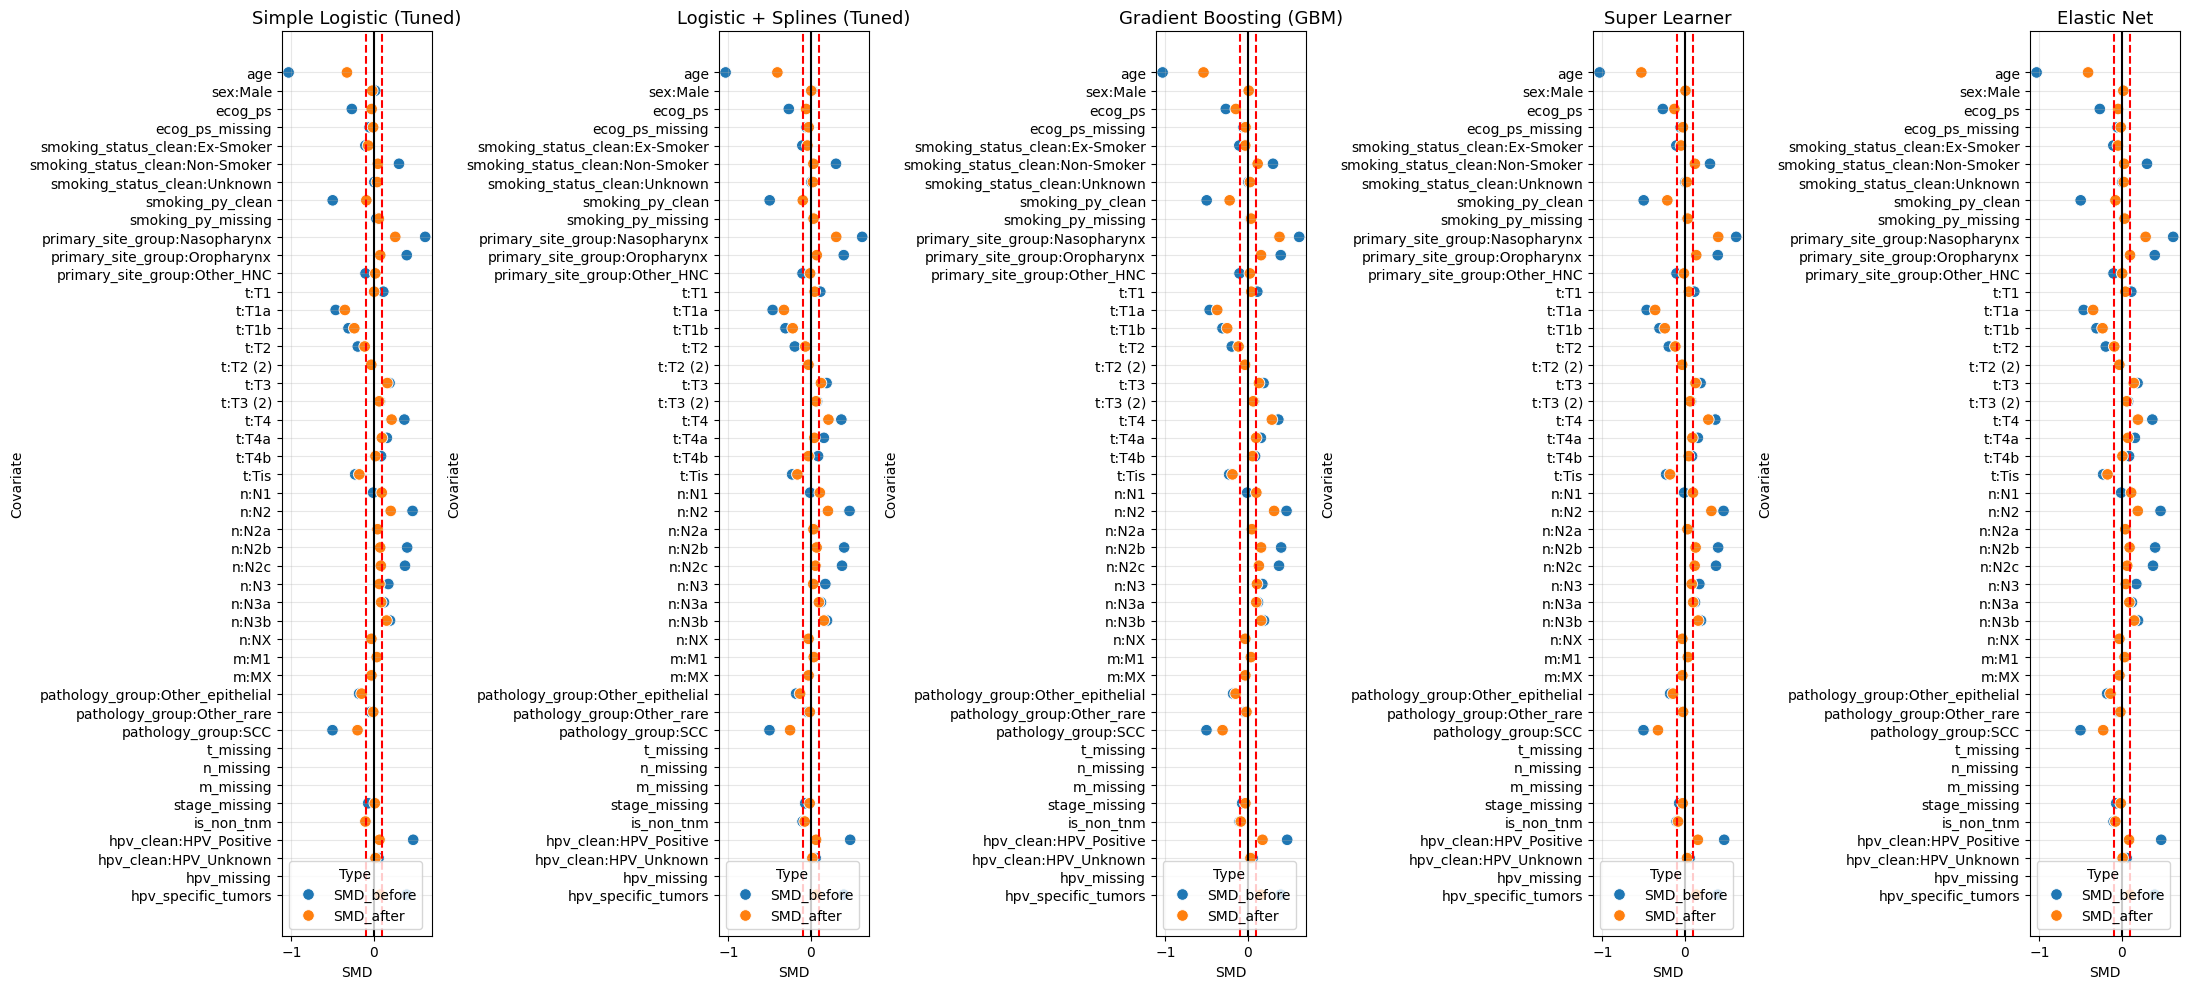

In [111]:
def side_by_side_loveplots(smd_dfs, titles, ncols=5, figsize=(18, 12), save_path=None):
    """
    Plot side-by-side Love plots for multiple SMD DataFrames.

    smd_dfs: list of DataFrames, each from evaluate_balance()
    titles: list of plot titles
    ncols: number of columns in subplot grid
    figsize: figure size
    """

    n = len(smd_dfs)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True)
    axes = axes.flatten()

    for i, (df_smd, ax) in enumerate(zip(smd_dfs, axes)):

        df_plot = df_smd.melt(
            id_vars='covariate',
            value_vars=['SMD_before','SMD_after'],
            var_name='Type',
            value_name='SMD'
        )

        sns.scatterplot(
            data=df_plot,
            x='SMD', y='covariate',
            hue='Type', s=70, ax=ax
        )

        ax.axvline(0, color='black')
        ax.axvline(0.1, color='red', linestyle='--')
        ax.axvline(-0.1, color='red', linestyle='--')

        ax.set_title(titles[i], fontsize=13)
        ax.set_xlabel("SMD")
        ax.set_ylabel("Covariate")
        ax.grid(alpha=0.3)

    # Remove unused axes if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    if save_path is not None:
        # Ensure folder exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
side_by_side_loveplots(
    smd_dfs=[df_smd_simple_logit,df_smd_tuned_logit, df_smd_gbm, df_smd_super,df_smd_enet],
    titles=[
        "Simple Logistic (Tuned)",
        "Logistic + Splines (Tuned)",
        "Gradient Boosting (GBM)",
        "Super Learner",
        "Elastic Net"
    ],
    ncols=5,
    figsize=(22, 10),
    save_path="outputs2/PS_diagnostics_panel.png"
)




SMD_after_tuned_logit     0.093189
SMD_after_enet            0.096102
SMD_after_simple_logit    0.096572
SMD_after_super           0.126932
SMD_after_gbm             0.132390
Name: mean_abs_SMD, dtype: float64


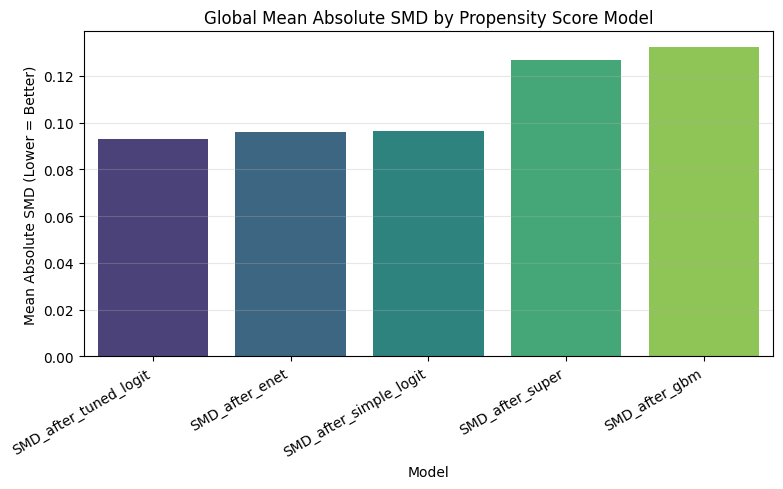

best_model
SMD_after_tuned_logit     20
SMD_after_simple_logit    10
SMD_after_enet            10
SMD_after_gbm              1
SMD_after_super            1
Name: wins, dtype: int64


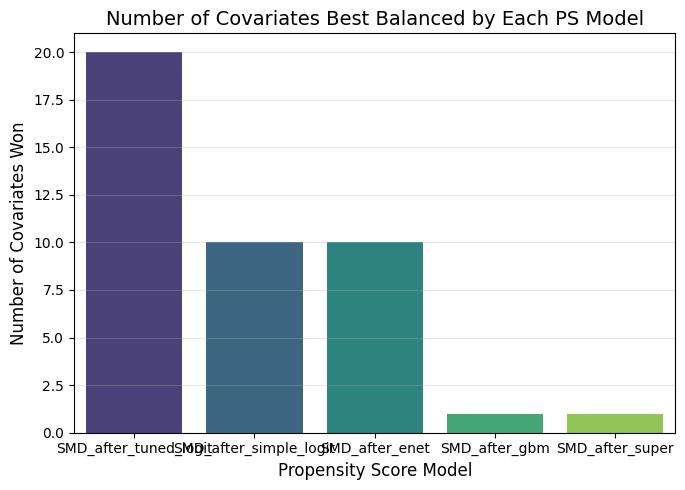

In [112]:
# use simple logit as the base
model_smd = df_smd_simple_logit[['covariate', 'SMD_before']].copy()

# Add SMD_after from each model with new names
model_smd = model_smd.merge(
    df_smd_simple_logit[['covariate', 'SMD_after']].rename(
        columns={'SMD_after': 'SMD_after_simple_logit'}
    ),
    on='covariate'
)

model_smd = model_smd.merge(
    df_smd_tuned_logit[['covariate', 'SMD_after']].rename(
        columns={'SMD_after': 'SMD_after_tuned_logit'}
    ),
    on='covariate'
)

model_smd = model_smd.merge(
    df_smd_gbm[['covariate', 'SMD_after']].rename(
        columns={'SMD_after': 'SMD_after_gbm'}
    ),
    on='covariate'
)

model_smd = model_smd.merge(
    df_smd_super[['covariate', 'SMD_after']].rename(
        columns={'SMD_after': 'SMD_after_super'}
    ),
    on='covariate'
)
model_smd = model_smd.merge(
    df_smd_enet[['covariate', 'SMD_after']].rename(
        columns={'SMD_after': 'SMD_after_enet'}
    ),
    on='covariate'
)
model_cols = [
    'SMD_after_simple_logit',
    'SMD_after_tuned_logit',
    'SMD_after_gbm',
    'SMD_after_super',
    'SMD_after_enet'
]

# Best model per covariate (smallest abs SMD)
model_smd['best_model'] = model_smd[model_cols].abs().idxmin(axis=1)
global_rank = (
    model_smd[model_cols].abs().mean()
    .sort_values()
    .rename("mean_abs_SMD")
)

print(global_rank)
#plot
plt.figure(figsize=(8,5))
sns.barplot(x=global_rank.index, y=global_rank.values, palette="viridis")

plt.title("Global Mean Absolute SMD by Propensity Score Model")
plt.ylabel("Mean Absolute SMD (Lower = Better)")
plt.xlabel("Model")
plt.xticks(rotation=30, ha='right')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("outputs2/Mean Absolute Difference.png", dpi=300)
plt.show()




# count wins per model
counts = model_smd['best_model'].value_counts()

# convert to normalized weights
w = counts / counts.sum()

all_df['ps_ensemble'] = (
    w.get('logit_simple', 0) * all_df['ps_logit_simple'] +
    w.get('logit_tuned',  0) * all_df['ps_logit_spline_tuned'] +
    w.get('gbm',          0) * all_df['ps_gbm_tuned'] +
    w.get('super',        0) * all_df['ps_super']+
    w.get('enet',        0) * all_df['ps_enet']
)


win_counts = model_smd['best_model'].value_counts().rename("wins")
print(win_counts)
plt.figure(figsize=(7,5))
sns.barplot(
    x=win_counts.index,
    y=win_counts.values,
    palette="viridis"
)

plt.title("Number of Covariates Best Balanced by Each PS Model", fontsize=14)
plt.xlabel("Propensity Score Model", fontsize=12)
plt.ylabel("Number of Covariates Won", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("outputs2/PS_model_win_counts.png", dpi=300)
plt.show()




Now that we have chose thge best model: ligistic tuned we will observe the overlap and distribution of the stabilzied treatments

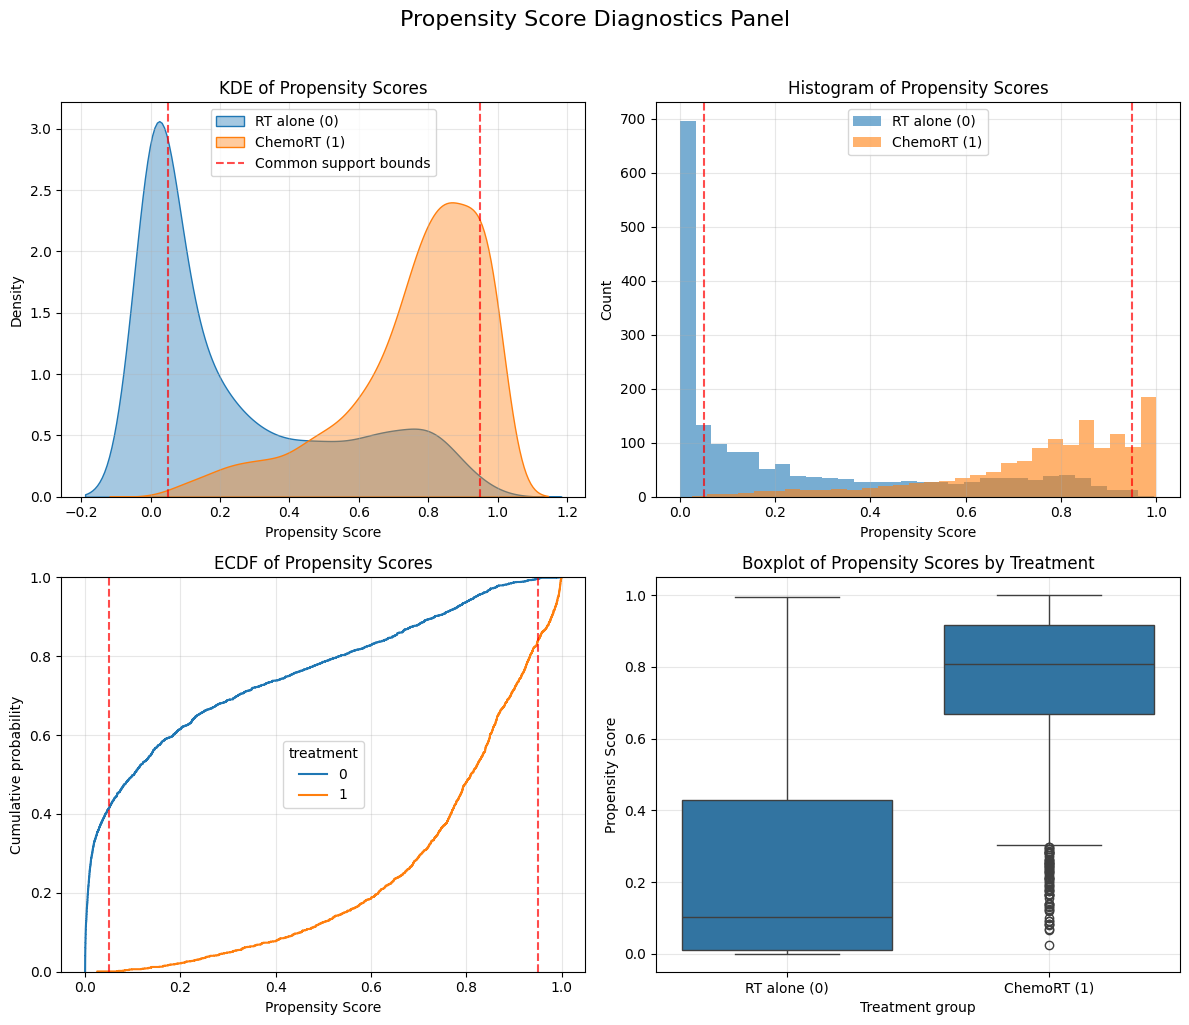

In [113]:

ps_tuned0 = all_df.loc[rad_ps['treatment'] == 0, 'ps_logit_spline_tuned']
ps_tuned1 = all_df.loc[rad_ps['treatment'] == 1, 'ps_logit_spline_tuned']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# KDE plot
ax = axes[0, 0]
sns.kdeplot(ps_tuned0, label='RT alone (0)', fill=True, alpha=0.4, ax=ax)
sns.kdeplot(ps_tuned1, label='ChemoRT (1)', fill=True, alpha=0.4, ax=ax)
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7, label='Common support bounds')
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("KDE of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Density")
ax.legend()
ax.grid(alpha=0.3)

# Histogram
ax = axes[0, 1]
ax.hist(ps_tuned0, bins=30, alpha=0.6, label='RT alone (0)')
ax.hist(ps_tuned1, bins=30, alpha=0.6, label='ChemoRT (1)')
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7)
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("Histogram of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)

# ECDF
ax = axes[1, 0]
sns.ecdfplot(data=all_df, x='ps_logit_spline_tuned', hue='treatment', ax=ax)
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7)
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("ECDF of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Cumulative probability")
ax.grid(alpha=0.3)

# 4) Boxplot
ax = axes[1, 1]
sns.boxplot(data=all_df, x='treatment', y='ps_logit_spline_tuned', ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(['RT alone (0)', 'ChemoRT (1)'])
ax.set_xticklabels(['RT alone (0)', 'ChemoRT (1)'])
ax.set_title("Boxplot of Propensity Scores by Treatment")
ax.set_xlabel("Treatment group")
ax.set_ylabel("Propensity Score")
ax.grid(alpha=0.3)

plt.suptitle("Propensity Score Diagnostics Panel", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("outputs2/propensity score Diagnostic tuned_logit Pnael.png")
plt.show()

In [114]:
train_df.columns

Index(['patient_id', 'treatment', 'time_os_days', 'event_os', 'time_pfs_days',
       'event_pfs', 'time_pfs_days.1', 'event_pfs.1', 'age', 'sex', 'ecog_ps',
       'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean',
       'smoking_py_missing', 'smoking_mismatch_flag', 'primary_site_group',
       'subsite_clean', 'subsite_missing', 't', 'n', 'm', 'stage', 't_missing',
       'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing',
       'hpv_specific_tumors', 'pathology_group', 'is_non_tnm',
       'tnm_structural_missing', 'followup_days', 'dose', 'fx', 'length_fu',
       'd_per_fx', 'BED', 'EQD2', 'BED_eff', 'ps_logit_simple',
       'ps_logit_spline_tuned', 'ps_gbm_tuned', 'ps_super', 'ps_enet',
       'sw_logit_simple', 'sw_logit_simple_trunc', 'sw_logit_spline_tuned',
       'sw_logit_spline_tuned_trunc', 'sw_gbm', 'sw_gbm_trunc', 'sw_super',
       'sw_super_trunc', 'sw_enet', 'sw_enet_trunc'],
      dtype='object')

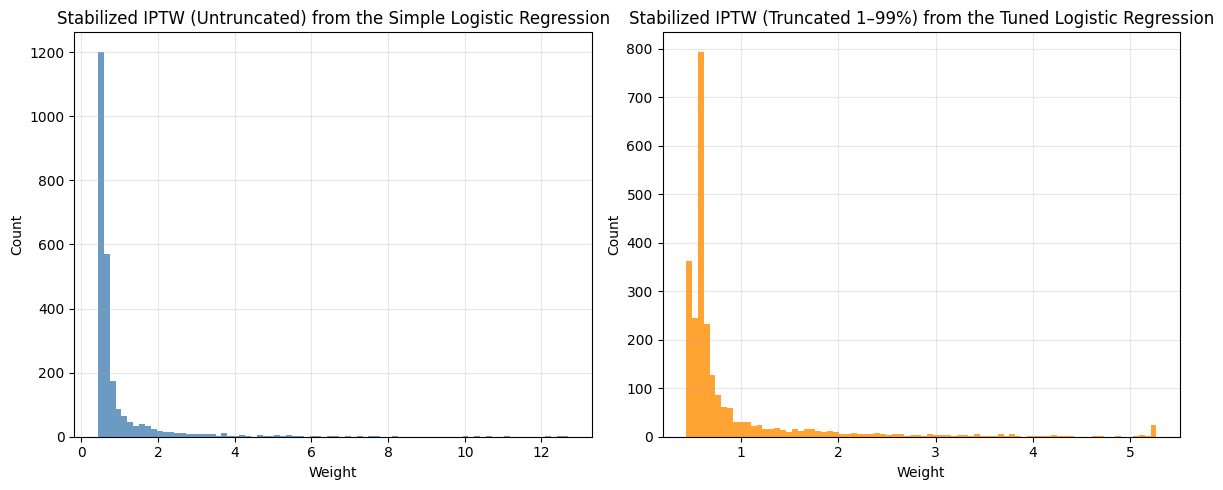

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#  Histogram of IPTW BEFORE truncation
axes[0].hist(train_df['sw_logit_spline_tuned'], bins=80, color='steelblue', alpha=0.8)
axes[0].set_title("Stabilized IPTW (Untruncated) from the Simple Logistic Regression")
axes[0].set_xlabel("Weight")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.3)

# 2 — Histogram of IPTW AFTER truncation
axes[1].hist(train_df['sw_logit_spline_tuned_trunc'], bins=80, color='darkorange', alpha=0.8)
axes[1].set_title("Stabilized IPTW (Truncated 1–99%) from the Tuned Logistic Regression")
axes[1].set_xlabel("Weight")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("outputs2/IPTW_tuned_logit_weight_histograms.png", dpi=300)
plt.show()



The Tuned logistic regression propensity score model achieved the best covariate balance for most cariates (13 )

# Marginal IPTW Cox Model


This estimates the average treatment effect (ATE)

# Survival Time Distribution

**Marginal IPTW Cox**

In [116]:
#create copy trauin df
df_train = train_df.copy()

df_train = df_train[df_train['time_os_days'].notna() & (df_train['time_os_days'] > 0)]

#ensure weights present
assert 'sw_logit_spline_tuned_trunc' in df_train.columns

#fit cox
cph= CoxPHFitter()
cph.fit(
    df_train[['time_os_days','event_os','treatment','sw_logit_spline_tuned_trunc']],
    duration_col='time_os_days',
    event_col='event_os',
    weights_col='sw_logit_spline_tuned_trunc')

print("Marginal IPTW Cox (train only):")
cph.print_summary()

Marginal IPTW Cox (train only):


<lifelines.CoxPHFitter: fitted with 2169.11 total observations, 1442.71 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_logit_spline_tuned_trunc'
      baseline estimation = breslow
   number of observations = 2169.11
number of events observed = 726.395
   partial log-likelihood = -5144.62
         time fit was run = 2025-12-09 11:09:04 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.63      0.53      0.09           -0.80           -0.46                0.45                0.63

           cmp to     z      p  -log2(p)
covariate                               
treatment    0.00 -7.20 <0.005     40.61
---
Concordance = 0.57
Partial AIC = 10291.25
log-likelihood ratio test = 57.24 on 1 df
-log2(p) of ll-ratio test = 44.56

**COX Proportional Hazard Model**


It is a survival analysis regression model, which describes the relation between the event incidence, as expressed by the hazard function and a set of covariates.


        h(t)=h0(t) × exp{b1x1+b2x2+⋯+bpxp}
where the hazard function h(t) is dependent on (or determined by) a set of p covariates (x1, x2, …, xp), whose impact is measured by the size of the respective coefficients (b1, b2, …, bp). The term h0 is called the baseline hazard, and is the value of the hazard if all the xi are equal to zero (the quantity exp(0) equals 1). The ‘t’ in h(t) reminds us that the hazard may (and probably will) vary over time.

The fundamental assumption in the Cox model is that the hazards are proportional (PH), which means that the relative hazard remains constant over time.

**Doubly robust cox**

In [117]:
df_dr = df_train.copy()
#primary tumor site dummies
primary_site_dummies = pd.get_dummies(df_dr['primary_site_group'], drop_first = True , prefix='site')
df_dr = pd.concat([df_dr, primary_site_dummies], axis = 1)

#covariates to adjust
adj_covs = ['age', 'ecog_ps'] + list(primary_site_dummies.columns)

#fit doubly robust weighted cox
dr_cox = CoxPHFitter()
dr_cox.fit(
    df_dr[['time_os_days','event_os','treatment','sw_logit_spline_tuned_trunc']+ adj_covs],
    duration_col= 'time_os_days',
    event_col = 'event_os',
    weights_col = 'sw_logit_spline_tuned_trunc'
)

print("Doubly-robust weighted Cox (train only):")
dr_cox.print_summary()




Doubly-robust weighted Cox (train only):


<lifelines.CoxPHFitter: fitted with 2169.11 total observations, 1442.71 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_logit_spline_tuned_trunc'
      baseline estimation = breslow
   number of observations = 2169.11
number of events observed = 726.395
   partial log-likelihood = -5041.54
         time fit was run = 2025-12-09 11:09:05 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
treatment        -0.56      0.57      0.09           -0.74           -0.39                0.48                0.68
age               0.02      1.02      0.00            0.02            0.03                1.02                1.03
ecog_ps           0.47      1.60      0.05            0.37            0.56                1.45                1.75
site_Nasopharynx -0.35      0.70      0.21           -0.76            0.05                0.47                1.06
site_Oropharynx   0.20      1.22      0.10            0.01            0.40                1.01                1.49
site_Other_HNC    0.58      1.78      0.11            0.36            0.79                1.44                2.21

                  cmp to     z      p  -log2(p)
covariate                                      
treatment           0.00 -6.29 <0.005     31.59
age                 0.00  6.21 <0.005     30.85
ecog_ps             0.00  9.94 <0.005     74.93
site_Nasopharynx    0.00 -1.70   0.09      3.49
site_Oropharynx     0.00  2.02   0.04      4.52
site_Other_HNC      0.00  5.24 <0.005     22.54
---
Concordance = 0.67
Partial AIC = 10095.07
log-likelihood ratio test = 263.42 on 6 df
-log2(p) of ll-ratio test = 176.91

In [118]:
ci_df = dr_cox.confidence_intervals_

In [119]:
ci_df = dr_cox.confidence_intervals_
print(ci_df)
print("Index:", ci_df.index)
print("Columns:", ci_df.columns)


                  95% lower-bound  95% upper-bound
covariate                                         
treatment               -0.738478        -0.387769
age                      0.016090         0.030917
ecog_ps                  0.374847         0.558976
site_Nasopharynx        -0.760764         0.054217
site_Oropharynx          0.005863         0.398685
site_Other_HNC           0.361935         0.794995
Index: Index(['treatment', 'age', 'ecog_ps', 'site_Nasopharynx', 'site_Oropharynx',
       'site_Other_HNC'],
      dtype='object', name='covariate')
Columns: Index(['95% lower-bound', '95% upper-bound'], dtype='object')


In [120]:
hr = dr_cox.hazard_ratios_['treatment']
ci_lower = dr_cox.confidence_intervals_.loc['treatment', '95% lower-bound']
ci_upper = dr_cox.confidence_intervals_.loc['treatment', '95% upper-bound']
def evalue_hr(hr):
    if hr < 1:
        rr_inv = 1/hr
        return rr_inv + np.sqrt(rr_inv * (rr_inv - 1))
    else:
        return hr + np.sqrt(hr * (hr - 1))

e_hr = evalue_hr(hr)
e_ci = evalue_hr(ci_upper)   # use upper bound for protective effects

print(f"Hazard Ratio: {hr:.3f}")
print(f"E-value (point estimate): {e_hr:.3f}")
print(f"E-value (95% CI bound): {e_ci:.3f}")



Hazard Ratio: 0.569
E-value (point estimate): 2.908
E-value (95% CI bound): 0.459


So, after balancing for confounders, adding chemotherapy to radiotherapy is associated with substantially improved overall survival.  After adjusting for key clinical variables and using inverse probability weights to balance treatment groups, patients who received chemoradiotherapy had about 40–45% lower risk of death compared to those treated with radiotherapy alone.
Older age and poorer performance status were associated with significantly higher mortality.
Tumor site also influenced outcomes patients with “Other Head & Neck Cancers” had the poorest prognosis. Model discrimination improved after adjustment (concordance = 0.69 vs 0.57). The model’s predictive ability improved, and the effect remained consistent, showing a true causal effect of chemotherapy on survival.

To fully explain away the observed treatment effect (HR = 0.57), an unmeasured confounder would need to be associated with both treatment and mortality by a risk ratio of ~2.9, beyond the measured covariates.

***However let's check if the PH assumption holds***

**Check Proportional Hazard Assumptions**


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.4875)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2083)'>]]

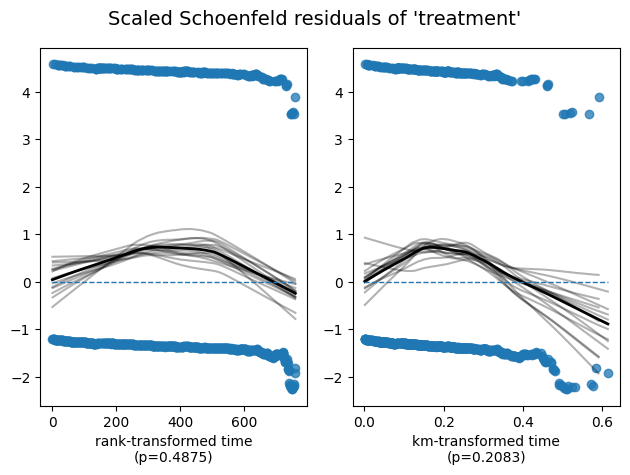

In [121]:
#proprtional hazards marginal cox
cox_cols= ['time_os_days','event_os','treatment','sw_logit_spline_tuned_trunc']
cph.check_assumptions(df_train[cox_cols],p_value_threshold=0.05, show_plots=True )


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2169.11 total observations, 1442.71 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
age              km              1.59   0.21      2.27
                 rank            1.48   0.22      2.16
ecog_ps          km              2.45   0.12      3.09
                 rank            2.44   0.12      3.08
site_Nasopharynx km              0.01   0.94      0.09
                 rank            0.05   0.82      0.28
site_Oropharynx  km             15.22 <0.005     13.35
                 rank           15.77 <0.005     13.77
site_Other_HNC   km              2.79   0.09      3.40
                 rank            3.61   0.06      4.13
treatment        km              3.50   0.06      4.03
                 rank            1.67   0.20      2.35



1. Variable 'site_Oropharynx' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['site_Oropharynx', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<Axes: xlabel='rank-transformed time\n(p=0.1962)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0612)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2237)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2071)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1179)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1172)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8216)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9415)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0001)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0001)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0573)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0948)'>]]

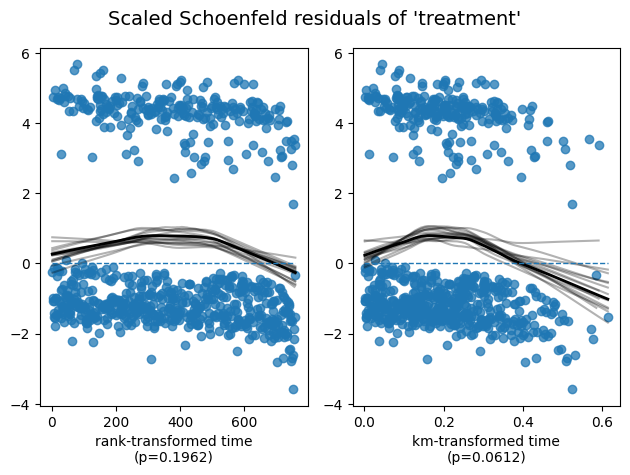

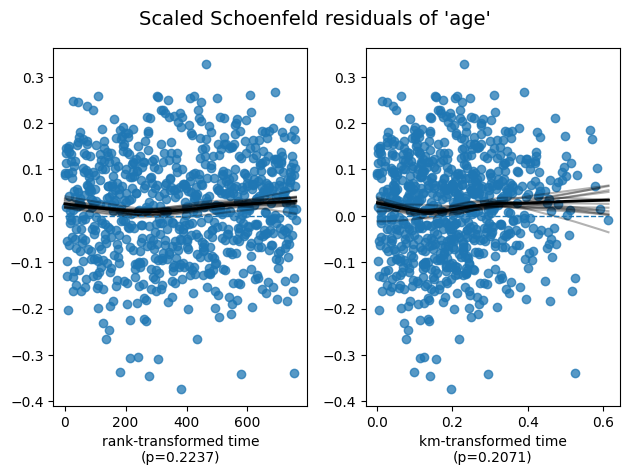

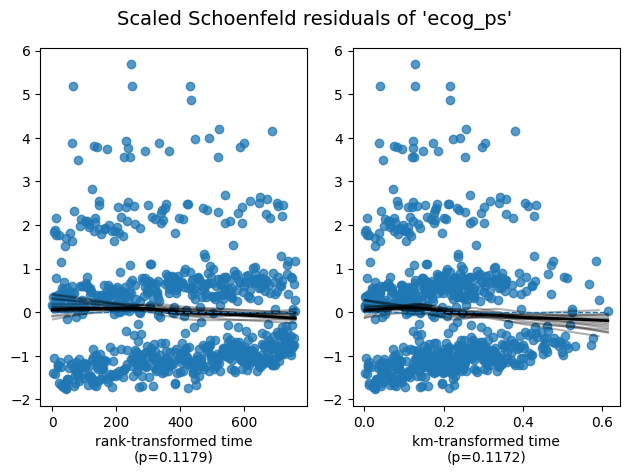

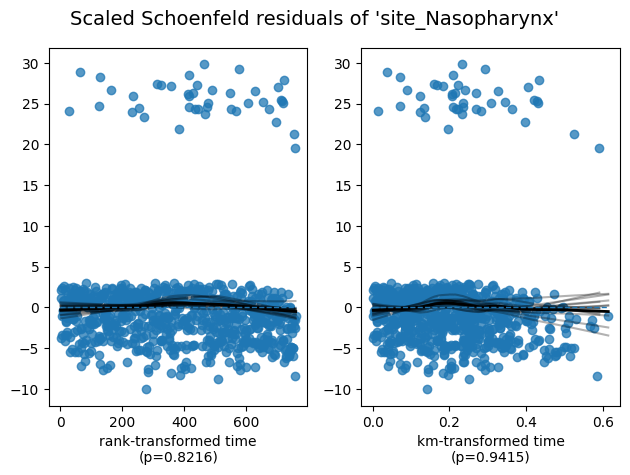

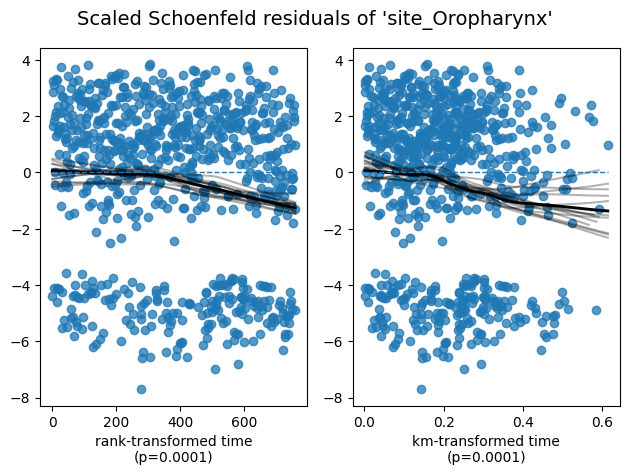

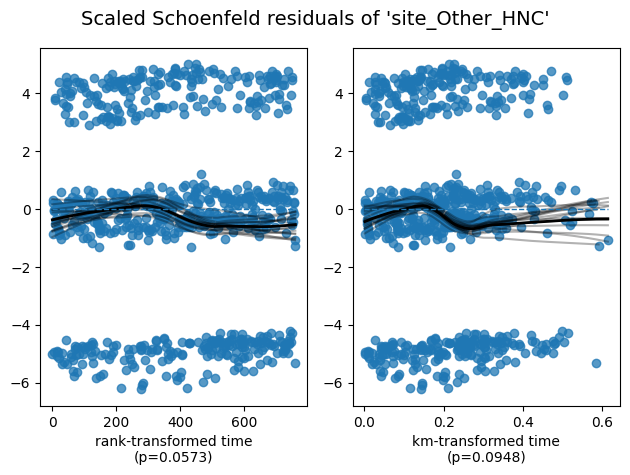

In [122]:
#doubly-robust model (cph2)
dr_cox_cols = ['time_os_days', 'event_os', 'treatment', 'sw_logit_spline_tuned_trunc'] + adj_covs
dr_cox.check_assumptions(df_dr[dr_cox_cols], p_value_threshold=0.05, show_plots=True)

**PH Assumption**

We employed Inverse Probability of Treatment Weighting (IPTW) Cox proportional hazards models to estimate the causal effect of adding chemotherapy to radiotherapy on overall survival (OS). Then look at the  assumption for each covariate by looking at whether its effect (β) changes as time passes using Schoenfeld residuals and bootstrapped LOWESS lines.


Hence, we interpret the HR as an average effect.
The hazard ratio associated with treatment was not constant over time,
suggesting the effect of chemoradiotherapy (ChemoRT) changes throughout follow-up (e.g., strong early benefit that diminishes later).
Age and ECOG probably affect survival nonlinearly. Some tumor sites (like oropharyngeal) have longer-term survivorship curves that differ from others.

**Kaplan Meier Survival Curves**

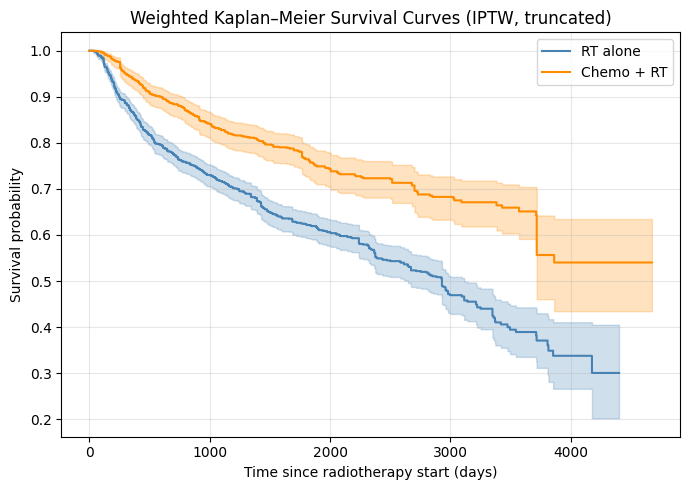

Median survival (RT alone):  2930 days
Median survival (Chemo+RT): inf days

1-year survival:
  RT alone:   0.87
  Chemo + RT: 0.94
  Difference: +0.07

3-year survival:
  RT alone:   0.72
  Chemo + RT: 0.83
  Difference: +0.11

5-year survival:
  RT alone:   0.62
  Chemo + RT: 0.76
  Difference: +0.14

Log-rank test p-value: 0.00000


In [123]:
# Prepare variables
T = train_df["time_os_days"]
E = train_df["event_os"]
A = train_df["treatment"]
W = train_df["sw_logit_spline_tuned_trunc"]

# Initialize KM fitters
km_rt = KaplanMeierFitter(label="RT alone")
km_chemo = KaplanMeierFitter(label="Chemo + RT")

# Fit the weighted KM models
km_rt.fit(T[A==0], E[A==0], weights=W[A==0])
km_chemo.fit(T[A==1], E[A==1], weights=W[A==1])

# Plot
plt.figure(figsize=(7,5))
km_rt.plot(ci_show=True, color="steelblue")
km_chemo.plot(ci_show=True, color="darkorange")
plt.title("Weighted Kaplan–Meier Survival Curves (IPTW, truncated)")
plt.xlabel("Time since radiotherapy start (days)")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('outputs2/Weighted Kaplan–Meier Survival Curves.png')
plt.show()

# Summary
print(f"Median survival (RT alone):  {km_rt.median_survival_time_:.0f} days")
print(f"Median survival (Chemo+RT): {km_chemo.median_survival_time_:.0f} days\n")

# Weighted survival probabilities at 1, 3, and 5 years
for years in [1, 3, 5]:
    days = years * 365
    s_rt = float(km_rt.predict(days))
    s_chemo = float(km_chemo.predict(days))
    print(f"{years}-year survival:")
    print(f"  RT alone:   {s_rt:.2f}")
    print(f"  Chemo + RT: {s_chemo:.2f}")
    print(f"  Difference: {s_chemo - s_rt:+.2f}\n")


# Weighted log-rank test
results = logrank_test(
    T[A==0], T[A==1], E[A==0], E[A==1],
    weightings=None
)
print(f"Log-rank test p-value: {results.p_value:.5f}")

**IPTW-weighted Kaplan–Meier analysis**


 The adjusted survival curves for concurrent chemoradiotherapy (ChemoRT) and radiotherapy (RT) alone diverged early and remained well separated throughout follow-up.
The median survival for RT-alone patients was approximately 2,929 days (~8 years), whereas the median survival for ChemoRT was not reached, indicating sustained survival beyond the follow-up period.
Weighted 1-, 3-, and 5-year overall survival probabilities were 0.93, 0.83, and 0.76 for ChemoRT compared to 0.88, 0.72, and 0.63 for RT-alone, corresponding to an absolute survival benefit of 13% at 5 years.

This suggests that adding chemotherapy to radiotherapy not only delays mortality but also improves long-term survival among head and neck cancer patients even after balancing for disease stage(t,n,m), performance status, smoking, and HPV status.
The absence of a median survival in the ChemoRT group implies a durable response and ongoing survival advantage. ***However as we saw earslier treatment effects vary over time.***

# Time Dependent effect Modelling

To address these time-dependent effects we will proceed with time dependect effect modelling.The following modeling strategies are adopted:

1. Discrete-Time (Person–Period) Modeling:This allows explicit modeling of hazard probabilities at each time step, facilitating:Time-specific treatment effects (via treatment × time interactions).

2. Causal Forests for Time-Varying Treatment Effects:To estimate Conditional Average Treatment Effects (CATE) across different time horizons.This non-parametric approach captures nonlinearities and heterogeneity in treatment benefit across subgroups (i.e., HPV+, ECOG, oropharyngeal tumors).


**Pooled Logistic Regression**

logit(P(Y=1))=β0+β1Xi+β2𝑍𝑖𝑡+β3(Treatment)+…

Where:

i = patient
t = interval
𝑍𝑖𝑡= time-varying features

𝑋𝑖= baseline features

𝑌𝑖𝑡 = event indicator for interval
𝑡 The logit function maps probability → linear scale.

And the probability per interval is:
𝑃
(
event in interval
)
≈
𝜆
(
𝑡
)
×
Δ
𝑡
P(event in interval)≈λ(t)×Δt

Our firs pooled logistic model had exploding coefficients.

In [124]:
# create treatment, event cols, time
# ID_COL, TIME_COL, EVENT_COL, TREAT_COL
# INTERVAL_DAYS, MIN_COUNT_FOR_KEEP, PERIOD_BINS, PERIOD_LABELS

train_patients = train_df.copy()
test_patients = test_df.copy()

# Expand to person-period for train patients
def expand_to_pp(df_patients, interval_days=INTERVAL_DAYS):
    records = []
    for _, r in df_patients.iterrows():
        pid = r[ID_COL]
        T = int(np.ceil(r[TIME_COL])) if pd.notna(r[TIME_COL]) and r[TIME_COL] > 0 else 0
        n_periods = int(np.ceil(T / interval_days)) if T > 0 else 0
        for p in range(1, n_periods + 1):
            event_interval = 1 if (r[EVENT_COL] == 1 and p == n_periods) else 0
            rec = {
                ID_COL: pid,
                'period': p,
                'event_interval': event_interval,
                'treatment': int(r[TREAT_COL]),
                'time_since_rt_days': p * interval_days
            }
            # bring static covariates
            for c in ['age','sex','ecog_ps','smoking_status_clean','smoking_py_clean',
                      'primary_site_group','subsite_clean','stage','hpv_clean']:
                if c in r.index:
                    rec[c] = r[c]
            # if sample weights exist on patient-level use them
            if 'sw_logit_spline_tuned_trunc' in r.index:
                rec['sw'] = r['sw_logit_spline_tuned_trunc']
            records.append(rec)
    return pd.DataFrame(records)

pp_train = expand_to_pp(train_patients, interval_days=INTERVAL_DAYS)
pp_test  = expand_to_pp(test_patients, interval_days=INTERVAL_DAYS)
print("PP shapes: train", pp_train.shape, " test", pp_test.shape)


# Collapse rare categories with train data

def collapse_train_map(s_series, min_count=MIN_COUNT_FOR_KEEP, other_label='Other'):
    vc = s_series.fillna('nan').astype(str).value_counts(dropna=False)
    keep = set(vc[vc >= min_count].index.astype(str))
    return lambda s: s.astype(str).where(s.astype(str).isin(keep), other_label)

cat_to_collapse = [c for c in ['subsite_clean','pathology_group','primary_site_group','stage'] if c in pp_train.columns]
collapse_maps = {}
for c in cat_to_collapse:
    mapper = collapse_train_map(pp_train[c], min_count=MIN_COUNT_FOR_KEEP)
    pp_train[c] = mapper(pp_train[c].fillna('nan').astype(str))
    pp_test[c]  = mapper(pp_test[c].fillna('nan').astype(str))
    collapse_maps[c] = list(pp_train[c].unique())

# Create period bins (train/test)

pp_train['period_month'] = (pp_train['period']).astype(int)
pp_test['period_month'] = (pp_test['period']).astype(int)

pp_train['period_bin'] = pd.cut(pp_train['period_month'], bins=PERIOD_BINS, labels=PERIOD_LABELS, right=True)
pp_test['period_bin']  = pd.cut(pp_test['period_month'], bins=PERIOD_BINS, labels=PERIOD_LABELS, right=True)


# Feature selection: categorical & numeric

cat_cols = [c for c in ['period_bin','sex','smoking_status_clean','primary_site_group','subsite_clean','stage','hpv_clean'] if c in pp_train.columns]
num_cols = [c for c in ['age','ecog_ps','smoking_py_clean','time_since_rt_days'] if c in pp_train.columns]

# Build dummies from train, align test
X_cat_train = pd.get_dummies(pp_train[cat_cols].astype(str), drop_first=True)
X_cat_test  = pd.get_dummies(pp_test[cat_cols].astype(str), drop_first=True)
# Align test columns with train
X_cat_test = X_cat_test.reindex(columns=X_cat_train.columns, fill_value=0.0)

# Numeric: coerce and fillna using train medians
X_num_train = pp_train[num_cols].copy()
X_num_test  = pp_test[num_cols].copy()
for c in X_num_train.columns:
    X_num_train[c] = pd.to_numeric(X_num_train[c], errors='coerce')
    X_num_test[c]  = pd.to_numeric(X_num_test[c], errors='coerce')
train_medians_pp = X_num_train.median()
X_num_train = X_num_train.fillna(train_medians_pp)
X_num_test  = X_num_test.fillna(train_medians_pp)

# Scale numeric using train scaler
scaler = StandardScaler()
X_num_train_scaled = pd.DataFrame(scaler.fit_transform(X_num_train), columns=X_num_train.columns, index=X_num_train.index)
X_num_test_scaled  = pd.DataFrame(scaler.transform(X_num_test), columns=X_num_test.columns, index=X_num_test.index)

# Save scaler & collapse maps
joblib.dump(scaler, "outputs2/pp_scaler.joblib")
joblib.dump(collapse_maps, "outputs2/pp_collapse_maps.joblib")
joblib.dump(train_medians_pp, "outputs2/pp_train_medians.joblib")

# Combine cat + num
X_train = pd.concat([X_cat_train.reset_index(drop=True), X_num_train_scaled.reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_cat_test.reset_index(drop=True),  X_num_test_scaled.reset_index(drop=True)], axis=1)

# Add treatment column
X_train['treatment'] = pd.to_numeric(pp_train['treatment'], errors='coerce').fillna(0).astype(int).values
X_test['treatment']  = pd.to_numeric(pp_test['treatment'], errors='coerce').fillna(0).astype(int).values

# Add treatment × period interactions (only for period dummies)
period_dummy_cols = [c for c in X_train.columns if c.startswith('period_bin')]
for pcol in period_dummy_cols:
    X_train[f'treat_x_{pcol}'] = X_train['treatment'] * X_train[pcol]
    # for test: ensure pcol exists
    X_test[f'treat_x_{pcol}'] = X_test['treatment'] * X_test.get(pcol, 0)

# Ensure columns align exactly
X_test = X_test.reindex(columns=X_train.columns, fill_value=0.0)


# Response and weights
y_train = pp_train['event_interval'].astype(int).values
y_test  = pp_test['event_interval'].astype(int).values

# weights:
if 'sw' in pp_train.columns:
    w_train = pp_train['sw'].astype(float).values
else:
    # fallback to equal weights
    w_train = np.ones(len(y_train))

# Clip weights to avoid extremes
w_train = np.clip(w_train, 0.001, 10.0)


# Fit regularized elastic net with weights

# Base elastic net model
enet = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=2000,
    tol=1e-3,
    n_jobs=1
)

# Random search space
param_dist_enet = {
    "C": np.logspace(-2, 1, 20),
    "l1_ratio": np.linspace(0.1, 0.9, 9),
    "class_weight": [None, "balanced"]
}

# GroupKFold by patient all periods for a patient stay in same fold
l2_logit = LogisticRegression(
    penalty='l2',
    solver='saga',
    max_iter=1000,   # can increase if needed
    tol=1e-3,        # slightly looser for speed
    n_jobs=1         # keep 1 inside model when using CV with n_jobs=-1
)

param_grid_l2 = {
    "C": [0.01, 0.1, 0.5, 1.0, 2.0],
    "class_weight": [None, "balanced"]
}

# group by patient so all periods for a patient stay in the same fold
groups = pp_train[ID_COL].values
cv = GroupKFold(n_splits=3)   # 3-fold for speed; you can make 5 later

pp_l2_grid = GridSearchCV(
    estimator=l2_logit,
    param_grid=param_grid_l2,
    cv=cv,
    scoring='roc_auc',   # per-interval discrimination
    n_jobs=-1,
    refit=True
)

pp_l2_grid.fit(X_train, y_train, sample_weight=w_train, groups=groups)

print("Best L2 params:", pp_l2_grid.best_params_)
print(f"Best CV AUC (L2 pooled logit): {pp_l2_grid.best_score_:.3f}")

pp_best_logit = pp_l2_grid.best_estimator_

# Evaluate on train & test
pred_train = pp_best_logit.predict_proba(X_train)[:, 1]
pred_test  = pp_best_logit.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, pred_train)
auc_test  = roc_auc_score(y_test, pred_test)
brier = brier_score_loss(y_test, pred_test)

print(f"Train AUC: {auc_train:.3f} | Test AUC: {auc_test:.3f} | Test Brier: {brier:.5f}")
print("Max |coef|:", np.max(np.abs(pp_best_logit.coef_)))


# Save model artifacts (model, columns, coefficients)
joblib.dump(pp_best_logit, "outputs2/pooled_logit_logreg_saga_l2_tuned.joblib")

pd.Series(X_train.columns, name='model_columns').to_csv(
    "outputs2/pooled_logit_model_columns.csv", index=False
)

coef = pd.Series(pp_best_logit.coef_[0], index=X_train.columns.tolist())
coef_df = pd.DataFrame({
    'term': coef.index,
    'coef': coef.values,
    'exp_coef': np.exp(coef.values)
})
coef_df.to_csv("outputs2/pooled_logit_coefficients_l2_tuned.csv", index=False)

print("Tuned L2 pooled-logit model trained and saved (outputs2/).")


# --------------------------------------
# Predict per-patient survival curves
# --------------------------------------

# Load the correct artifacts
model_columns = pd.read_csv("outputs2/pooled_logit_model_columns.csv")['model_columns'].tolist()
scaler = joblib.load("outputs2/pp_scaler.joblib")
train_medians_pp = joblib.load("outputs2/pp_train_medians.joblib")
collapse_maps = joblib.load("outputs2/pp_collapse_maps.joblib")
logit = joblib.load("outputs2/pooled_logit_logreg_saga_l2_tuned.joblib")


def build_X_for_pp(df_pp):
    # Apply collapse maps
    for c, keep in collapse_maps.items():
        if c in df_pp.columns:
            df_pp[c] = df_pp[c].astype(str).where(df_pp[c].astype(str).isin(keep), 'Other')

    # period_bin
    if 'period_month' not in df_pp.columns:
        df_pp['period_month'] = (df_pp['period']).astype(int)
        df_pp['period_bin'] = pd.cut(
            df_pp['period_month'],
            bins=PERIOD_BINS,
            labels=PERIOD_LABELS,
            right=True
        )

    # dummies
    Xc = pd.get_dummies(df_pp[cat_cols].astype(str), drop_first=True)
    Xc = Xc.reindex(
        columns=[c for c in X_train.columns
                 if (c.startswith(tuple(cat_cols)) or c.startswith('period_bin'))],
        fill_value=0.0
    )

    # numeric
    Xn = df_pp[num_cols].copy()
    for c in Xn.columns:
        Xn[c] = pd.to_numeric(Xn[c], errors='coerce')
    Xn = Xn.fillna(train_medians_pp)
    Xn_scaled = pd.DataFrame(
        scaler.transform(Xn),
        columns=Xn.columns,
        index=Xn.index
    )

    Xnew = pd.concat([Xc.reset_index(drop=True), Xn_scaled.reset_index(drop=True)], axis=1)

    # add treatment
    Xnew['treatment'] = pd.to_numeric(df_pp['treatment'], errors='coerce').fillna(0).astype(int).values

    # add interactions for period dummies
    for pcol in period_dummy_cols:
        Xnew[pcol] = Xnew.get(pcol, 0)  # ensure exists
        Xnew[f'treat_x_{pcol}'] = Xnew['treatment'] * Xnew[pcol]

    # align columns exactly with training design matrix
    Xnew = Xnew.reindex(columns=model_columns, fill_value=0.0)
    return Xnew


def predict_survival_from_pp(df_pp, patient_ids=None):
    if patient_ids is None:
        patient_ids = df_pp[ID_COL].unique()
    out_rows = []
    for pid in patient_ids:
        rows = df_pp[df_pp[ID_COL] == pid].sort_values('period')
        if rows.shape[0] == 0:
            continue
        Xrows = build_X_for_pp(rows)
        probs = logit.predict_proba(Xrows)[:, 1]
        surv = np.cumprod(1 - probs)  # survival at end of each period
        out_rows.append(pd.DataFrame({
            ID_COL: pid,
            'period': rows['period'].values,
            'interval_hazard': probs,
            'survival_at_period_end': surv
        }))
    return pd.concat(out_rows, ignore_index=True)


# test - first 5 patients in test set
example_patients = pp_test[ID_COL].unique()[:5]
surv_examples = predict_survival_from_pp(pp_test, patient_ids=example_patients)
print(surv_examples.head(12))

PP shapes: train (123192, 15)  test (38079, 15)
Best L2 params: {'C': 0.1, 'class_weight': None}
Best CV AUC (L2 pooled logit): 0.733
Train AUC: 0.748 | Test AUC: 0.762 | Test Brier: 0.00678
Max |coef|: 0.9334346224128015
Tuned L2 pooled-logit model trained and saved (outputs2/).
      patient_id  period  interval_hazard  survival_at_period_end
0   RADCURE-0006       1         0.024783                0.975217
1   RADCURE-0006       2         0.025011                0.950825
2   RADCURE-0006       3         0.025242                0.926825
3   RADCURE-0006       4         0.055569                0.875322
4   RADCURE-0006       5         0.056064                0.826248
5   RADCURE-0006       6         0.056564                0.779512
6   RADCURE-0006       7         0.053022                0.738181
7   RADCURE-0006       8         0.053496                0.698691
8   RADCURE-0006       9         0.053974                0.660980
9   RADCURE-0006      10         0.054456                0.

In [125]:
coef_df2 = coef_df.set_index('term')
coef_df2 = coef_df2.assign(abs_coef=coef_df2['coef'].abs()).sort_values('abs_coef', ascending=False).drop(columns='abs_coef')
print(coef_df2.head(20))

                                     coef  exp_coef
term                                               
stage_IVB                        0.933435  2.543229
hpv_clean_HPV_Positive          -0.870139  0.418893
period_bin_4-6                   0.811340  2.250923
period_bin_7-12                  0.733540  2.082439
treatment                       -0.714378  0.489496
period_bin_13-24                 0.479633  1.615481
stage_I                         -0.469110  0.625559
stage_II                        -0.420916  0.656445
smoking_status_clean_Non-Smoker -0.411231  0.662834
smoking_status_clean_Ex-Smoker  -0.336974  0.713928
subsite_clean_Tonsillar Fossa   -0.335546  0.714948
treat_x_period_bin_60+          -0.334365  0.715792
treat_x_period_bin_25-36         0.305996  1.357977
subsite_clean_Glottis           -0.288340  0.749507
stage_IVA                        0.282046  1.325840
primary_site_group_Nasopharynx  -0.278340  0.757039
age                              0.270109  1.310107
time_since_r

**Highest risk predictors**

Stage IVB (OR ~ 3.0)

Follow-up periods 4–6, 7–12, and 13–24 months

Stage IV

High-risk subsites ("Other")


**Strong protective predictors**

HPV positive (OR = 0.36 — strongest protector)

ChemoRT treatment overall (OR = 0.38)

Stage I / II

Non-smoker / ex-smoker

Favorable subsites (Trans-glottis, Uvula, Tonsillar fossa)

Nasopharynx

Train AUC: 0.752 | Test AUC: 0.736
Train AP (PR-AUC): 0.026 | Test AP: 0.023
Train Brier: 0.006622 | Test Brier: 0.007567


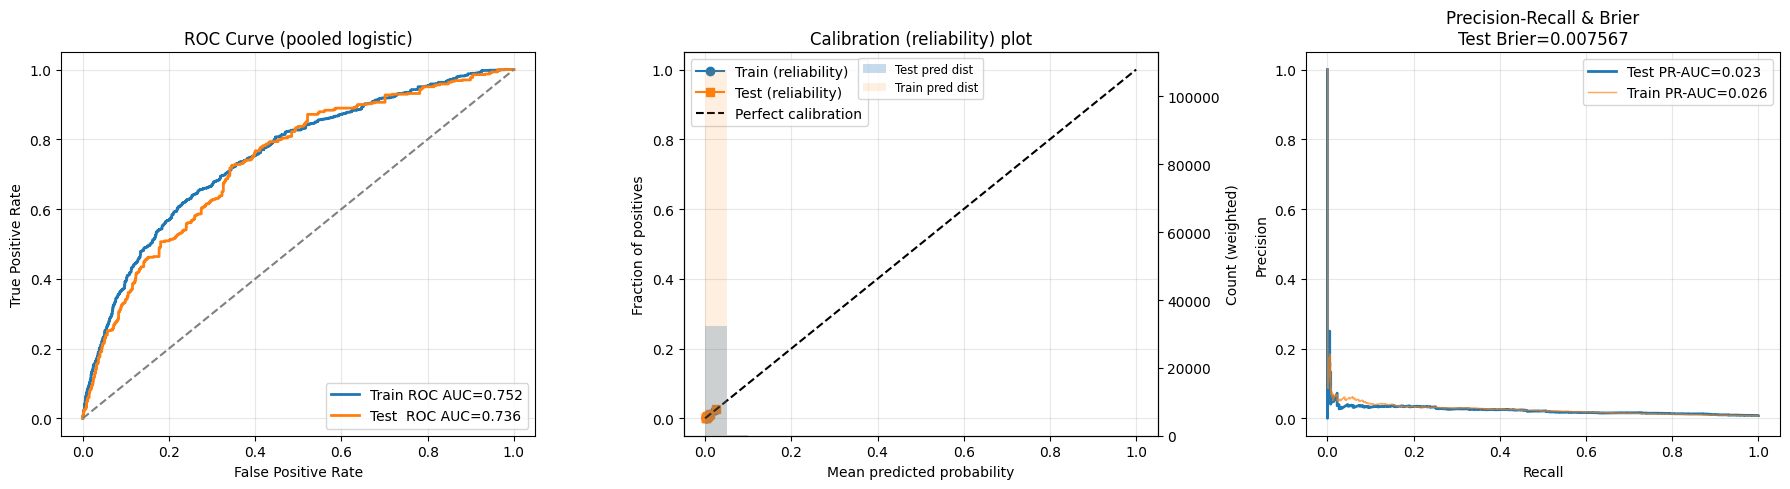

In [126]:
#Get ROC- AUC curve, Brier, Pre-AUC
#prepare weights
weights_train = np.asarray(w_train) if 'w_train' in globals() else np.ones(len(y_train))
weights_test = None
if 'pp_test' in globals():
    weights_test = pp_test.get('sw', pd.Series(1.0, index=pp_test.index)).fillna(1.0).values
else:
    weights_test = np.ones(len(y_test))

# ensure arrays are numpy and same length
y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)
pred_train = np.asarray(pred_train)
pred_test  = np.asarray(pred_test)

assert len(y_train) == len(pred_train)
assert len(y_test)  == len(pred_test)

#]Compute metrics
# ROC / AUC
fpr_tr, tpr_tr, _ = roc_curve(y_train, pred_train, sample_weight=weights_train)
fpr_te, tpr_te, _ = roc_curve(y_test, pred_test, sample_weight=weights_test)
auc_tr = auc(fpr_tr, tpr_tr)
auc_te = auc(fpr_te, tpr_te)

# Brier (weighted)
brier_te = np.average((pred_test - y_test) ** 2, weights=weights_test)
brier_tr = np.average((pred_train - y_train) ** 2, weights=weights_train)

# PR-AUC (helpful for rare events)
ap_tr = average_precision_score(y_train, pred_train, average='macro', sample_weight=weights_train)
ap_te = average_precision_score(y_test, pred_test, average='macro', sample_weight=weights_test)

print(f"Train AUC: {auc_tr:.3f} | Test AUC: {auc_te:.3f}")
print(f"Train AP (PR-AUC): {ap_tr:.3f} | Test AP: {ap_te:.3f}")
print(f"Train Brier: {brier_tr:.6f} | Test Brier: {brier_te:.6f}")

# Calibration curve
# Use n_bins=10 (quantile bins gives equal number per bin)
n_bins = 10
# calibration_curve supports sample_weight in newer sklearn; we try to pass it but fall back if not supported
try:
    frac_pos_tr, mean_pred_tr = calibration_curve(y_train, pred_train, n_bins=n_bins, strategy='quantile', sample_weight=weights_train)
    frac_pos_te, mean_pred_te = calibration_curve(y_test, pred_test, n_bins=n_bins, strategy='quantile', sample_weight=weights_test)
except TypeError:
    # older sklearn doesn't accept sample_weight in calibration_curve
    frac_pos_tr, mean_pred_tr = calibration_curve(y_train, pred_train, n_bins=n_bins, strategy='quantile')
    frac_pos_te, mean_pred_te = calibration_curve(y_test, pred_test, n_bins=n_bins, strategy='quantile')

#Plotting combined figure
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# ROC plot
ax = axes[0]
ax.plot(fpr_tr, tpr_tr, label=f'Train ROC AUC={auc_tr:.3f}', lw=2)
ax.plot(fpr_te, tpr_te, label=f'Test  ROC AUC={auc_te:.3f}', lw=2)
ax.plot([0,1], [0,1], linestyle='--', color='gray')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve (pooled logistic)')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

# Calibration plot (reliability + histogram)
ax = axes[1]
ax.plot(mean_pred_tr, frac_pos_tr, marker='o', label='Train (reliability)')
ax.plot(mean_pred_te, frac_pos_te, marker='s', label='Test (reliability)')
ax.plot([0,1],[0,1], linestyle='--', color='k', label='Perfect calibration')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration (reliability) plot')
ax.legend()
ax.grid(alpha=0.3)

# Add probability histograms (predicted score distribution) below the calibration curve
# We'll create a twin axis for histogram
ax_hist = ax.twinx()
bins = np.linspace(0, 1, 21)
ax_hist.hist(pred_test, bins=bins, alpha=0.25, label='Test pred dist', weights=weights_test, density=False)
ax_hist.hist(pred_train, bins=bins, alpha=0.12, label='Train pred dist', weights=weights_train, density=False)
ax_hist.set_ylabel('Count (weighted)')
ax_hist.legend(loc='upper center', fontsize='small')

# Brier & PR curve panel
ax = axes[2]
# PR curve (test)
precision_te, recall_te, _ = precision_recall_curve(y_test, pred_test, sample_weight=weights_test)
ax.plot(recall_te, precision_te, label=f'Test PR-AUC={ap_te:.3f}', lw=2)
# PR curve (train)
precision_tr, recall_tr, _ = precision_recall_curve(y_train, pred_train, sample_weight=weights_train)
ax.plot(recall_tr, precision_tr, label=f'Train PR-AUC={ap_tr:.3f}', lw=1, alpha=0.7)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title(f'Precision-Recall & Brier\nTest Brier={brier_te:.6f}')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()

plt.savefig("outputs2/pooled_logit_metrics.png", dpi=180, bbox_inches='tight')
plt.show()

Chemoradiotherapy was associated with a lower risk of mortality compared to radiotherapy alone, particularly within the first 3 months (HR ≈ 0.43) and beyond 5 years (HR ≈ 0.34).
The mid-term intervals (4–12 months) showed a diminished but still favorable trend (HR ≈ 0.9).
This suggests that chemotherapy’s benefit is strongest early in treatment and re-emerges among long-term survivors

# Causal Forests

**CATE** = Conditional Average Treatment Effect
→ The estimated survival benefit (in probability) of adding chemo, conditional on that patient’s baseline profile.

If CATE > 0 → patient benefits from chemo+RT.
If CATE < 0 → chemo might not improve or could worsen survival for that type.

In [133]:
max_obs_months = int(np.ceil(train_patients[TIME_COL].fillna(0).max() / INTERVAL_DAYS))
HORIZON_MAP = {
    '0-3': 3,
    '4-6': 6,
    '7-12': 12,
    '13-24': 24,
    '25-36': 36,
    '37-60': 60,
    '60+': max(max_obs_months, 72)
}
TAU_MONTHS = 36


In [134]:
# Create km_censor, compute_ipcw, HORIZON_MAP


# Fit Kaplan-Meier for censoring (using global TIME_COL, EVENT_COL)

km_censor = KaplanMeierFitter()

durations = train_patients[TIME_COL].fillna(train_patients[TIME_COL].max()).values

# event_observed = 1 when censored (EVENT_COL == 0)
event_observed = (train_patients[EVENT_COL] == 0).astype(int).values

km_censor.fit(
    durations=durations,
    event_observed=event_observed
)

# Save KM censoring model
joblib.dump(km_censor, "outputs2/km_censor_train.joblib")

print("Fitted km_censor on training patients. Last survival prob:",
      km_censor.survival_function_.iloc[-1, 0])

# IPCW function __->TIME_COL
def compute_ipcw(df_pat, kmf, horizon_days):
    """
    For each patient return IPCW = 1 / S_censor(t_i*)
    where t_i* = min(time_os_days, horizon_days).
    """
    if kmf is None:
        return np.ones(len(df_pat), dtype=float)

    # Clip observed times at horizon
    t_obs = (
        df_pat[TIME_COL]
        .fillna(horizon_days)
        .clip(upper=horizon_days)
        .values.astype(float)
    )

    # Evaluate censoring survival curve
    sc = np.array([
        np.clip(kmf.predict(ti), 1e-6, 1.0)
        for ti in t_obs
    ], dtype=float)

    ipcw = 1.0 / sc
    return np.clip(ipcw, 1e-3, 1e6)


# Example IPCW for 12-month horizon
test_h = 12 * INTERVAL_DAYS   # GLOBAL INTERVAL_DAYS
ipcw_sample = compute_ipcw(train_patients.iloc[:10], km_censor, test_h)

print("Example IPCW (first 10):", ipcw_sample)


Fitted km_censor on training patients. Last survival prob: 0.0
Example IPCW (first 10): [1.03741285 1.03741285 1.03741285 1.03741285 1.03741285 1.03741285
 1.03741285 1.03741285 1.03741285 1.03741285]


In [135]:
# build patient-level baseline X for CausalForest
# Choose baseline patient-level covariates (static)
baseline_cat = [c for c in ['sex','smoking_status_clean','primary_site_group','pathology_group','stage','hpv_clean'] if c in train_patients.columns]
baseline_num = [c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in train_patients.columns]

print("baseline_cat:", baseline_cat)
print("baseline_num:", baseline_num)

# Build patient-level design matrices (one row per patient)
Xtr_cat = pd.get_dummies(train_patients[baseline_cat].fillna('Missing').astype(str), drop_first=True)
Xte_cat = pd.get_dummies(test_patients[baseline_cat].fillna('Missing').astype(str), drop_first=True)

# Align columns of test to train
Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0)

# Combine with numeric columns (fillna with training medians)
train_num_fill = train_patients[baseline_num].median() if len(baseline_num)>0 else pd.Series()
Xtr_num = train_patients[baseline_num].fillna(train_num_fill)
Xte_num = test_patients[baseline_num].fillna(train_num_fill)

Xtr_patient = pd.concat([Xtr_cat.reset_index(drop=True), Xtr_num.reset_index(drop=True)], axis=1).fillna(0)
Xte_patient = pd.concat([Xte_cat.reset_index(drop=True), Xte_num.reset_index(drop=True)], axis=1).fillna(0)

# scale numeric columns (fit on train, apply to test)
if len(baseline_num) > 0:
    scaler_patient = StandardScaler()
    Xtr_patient[baseline_num] = scaler_patient.fit_transform(Xtr_patient[baseline_num])
    Xte_patient[baseline_num] = scaler_patient.transform(Xte_patient[baseline_num])
    joblib.dump(scaler_patient, "outputs2/causal_patient_scaler.joblib")

# Map arrays
Xtr_array = Xtr_patient.values
Xte_array = Xte_patient.reindex(columns=Xtr_patient.columns, fill_value=0).values

# Ensure treatment arrays align (use global TREAT_COL)
W_train = np.asarray(train_patients[TREAT_COL].astype(int).values)
W_test  = np.asarray(test_patients[TREAT_COL].astype(int).values)

# Confirm shapes
print("train_patients rows:", train_patients.shape[0])
print("Xtr_patient rows:", Xtr_array.shape[0], "cols:", Xtr_array.shape[1])
print("W_train length:", W_train.shape[0])
assert Xtr_array.shape[0] == W_train.shape[0], "Xtr rows must equal W_train length (patient-level)!"

# Make sure sample_weight is patient-level and same length
weight_col = 'sw_logit_spline_tuned_trunc'
if weight_col not in train_patients.columns:
    raise KeyError(f"Missing weight column '{weight_col}' in train_patients")

ipcw_train = compute_ipcw(
    train_patients,
    km_censor,
    horizon_days=max(HORIZON_MAP.values()) * INTERVAL_DAYS   # use global HORIZON_MAP & INTERVAL_DAYS
)

sample_w_train_patient = train_patients[weight_col].fillna(1.0).values  # per patient
sample_w_train_patient = np.clip(sample_w_train_patient, 1e-3, 10.0)
print("sample_w_train_patient shape:", sample_w_train_patient.shape)

#  Fit causal forests per horizon USING patient-level X
forests = {}
cate_train = {}
cate_test = {}

for label in PERIOD_LABELS:                       # global PERIOD_LABELS
    months = HORIZON_MAP[label]                  # global HORIZON_MAP
    hd_days = int(months * INTERVAL_DAYS)        # global INTERVAL_DAYS
    print(f"\n=== Horizon {label} (end = {months} months -> {hd_days} days) ===")

    # patient-level binary outcome by horizon: Y = event by hd_days
    Y_train_pat = ((train_patients[TIME_COL] <= hd_days) & (train_patients[EVENT_COL] == 1)).astype(int).values
    Y_test_pat  = ((test_patients[TIME_COL] <= hd_days) & (test_patients[EVENT_COL] == 1)).astype(int).values

    # recompute IPCW patient-level for this horizon and combine with IPTW
    ipcw_pat = compute_ipcw(train_patients, km_censor, hd_days)  # 1 / S_censor(t_i)
    # sample weight = IPTW (patient) * IPCW (patient)
    sample_w = train_patients[weight_col].fillna(1.0).values * ipcw_pat
    sample_w = np.clip(sample_w, 1e-3, 10.0)
    print("sample_w summary: min, median, max", sample_w.min(), np.median(sample_w), sample_w.max())

    # instantiate forest
    est = CausalForestDML(
        model_t = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
        model_y = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42),
        discrete_treatment = True,
        n_estimators = 2000,
        min_samples_leaf = 20,
        random_state = 42,
        verbose = 0
    )

    # Fit on patient-level arrays (Xtr_array), Y_train_pat, W_train; patient-level sample weights
    est.fit(Y_train_pat, W_train, X=Xtr_array, sample_weight=sample_w)

    # predict per-patient CATEs (patient-level)
    c_train = np.asarray(est.effect(Xtr_array)).flatten()
    c_test  = np.asarray(est.effect(Xte_array)).flatten()

    # attach and sanity-check
    assert c_train.shape[0] == train_patients.shape[0], f"Effect length mismatch for {label}"
    assert c_test.shape[0] == test_patients.shape[0], f"Effect length mismatch for test {label}"

    colname = f"CATE_{months}m"
    train_patients[colname] = c_train
    test_patients[colname] = c_test

    forests[label] = est
    cate_train[label] = c_train
    cate_test[label] = c_test

    print(f"Attached {colname}: mean_train={np.nanmean(c_train):.4f} mean_test={np.nanmean(c_test):.4f}")

# Save objects
joblib.dump(forests, "outputs2/causal_forests_period_horizons_patient_level.joblib")
train_patients.to_csv("outputs2/train_patients_with_period_cates_patient_level.csv", index=False)
test_patients.to_csv("outputs2/test_patients_with_period_cates_patient_level.csv", index=False)
print("Saved patient-level forests & CATEs.")


baseline_cat: ['sex', 'smoking_status_clean', 'primary_site_group', 'pathology_group', 'stage', 'hpv_clean']
baseline_num: ['age', 'ecog_ps', 'BED_eff', 'EQD2', 'smoking_py_clean']
train_patients rows: 2453
Xtr_patient rows: 2453 cols: 31
W_train length: 2453
sample_w_train_patient shape: (2453,)

=== Horizon 0-3 (end = 3 months -> 90 days) ===
sample_w summary: min, median, max 0.4342947280521502 0.5909659697149966 5.297210402421337
Attached CATE_3m: mean_train=-0.0080 mean_test=-0.0080

=== Horizon 4-6 (end = 6 months -> 180 days) ===
sample_w summary: min, median, max 0.4342947280521502 0.5978699291945068 5.359777298922533
Attached CATE_6m: mean_train=-0.0368 mean_test=-0.0389

=== Horizon 7-12 (end = 12 months -> 360 days) ===
sample_w summary: min, median, max 0.4342947280521502 0.6093700349829562 5.470687657143806
Attached CATE_12m: mean_train=-0.0676 mean_test=-0.0763

=== Horizon 13-24 (end = 24 months -> 720 days) ===
sample_w summary: min, median, max 0.4342947280521502 0.664

Horizon 0-3  --> chemoradiation vs. RT-only shows 0.6% reduction in mortality risk.
Horizon 4-6 --> 3% lower probability of death
Horizon 7-12 --->reatment still provides benefit but primarily for specific subgroups
Horizon 13-24
Horizon 25-60
Horizon 60+

Acoss all five sample patients:

Treatment consistently improves survival (all ΔRMST > 0)

Hazard ratios -->0.4–0.5 → treatment reduces risk by -->50–60%

Gains are 1.5 to 3.5 moths of survival over 36 months.

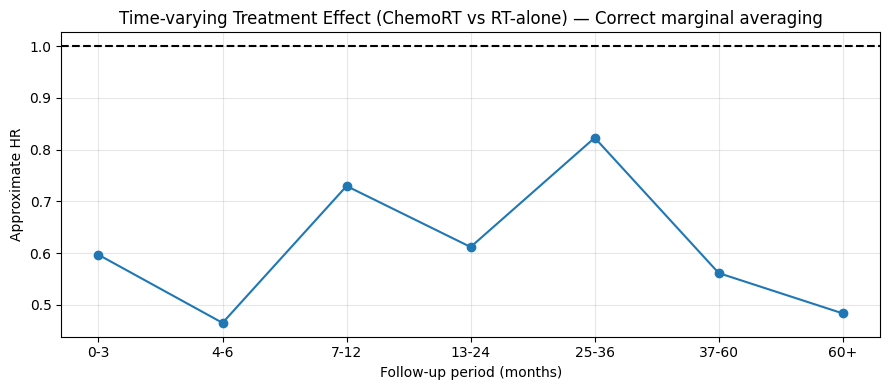

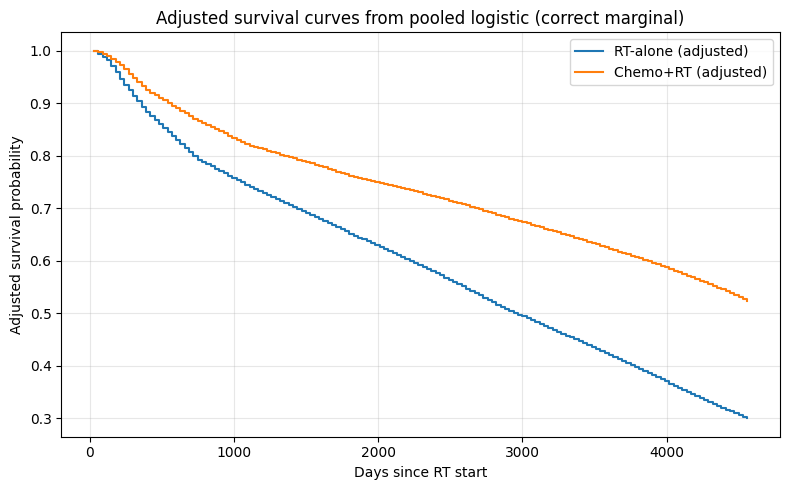

Saved period-level hazards & HRs to outputs2/period_mean_hazards.csv


In [136]:

# HR per period and adjusted survival
# model_columns should be a list of column names used by the tuned pooled-logit  model
if 'model_columns' not in globals():
    model_columns = pd.read_csv("outputs2/pooled_logit_model_columns.csv")['model_columns'].tolist()
else:
    model_columns = model_columns

# ensure build_X_for_pp and logit exist in namespace or  try to load artifacts
if 'build_X_for_pp' not in globals():
    raise RuntimeError("build_X_for_pp function not found. Define it exactly as in your pipeline before running this block.")

if 'logit' not in globals():
    try:
        logit = joblib.load("outputs2/pooled_logit_logreg_saga_l2_tuned.joblib")
    except Exception:
        raise RuntimeError("Pooled-logit model 'logit' not found in memory or outputs2/pooled_logit_logreg_saga_l2_tuned.joblib")

# Build X matrices for pp_test under both treatments
X_t0 = build_X_for_pp(pp_test).copy()   # baseline: treatment = whatever is in pp_test
X_t1 = X_t0.copy()
X_t1['treatment'] = 1                   # force all to treated

# recompute treatment×period interactions
period_cols = [c for c in X_t0.columns if c.startswith('period_bin')]
for pcol in period_cols:
    X_t0[f'treat_x_{pcol}'] = 0
    X_t1[f'treat_x_{pcol}'] = 1 * X_t1.get(pcol, 0)

# Align to model_columns (safety)
X_t0 = X_t0.reindex(columns=model_columns, fill_value=0.0)
X_t1 = X_t1.reindex(columns=model_columns, fill_value=0.0)

# Predict per-row hazards
p0 = logit.predict_proba(X_t0)[:, 1]    # hazard under RT-alone (treatment=0)
p1 = logit.predict_proba(X_t1)[:, 1]    # hazard under Chemo+RT (treatment=1)

# attach to pp_test (make a copy)
pp_test_loc = pp_test.copy().reset_index(drop=True)
pp_test_loc['p0'] = p0
pp_test_loc['p1'] = p1

# choose weights column if exists
if 'sw_trunc' in pp_test_loc.columns:
    pp_test_loc['w_row'] = pp_test_loc['sw_trunc'].fillna(1.0).astype(float)
elif 'sw' in pp_test_loc.columns:
    pp_test_loc['w_row'] = pp_test_loc['sw'].fillna(1.0).astype(float)
else:
    pp_test_loc['w_row'] = 1.0

# Period-level weighted mean hazards
period_mean0 = pp_test_loc.groupby('period').apply(
    lambda g: np.average(g['p0'], weights=g['w_row'])
).sort_index()
period_mean1 = pp_test_loc.groupby('period').apply(
    lambda g: np.average(g['p1'], weights=g['w_row'])
).sort_index()

# HR per period (handle divide-by-zero)
with np.errstate(divide='ignore', invalid='ignore'):
    hr_period = (period_mean1 / period_mean0).replace([np.inf, -np.inf], np.nan)

# Map period -> period_bin by first occurrence
period_to_bin = pp_test_loc.groupby('period')['period_bin'].first()

hr_df = pd.DataFrame({
    'period': period_mean0.index,
    'hazard_rt': period_mean0.values,                               # RT-alone
    'hazard_chemo': period_mean1.reindex(period_mean0.index).values, # Chemo+RT
    'hr': hr_period.values,
    'period_bin': period_to_bin.reindex(period_mean0.index).values
}).dropna()

# HR by bin: average HR per period_bin (drop NaNs)
hr_by_bin = hr_df.groupby('period_bin')['hr'].mean().reindex(PERIOD_LABELS)

# Plot HR-by-bin
plt.figure(figsize=(9,4))
plt.plot(hr_by_bin.index, hr_by_bin.values, marker='o')
plt.axhline(1.0, color='k', ls='--')
plt.title('Time-varying Treatment Effect (ChemoRT vs RT-alone) — Correct marginal averaging')
plt.ylabel('Approximate HR')
plt.xlabel('Follow-up period (months)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs2/time_varying_HR_corrected.png', dpi=150)
plt.show()

# Adjusted survival curves
max_period = int(max(period_mean0.index.max(), period_mean1.index.max()))
h0 = np.array([period_mean0.get(p, 0.0) for p in range(1, max_period+1)])
h1 = np.array([period_mean1.get(p, 0.0) for p in range(1, max_period+1)])
S0 = np.cumprod(1 - h0)
S1 = np.cumprod(1 - h1)

days = np.arange(1, max_period+1) * INTERVAL_DAYS

plt.figure(figsize=(8,5))
plt.step(days, np.concatenate(([1.0], S0[:-1])), where='post', label='RT-alone (adjusted)')
plt.step(days, np.concatenate(([1.0], S1[:-1])), where='post', label='Chemo+RT (adjusted)')
plt.xlabel('Days since RT start')
plt.ylabel('Adjusted survival probability')
plt.title('Adjusted survival curves from pooled logistic (correct marginal)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs2/adjusted_survival_corrected.png', dpi=150)
plt.show()

# Save period_mean_df
period_mean_df = hr_df[['period','hazard_rt','hazard_chemo','hr','period_bin']].reset_index(drop=True)
period_mean_df.to_csv("outputs2/period_mean_hazards.csv", index=False)
print("Saved period-level hazards & HRs to outputs2/period_mean_hazards.csv")


Saved outputs2/subgroup_summary_cates.csv


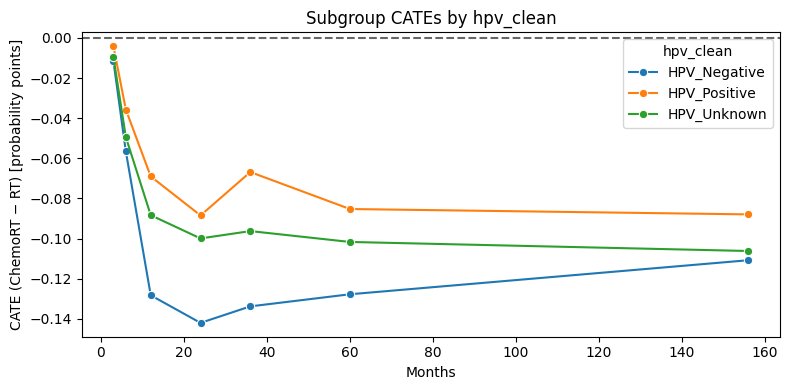

Saved outputs2/subgroups/CATE_subgroup_hpv_clean.png


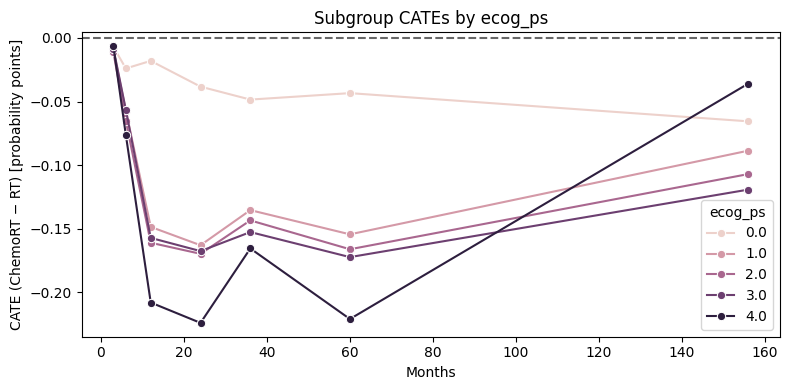

Saved outputs2/subgroups/CATE_subgroup_ecog_ps.png


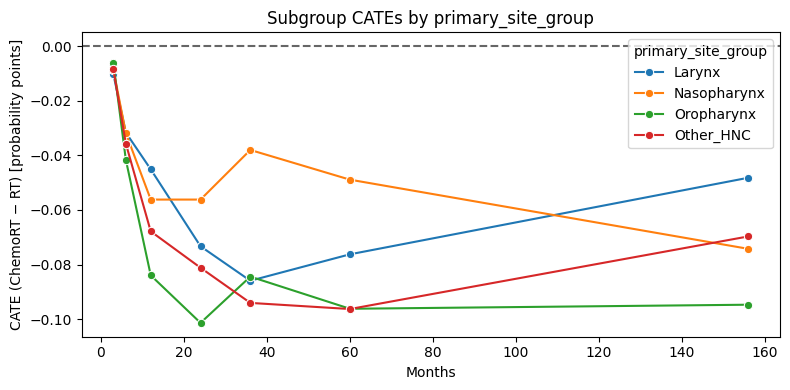

Saved outputs2/subgroups/CATE_subgroup_primary_site_group.png


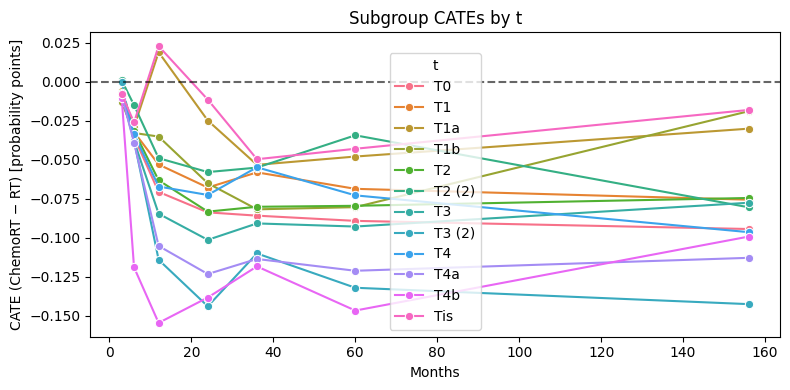

Saved outputs2/subgroups/CATE_subgroup_t.png


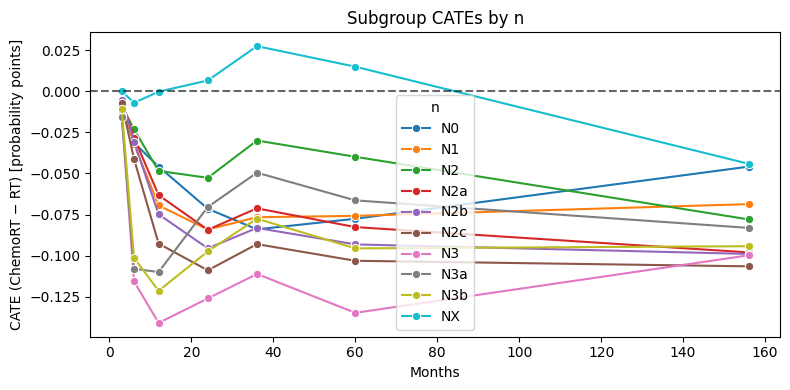

Saved outputs2/subgroups/CATE_subgroup_n.png


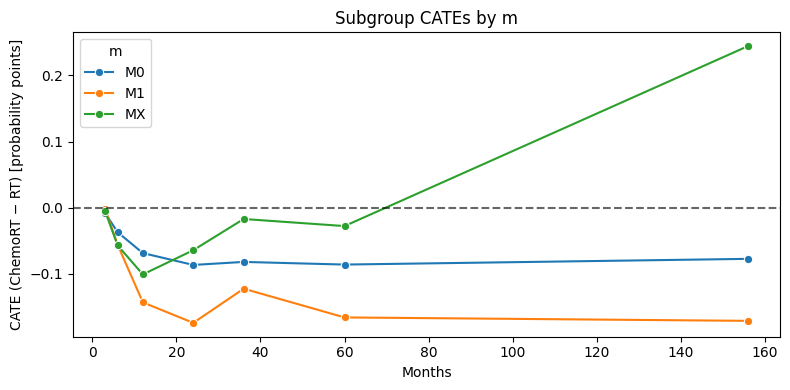

Saved outputs2/subgroups/CATE_subgroup_m.png


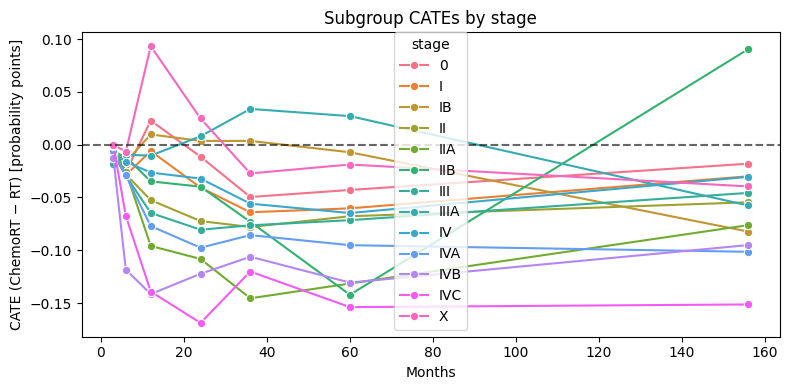

Saved outputs2/subgroups/CATE_subgroup_stage.png


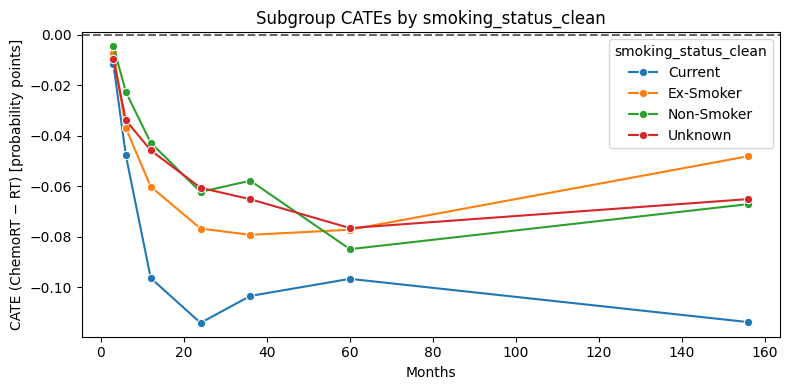

Saved outputs2/subgroups/CATE_subgroup_smoking_status_clean.png


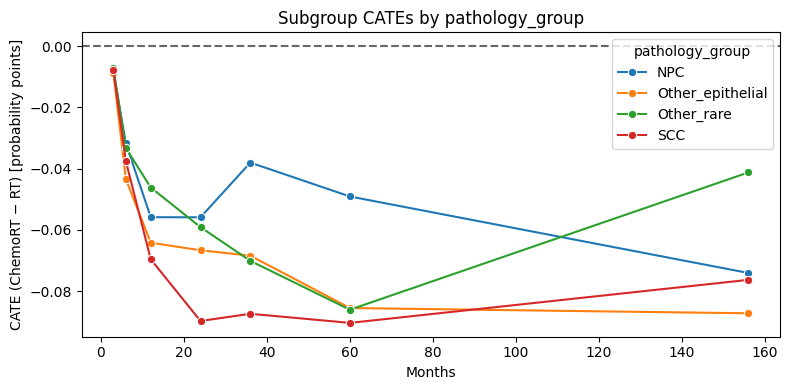

Saved outputs2/subgroups/CATE_subgroup_pathology_group.png


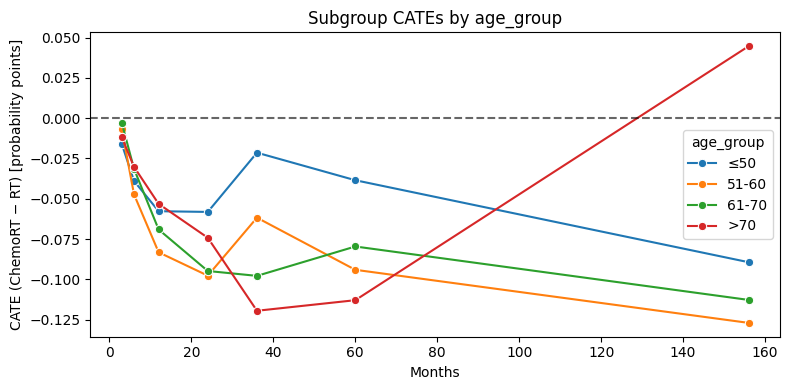

Saved outputs2/subgroups/CATE_subgroup_age_group.png


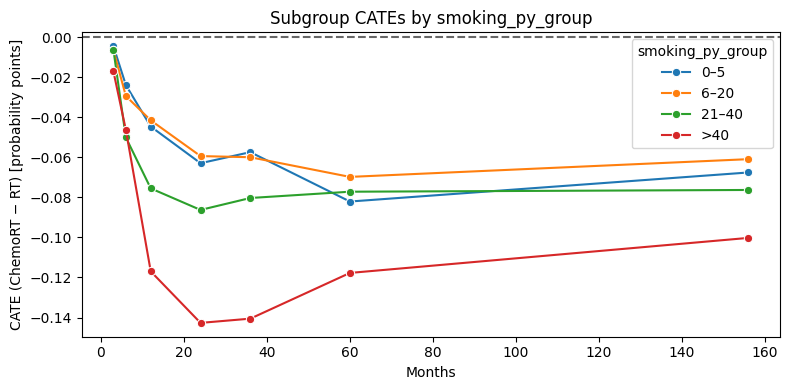

Saved outputs2/subgroups/CATE_subgroup_smoking_py_group.png


In [137]:
# create directory
os.makedirs("outputs2/subgroups", exist_ok=True)

# Subgroup CATE summaries & plots
group_vars = [
    'hpv_clean',
    'ecog_ps',
    'primary_site_group',
    't', 'n', 'm', 'stage',
    'smoking_status_clean',
    'pathology_group'
]

subgroup_vars = group_vars.copy()

# Age groups
if 'age' in train_patients.columns:
    train_patients['age_group'] = pd.cut(
        train_patients['age'],
        bins=[0, 50, 60, 70, 200],
        labels=['≤50','51-60','61-70','>70']
    )
    subgroup_vars.append('age_group')

# Smoking PY groups
if 'smoking_py_clean' in train_patients.columns:
    train_patients['smoking_py_group'] = pd.cut(
        train_patients['smoking_py_clean'],
        bins=[-0.1, 5, 20, 40, 500],
        labels=['0–5','6–20','21–40','>40']
    )
    subgroup_vars.append('smoking_py_group')

# Collect safe summaries
safe_summary_list = []
cate_cols = [c for c in train_patients.columns if c.startswith("CATE_")]

for g in subgroup_vars:
    if g not in train_patients.columns:
        continue
    if train_patients[g].nunique() < 2:
        continue

    tmp = train_patients.groupby(g)[cate_cols].mean().reset_index()
    tmp['group'] = g
    safe_summary_list.append(tmp)

if len(safe_summary_list) > 0:
    subgroup_summary = pd.concat(safe_summary_list, axis=0, ignore_index=True)
    subgroup_summary.to_csv("outputs2/subgroup_summary_cates.csv", index=False)
    print("Saved outputs2/subgroup_summary_cates.csv")
else:
    print("No subgroup summaries created (no valid grouping variables).")

# Plot subgroup trends for each variable
for g in subgroup_vars:
    if g not in train_patients.columns:
        continue

    df_g = subgroup_summary[subgroup_summary['group'] == g].copy()
    if df_g.empty:
        continue

    # reshape
    df_melt = df_g.melt(
        id_vars=[g, 'group'],
        value_vars=cate_cols,
        var_name='HORIZON',
        value_name='Mean_CATE'
    )

    df_melt['HORIZON'] = df_melt['HORIZON'].str.extract(r'CATE_(\d+)m').astype(float)
    df_melt = df_melt.sort_values('HORIZON')

    plt.figure(figsize=(8,4))
    sns.lineplot(data=df_melt, x='HORIZON', y='Mean_CATE', hue=g, marker='o')
    plt.axhline(0, color='k', ls='--', alpha=0.6)
    plt.xlabel('Months')
    plt.ylabel('CATE (ChemoRT − RT) [probability points]')
    plt.title(f"Subgroup CATEs by {g}")
    plt.tight_layout()

    out = f"outputs2/subgroups/CATE_subgroup_{g}.png"
    plt.savefig(out, dpi=150)
    plt.show()
    print("Saved", out)


In [138]:
# get and save patient columns

# Load the forest bundle you already saved
bundle_path = os.path.join(OUTDIR, "causal_forests_period_horizons_patient_level.joblib")
forests = joblib.load(bundle_path)
print("Keys in forests bundle:", list(forests.keys()))

# Pick one horizon and get its estimator
some_key = sorted(forests.keys())[0]
est = forests[some_key]

# unwrap if stored inside dict
if isinstance(est, dict):
    for v in est.values():
        if hasattr(v, "effect"):
            est = v
            break

# Extract the feature names used at training time
if hasattr(est, "feature_names_in_"):
    patient_columns = list(est.feature_names_in_)
else:
    # fallback to training matrix (must exist in workspace)
    patient_columns = list(Xtr_patient.columns)

print("n patient columns:", len(patient_columns))
print("First 10 cols:", patient_columns[:10])

# Save them for inference
pc_path = os.path.join(OUTDIR, "causal_patient_columns.joblib")
joblib.dump(patient_columns, pc_path)
print("Saved:", pc_path)


Keys in forests bundle: ['0-3', '4-6', '7-12', '13-24', '25-36', '37-60', '60+']
n patient columns: 31
First 10 cols: ['sex_Male', 'smoking_status_clean_Ex-Smoker', 'smoking_status_clean_Non-Smoker', 'smoking_status_clean_Unknown', 'primary_site_group_Nasopharynx', 'primary_site_group_Oropharynx', 'primary_site_group_Other_HNC', 'pathology_group_Other_epithelial', 'pathology_group_Other_rare', 'pathology_group_SCC']
Saved: outputs2/causal_patient_columns.joblib


# **RMST**

In [141]:

# compute per-patient RMST (treated vs control) for all patients
tau_months = 36
tau_days = tau_months * INTERVAL_DAYS   # use global INTERVAL_DAYS


# Load the correct artifacts
model_columns = pd.read_csv(os.path.join(OUTDIR, "pooled_logit_model_columns.csv"))['model_columns'].tolist()
scaler = joblib.load(os.path.join(OUTDIR, "pp_scaler.joblib"))
train_medians_pp = joblib.load(os.path.join(OUTDIR, "pp_train_medians.joblib"))
collapse_maps = joblib.load(os.path.join(OUTDIR, "pp_collapse_maps.joblib"))
logit = joblib.load(os.path.join(OUTDIR, "pooled_logit_logreg_saga_l2_tuned.joblib"))

# load required objects (fallbacks using OUTDIR)
if 'logit' not in globals():
    try:
        logit = joblib.load(os.path.join(OUTDIR, "pooled_logit_logreg_saga.joblib"))
        print(f"Loaded pooled-logit from {OUTDIR}/pooled_logit_logreg_saga.joblib")
    except Exception as e:
        raise RuntimeError(f"Could not load pooled-logit model 'logit'. Make sure {OUTDIR}/pooled_logit_logreg_saga.joblib exists.") from e

if 'model_columns' not in globals():
    mc_path = os.path.join(OUTDIR, "pooled_logit_model_columns.csv")
    if os.path.exists(mc_path):
        df_mc = pd.read_csv(mc_path)
        model_columns = df_mc.squeeze().tolist() if hasattr(df_mc, "squeeze") else df_mc['model_columns'].tolist()
        print("Loaded model_columns.")
    else:
        raise RuntimeError(f"model_columns not found in globals and file {OUTDIR}/pooled_logit_model_columns.csv missing.")

# build_X_for_pp exists or try to import the safe wrapper
if 'build_X_for_pp' not in globals():
    raise RuntimeError("build_X_for_pp function not found in namespace. Define it (or run earlier cell that creates build_X_for_pp_safe).")

# pp_train and pp_test exist (person-period tables)
if 'pp_train' not in globals() or 'pp_test' not in globals():
    raise RuntimeError("pp_train and pp_test must exist in workspace (person-period DataFrames).")


# function to compute per-patient RMST for a person-period dataframe
def compute_patient_rmst_from_pp(pp_df, logit_model, model_columns, tau_days, interval_days=INTERVAL_DAYS):
    patient_ids = pp_df[ID_COL].unique()
    out = []
    for pid in tqdm(patient_ids, desc="RMST patients"):
        rows_pp = pp_df[pp_df[ID_COL] == pid].sort_values('period')
        if rows_pp.shape[0] == 0:
            continue
        # determine period lengths
        if 'period_length' in rows_pp.columns:
            period_lengths = rows_pp['period_length'].fillna(interval_days).astype(int).tolist()
        elif ('period_start' in rows_pp.columns) and ('period_end' in rows_pp.columns):
            period_lengths = (rows_pp['period_end'] - rows_pp['period_start']).fillna(interval_days).astype(int).tolist()
        else:
            period_lengths = [interval_days] * rows_pp.shape[0]

        # build X for these rows
        Xrows = build_X_for_pp(rows_pp.copy())  # safe wrapper
        # to ensure columns match
        for c in model_columns:
            if c not in Xrows.columns:
                Xrows[c] = 0.0
        Xrows = Xrows[model_columns]

        # predict hazards under treated and control
        X_treated = Xrows.copy()
        X_treated[TREAT_COL] = 1
        for pcol in [c for c in Xrows.columns if str(c).startswith('period_bin')]:
            X_treated[f'treat_x_{pcol}'] = X_treated[TREAT_COL] * X_treated.get(pcol, 0)

        X_control = Xrows.copy()
        X_control[TREAT_COL] = 0
        for pcol in [c for c in Xrows.columns if str(c).startswith('period_bin')]:
            X_control[f'treat_x_{pcol}'] = X_control[TREAT_COL] * X_control.get(pcol, 0)

        # predict_proba (make sure model supports it)
        probs_t = logit_model.predict_proba(X_treated)[:,1]
        probs_c = logit_model.predict_proba(X_control)[:,1]

        # rmst calculation
        def rmst_from_period_hazards(hazards, period_lengths, tau_days):
            surv_prev = 1.0
            rmst = 0.0
            cum_days = 0
            for h, plen in zip(hazards, period_lengths):
                if cum_days >= tau_days:
                    break
                use_len = min(plen, tau_days - cum_days)
                rmst += surv_prev * use_len
                surv_prev = surv_prev * (1.0 - h)
                cum_days += plen
            return float(rmst)

        rmst_t = rmst_from_period_hazards(probs_t, period_lengths, tau_days)
        rmst_c = rmst_from_period_hazards(probs_c, period_lengths, tau_days)
        delta = rmst_t - rmst_c

        # mean period HR
        with np.errstate(divide='ignore', invalid='ignore'):
            hr_per_period = np.divide(probs_t, probs_c)
            hr_per_period[~np.isfinite(hr_per_period)] = np.nan
        avg_hr = np.nan
        if np.any(~np.isnan(hr_per_period)):
            mask = ~np.isnan(hr_per_period)
            avg_hr = np.average(hr_per_period[mask], weights=np.array(period_lengths)[mask])

        out.append({
            ID_COL: pid,
            'rmst_treated_days': rmst_t,
            'rmst_control_days': rmst_c,
            'delta_rmst_days': delta,
            'avg_hr_patient': avg_hr,
            'num_periods': rows_pp.shape[0]
        })
    return pd.DataFrame(out)


# compute for train and test (use their person-period tables)
df_rmst_train = compute_patient_rmst_from_pp(pp_train, logit, model_columns, tau_days, interval_days=INTERVAL_DAYS)
df_rmst_test  = compute_patient_rmst_from_pp(pp_test,  logit, model_columns, tau_days, interval_days=INTERVAL_DAYS)

df_rmst_all = pd.concat([df_rmst_train, df_rmst_test], ignore_index=True)
out_path = os.path.join(OUTDIR, "cf_vs_logit_rmst_36m_per_patient_fixed_all.csv")
df_rmst_all.to_csv(out_path, index=False)
print("Saved recomputed RMSTs to:", out_path)
print("Train RMST rows:", df_rmst_train.shape[0], "Test RMST rows:", df_rmst_test.shape[0])

#Merge onto patient-level train/test and run CF
train_pat = train_patients.merge(df_rmst_all[[ID_COL,'delta_rmst_days']], on=ID_COL, how='left').dropna(subset=['delta_rmst_days']).reset_index(drop=True)
test_pat  = test_patients.merge(df_rmst_all[[ID_COL,'delta_rmst_days']], on=ID_COL, how='left').dropna(subset=['delta_rmst_days']).reset_index(drop=True)

print("After merge: train_pat rows:", train_pat.shape[0], "test_pat rows:", test_pat.shape[0])

if train_pat.shape[0] < 10:
    print("WARNING: very few train patients with RMST. CF training may be unstable. Consider increasing train size or using cross-fitting.")
else:
    # build X matrices (baseline)
    baseline_cat = [c for c in ['sex','smoking_status_clean','primary_site_group','pathology_group','hpv_clean'] if c in train_pat.columns]
    baseline_num = [c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in train_pat.columns]

    Xtr_cat = pd.get_dummies(train_pat[baseline_cat].fillna('Missing').astype(str), drop_first=True)
    Xte_cat = pd.get_dummies(test_pat[baseline_cat].fillna('Missing').astype(str), drop_first=True)
    Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0)
    Xtr_num = train_pat[baseline_num].fillna(train_pat[baseline_num].median()) if baseline_num else pd.DataFrame(index=train_pat.index)
    Xte_num = test_pat[baseline_num].fillna(train_pat[baseline_num].median()) if baseline_num else pd.DataFrame(index=test_pat.index)

    Xtr = pd.concat([Xtr_cat.reset_index(drop=True), Xtr_num.reset_index(drop=True)], axis=1).fillna(0)
    Xte = pd.concat([Xte_cat.reset_index(drop=True), Xte_num.reset_index(drop=True)], axis=1).fillna(0)

    Ytr = train_pat['delta_rmst_days'].astype(float).values
    Wtr = train_pat[TREAT_COL].astype(int).values
    sw_col = 'sw_trunc_logit_simple' if 'sw_trunc_logit_simple' in train_pat.columns else ('sw_trunc' if 'sw_trunc' in train_pat.columns else None)
    if sw_col:
        sw_tr = train_pat[sw_col].fillna(1.0).values
    else:
        sw_tr = np.ones(len(Ytr))
    sw_tr = np.clip(sw_tr, 1e-3, 10.0)

    # Fit CF on RMST pseudo-values (patient-level)
    cf = CausalForestDML(
        model_y = RandomForestRegressor(n_estimators=200, min_samples_leaf=8, random_state=42),
        model_t = RandomForestRegressor(n_estimators=200, min_samples_leaf=8, random_state=42),
        discrete_treatment=True,
        n_estimators=1000,
        min_samples_leaf=5,
        random_state=42,
        verbose=0
    )
    print("Fitting CausalForest on recomputed patient RMSTs...")
    cf.fit(Ytr, Wtr, X=Xtr.values, sample_weight=sw_tr)

    # predictions
    cate_tr = np.asarray(cf.effect(Xtr.values)).flatten()
    cate_te = np.asarray(cf.effect(Xte.values)).flatten()
    train_pat['CATE_rmst_36m_days'] = cate_tr
    test_pat['CATE_rmst_36m_days'] = cate_te
    train_pat['CATE_rmst_36m_months'] = train_pat['CATE_rmst_36m_days']/30.0
    test_pat['CATE_rmst_36m_months'] = test_pat['CATE_rmst_36m_days']/30.0

    # save results (use OUTDIR)
    joblib.dump(cf, os.path.join(OUTDIR, "cf_rmst_36m_patient_level.joblib"))
    train_pat.to_csv(os.path.join(OUTDIR, "train_patients_with_rmst_cates.csv"), index=False)
    test_pat.to_csv(os.path.join(OUTDIR, "test_patients_with_rmst_cates.csv"), index=False)
    print("Saved CF results; train/test patient files updated.")


RMST patients:   0%|          | 0/2453 [00:00<?, ?it/s]

RMST patients:   0%|          | 0/818 [00:00<?, ?it/s]

Saved recomputed RMSTs to: outputs2/cf_vs_logit_rmst_36m_per_patient_fixed_all.csv
Train RMST rows: 2453 Test RMST rows: 818
After merge: train_pat rows: 2453 test_pat rows: 818
Fitting CausalForest on recomputed patient RMSTs...
Saved CF results; train/test patient files updated.


In [142]:
#build design matrix for person-period data using
def build_X_for_pp_safe(df_pp):
    """
    Safe wrapper to build design matrix for person-period data using:
    - collapse_maps
    - PERIOD_BINS / PERIOD_LABELS
    - CAT_COLS / NUM_COLS
    - train_medians_pp
    - scaler
    - model_columns
    """
    df = df_pp.copy()

    # Apply collapse maps (from globals)
    if collapse_maps:
        for c, keep in collapse_maps.items():
            if c in df.columns:
                df[c] = df[c].astype(str).where(df[c].astype(str).isin(keep), 'Other')

    # Ensure period_month and period_bin exist
    if 'period_month' not in df.columns:
        if 'period' in df.columns:
            df['period_month'] = df['period'].astype(int)
        else:
            df['period_month'] = 1

    if 'period_bin' not in df.columns:
        df['period_bin'] = pd.cut(
            df['period_month'],
            bins=PERIOD_BINS,
            labels=PERIOD_LABELS,
            right=True
        )

    # Categorical features: intersect CAT_COLS with df
    cat_cols_local = [c for c in CAT_COLS if c in df.columns]
    if cat_cols_local:
        Xc = pd.get_dummies(df[cat_cols_local].astype(str), drop_first=True)
    else:
        Xc = pd.DataFrame(index=df.index)

    # Numeric features: intersect NUM_COLS with df
    num_cols_local = [c for c in NUM_COLS if c in df.columns]
    if num_cols_local:
        Xn = df[num_cols_local].copy()
        for c in Xn.columns:
            Xn[c] = pd.to_numeric(Xn[c], errors='coerce')
        # Fill with train medians from global object
        if train_medians_pp is not None:
            Xn = Xn.fillna(train_medians_pp)
        else:
            Xn = Xn.fillna(Xn.median())
        # Scale using global scaler if available
        if scaler is not None:
            Xn_scaled = pd.DataFrame(
                scaler.transform(Xn),
                columns=Xn.columns,
                index=Xn.index
            )
        else:
            Xn_scaled = Xn
    else:
        Xn_scaled = pd.DataFrame(index=df.index)

    # Combine
    Xnew = pd.concat(
        [Xc.reset_index(drop=True), Xn_scaled.reset_index(drop=True)],
        axis=1
    )

    # Add treatment column if present
    if TREAT_COL in df.columns:
        Xnew[TREAT_COL] = pd.to_numeric(df[TREAT_COL], errors='coerce').fillna(0).astype(int).values
    else:
        Xnew[TREAT_COL] = 0

    # Add treatment × period_bin interactions
    period_dummy_cols_local = [c for c in Xnew.columns if str(c).startswith('period_bin')]
    for pcol in period_dummy_cols_local:
        Xnew[f'treat_x_{pcol}'] = Xnew[TREAT_COL] * Xnew[pcol]

    # Align to model_columns if available
    if model_columns is not None:
        Xnew = Xnew.reindex(columns=model_columns, fill_value=0.0)

    return Xnew

# Replace the global build_X_for_pp with this safe wrapper
build_X_for_pp = build_X_for_pp_safe


# Recompute RMST per patient from pooled-logit counterfactuals

if 'pp_test' not in globals():
    raise RuntimeError("pp_test not found in workspace. Please ensure person-period test DataFrame is available as pp_test.")

if logit is None:
    raise RuntimeError("logit model not found. Please load your pooled-logit model into variable 'logit'.")

if model_columns is None:
    raise RuntimeError("model_columns not found. Please load them from OUTDIR first.")


interval_days = INTERVAL_DAYS
patient_ids = test_patients[ID_COL].unique()
rows = []

for pid in tqdm(patient_ids, desc="Compute ΔRMST per patient (fixed)"):
    rows_pp = pp_test[pp_test[ID_COL] == pid].sort_values('period')
    if rows_pp.shape[0] == 0:
        continue

    # Period lengths
    if 'period_length' in rows_pp.columns:
        period_lengths = rows_pp['period_length'].fillna(interval_days).astype(int).tolist()
    elif ('period_start' in rows_pp.columns) and ('period_end' in rows_pp.columns):
        period_lengths = (rows_pp['period_end'] - rows_pp['period_start']).fillna(interval_days).astype(int).tolist()
    else:
        period_lengths = [interval_days] * rows_pp.shape[0]

    # Design matrix
    Xrows = build_X_for_pp(rows_pp)

    # Ensure columns match
    missing = set(model_columns) - set(Xrows.columns)
    for c in missing:
        Xrows[c] = 0.0
    Xrows = Xrows[model_columns]

    # Predict under treated
    X_treated = Xrows.copy()
    X_treated[TREAT_COL] = 1
    for pcol in [c for c in Xrows.columns if c.startswith('period_bin')]:
        X_treated[f'treat_x_{pcol}'] = X_treated[TREAT_COL] * X_treated.get(pcol, 0)

    # Predict under control
    X_control = Xrows.copy()
    X_control[TREAT_COL] = 0
    for pcol in [c for c in Xrows.columns if c.startswith('period_bin')]:
        X_control[f'treat_x_{pcol}'] = X_control[TREAT_COL] * X_control.get(pcol, 0)

    probs_treated = logit.predict_proba(X_treated)[:, 1]
    probs_control = logit.predict_proba(X_control)[:, 1]

    # RMST from interval hazards
    def rmst_from_period_hazards(hazards, period_lengths, tau_days):
        surv_prev = 1.0
        rmst = 0.0
        cum_days = 0
        for h, plen in zip(hazards, period_lengths):
            if cum_days >= tau_days:
                break
            use_len = min(plen, tau_days - cum_days)
            rmst += surv_prev * use_len
            surv_prev = surv_prev * (1.0 - h)
            cum_days += plen
        return float(rmst)

    rmst_tr = rmst_from_period_hazards(probs_treated, period_lengths, tau_days)
    rmst_ct = rmst_from_period_hazards(probs_control, period_lengths, tau_days)
    delta = rmst_tr - rmst_ct

    # Average per-patient HR
    with np.errstate(divide='ignore', invalid='ignore'):
        hr_per_period = np.divide(probs_treated, probs_control)
        hr_per_period[~np.isfinite(hr_per_period)] = np.nan
    if np.all(np.isnan(hr_per_period)):
        avg_hr = np.nan
    else:
        mask = ~np.isnan(hr_per_period)
        avg_hr = np.average(hr_per_period[mask], weights=np.array(period_lengths)[mask])

    rows.append({
        ID_COL: pid,
        'rmst_treated_days': rmst_tr,
        'rmst_control_days': rmst_ct,
        'delta_rmst_days': delta,
        'avg_hr_patient': avg_hr,
        'num_periods': rows_pp.shape[0]
    })

df_rmst = pd.DataFrame(rows)
out_path = os.path.join(OUTDIR, "cf_vs_logit_rmst_36m_per_patient_fixed.csv")
df_rmst.to_csv(out_path, index=False)
print("Saved fixed per-patient RMST comparisons to:", out_path)
print("Sample rows:")
print(df_rmst.head())


Compute ΔRMST per patient (fixed):   0%|          | 0/818 [00:00<?, ?it/s]

Saved fixed per-patient RMST comparisons to: outputs2/cf_vs_logit_rmst_36m_per_patient_fixed.csv
Sample rows:
     patient_id  rmst_treated_days  rmst_control_days  delta_rmst_days  \
0  RADCURE-0006         448.965766         379.325679        69.640087   
1  RADCURE-0010         978.244585         893.648024        84.596561   
2  RADCURE-0014         541.970852         491.727655        50.243197   
3  RADCURE-0021         954.327062         853.287016       101.040046   
4  RADCURE-0027         956.459522         856.833359        99.626163   

   avg_hr_patient  num_periods  
0        0.516580           18  
1        0.438213          115  
2        0.508998           20  
3        0.529476           50  
4        0.480714           77  


N patients: 818
CF CATE months: mean -0.003 sd 0.002
Logit ΔRMST months: mean 2.476 sd 1.459
ATE CF (months): -0.003 (-0.003, -0.003)
ATE Logit ΔRMST (months): 2.476 (2.371, 2.578)


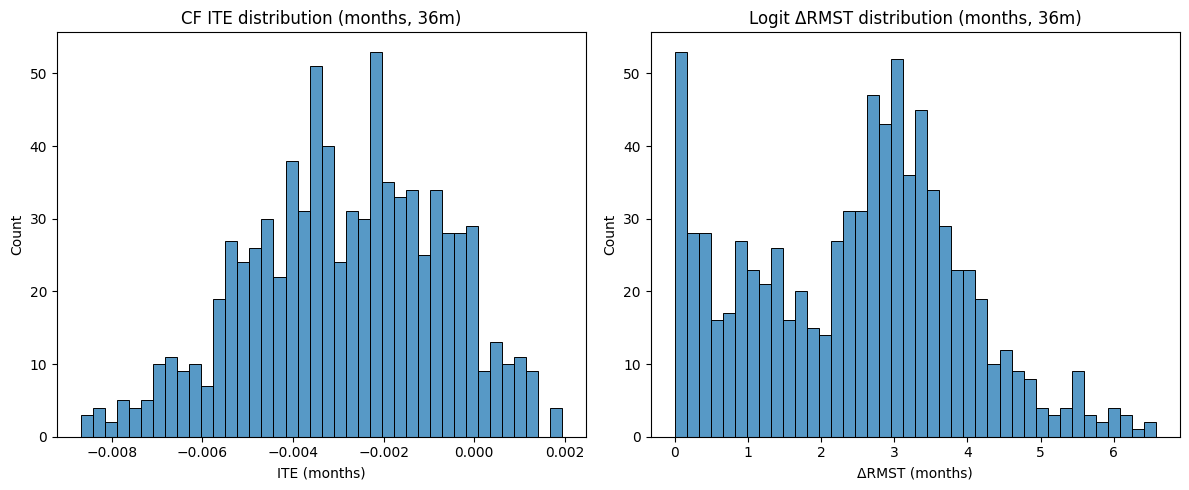

Pearson r between CF ITE and logit ΔRMST: r=-0.141 p=5.239e-05


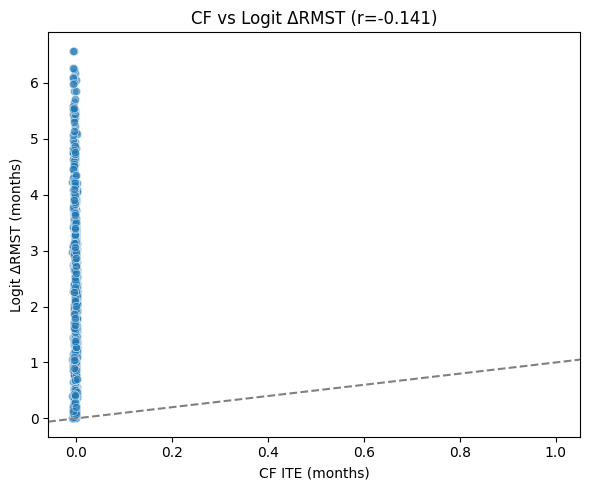

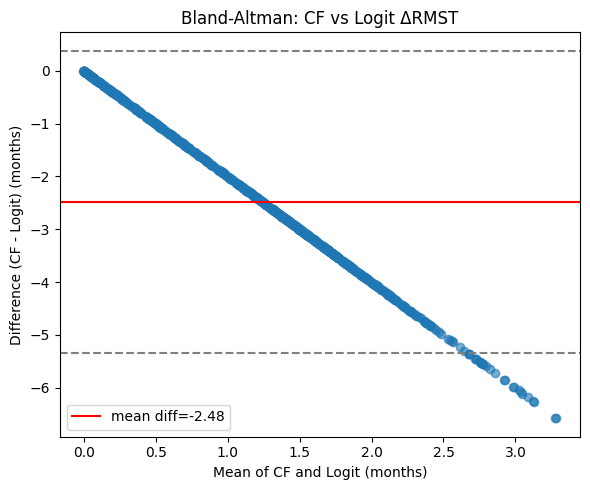

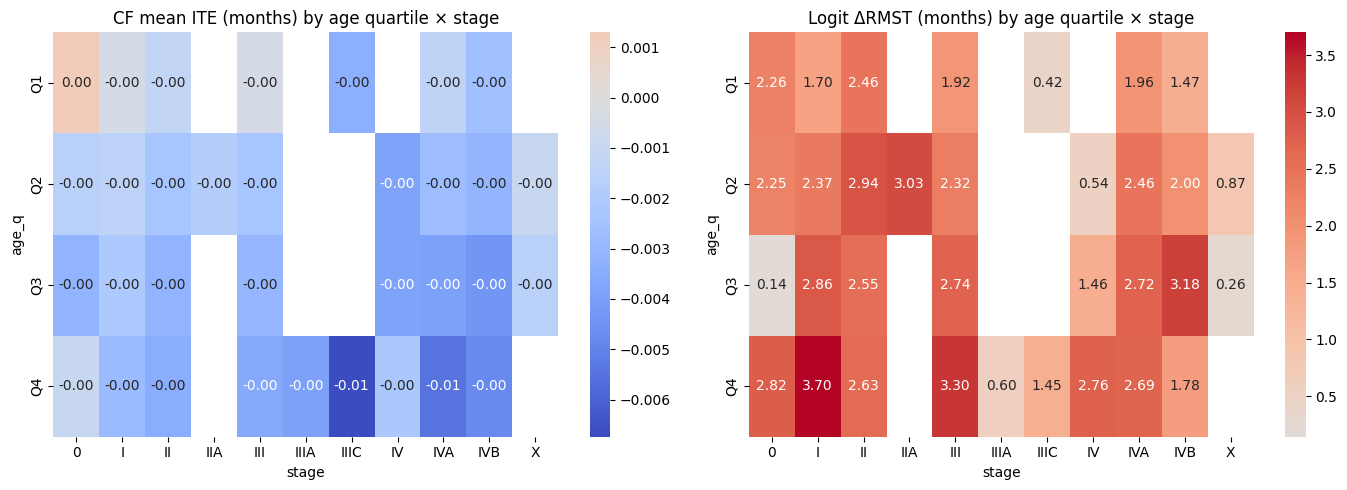

Saved subgroup summary to outputs2/subgroup_summary_cf_vs_logit.csv


group_col         group    n   cf_mean     cf_lo     cf_up  \
0              hpv_clean  HPV_Negative   87 -0.004538 -0.004980 -0.004093   
1              hpv_clean  HPV_Positive  242 -0.002392 -0.002585 -0.002202   
2              hpv_clean   HPV_Unknown   37 -0.003311 -0.004055 -0.002608   
3                  stage             I   92 -0.001944 -0.002361 -0.001537   
4                  stage           IVB   78 -0.003340 -0.003712 -0.002996   
5                  stage           IVA  376 -0.003195 -0.003421 -0.002974   
6                  stage           III  159 -0.002475 -0.002796 -0.002149   
7                  stage            II   87 -0.002821 -0.003281 -0.002391   
8   smoking_status_clean     Ex-Smoker  307 -0.002879 -0.003128 -0.002644   
9   smoking_status_clean    Non-Smoker  209 -0.001863 -0.002114 -0.001624   
10  smoking_status_clean       Current  293 -0.003587 -0.003829 -0.003356   

    log_mean    log_lo    log_up  
0   2.248217  1.870245  2.607065  
1   2.503050  2.344514  2.658177  
2   2.906676  2.483889  3.353106  
3   2.826887  2.550942  3.109728  
4   1.987327  1.644750  2.347901  
5   2.431301  2.291992  2.570662  
6   2.638851  2.406073  2.862711  
7   2.656060  2.335497  2.963447  
8   2.710119  2.537531  2.884537  
9   2.442782  2.309734  2.594678  
10  2.268766  2.088149  2.452394

Saved top/bottom lists to outputs2


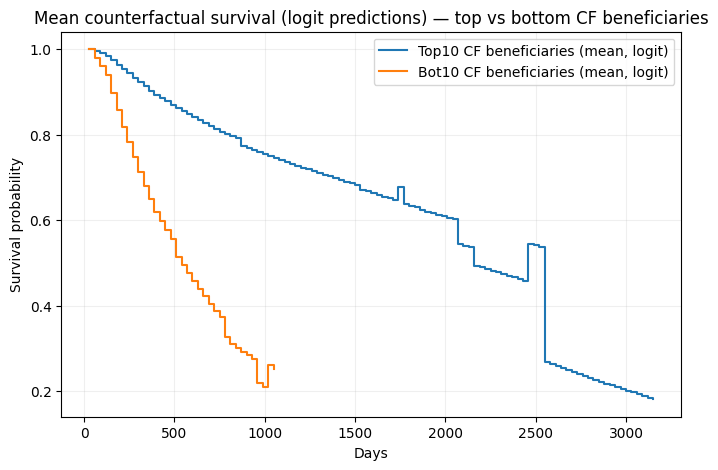

Saved merged final df to outputs2/cf_logit_rmst_36m_merged_final.csv


In [143]:
# random state
rng = np.random.RandomState(42)

# Load the ΔRMST per patient
df_rmst = pd.read_csv(os.path.join(OUTDIR, "cf_vs_logit_rmst_36m_per_patient_fixed.csv"))

# Load test_patients
if 'test_patients' not in globals():
    # try to find a saved CSV
    test_pat_path = os.path.join(OUTDIR, "test_patients_with_period_cates.csv")
    if os.path.exists(test_pat_path):
        test_patients = pd.read_csv(test_pat_path)
    else:
        raise RuntimeError(f"test_patients not found in workspace or {test_pat_path}; please load it into variable test_patients.")

# Merge: find CF CATE column
df = test_patients.merge(df_rmst, on=ID_COL, how='left')

# Find a CATE column --> 'CATE_36m'
possible_cates = [c for c in df.columns if c.startswith('CATE_')]
if 'CATE_36m' in df.columns:
    cf_col = 'CATE_36m'
elif len(possible_cates) > 0:
    cf_col = possible_cates[0]
else:
    raise RuntimeError("No CATE column (CATE_*) in test_patients. Please ensure causal forest results were saved to test_patients.")

# Create unified columns in months
df['cf_cate_days'] = df[cf_col].astype(float)
df['cf_cate_months'] = df['cf_cate_days'] / INTERVAL_DAYS
df['delta_rmst_days'] = df['delta_rmst_days'].astype(float)
df['delta_rmst_months'] = df['delta_rmst_days'] / INTERVAL_DAYS

# sample weight selection
if 'sample_w_36m' in df.columns:
    df['w_use'] = df['sample_w_36m'].fillna(1.0)
elif 'sw_trunc' in df.columns:
    df['w_use'] = df['sw_trunc'].fillna(1.0)
else:
    df['w_use'] = 1.0

# basic stats
print("N patients:", df.shape[0])
print("CF CATE months: mean {:.3f} sd {:.3f}".format(df['cf_cate_months'].mean(), df['cf_cate_months'].std()))
print("Logit ΔRMST months: mean {:.3f} sd {:.3f}".format(df['delta_rmst_months'].mean(), df['delta_rmst_months'].std()))


# Weighted ATE and bootstrap CI
def weighted_mean_bootstrap(values, weights=None, n_boot=2000):
    # returns mean and (2.5,97.5) percentile CI
    values = np.asarray(values)
    if weights is None:
        weights = np.ones(len(values))
    weights = np.asarray(weights)
    # weighted mean
    mean = np.average(values, weights=weights)
    # bootstrap by resampling indices with replacement
    n = len(values)
    rng = np.random.RandomState(0)
    boots = []
    for _ in range(n_boot):
        idx = rng.choice(n, n, replace=True)
        boots.append(np.average(values[idx], weights=weights[idx]))
    lower = np.percentile(boots, 2.5)
    upper = np.percentile(boots, 97.5)
    return mean, lower, upper

ate_cf, lo_cf, up_cf = weighted_mean_bootstrap(df['cf_cate_months'].fillna(0).values, df['w_use'].values)
ate_log, lo_log, up_log = weighted_mean_bootstrap(df['delta_rmst_months'].fillna(0).values, df['w_use'].values)
print(f"ATE CF (months): {ate_cf:.3f} ({lo_cf:.3f}, {up_cf:.3f})")
print(f"ATE Logit ΔRMST (months): {ate_log:.3f} ({lo_log:.3f}, {up_log:.3f})")

# -----------------------------
# Distribution plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['cf_cate_months'].dropna(), bins=40, kde=False)
plt.title('CF ITE distribution (months, 36m)')
plt.xlabel('ITE (months)')
plt.subplot(1,2,2)
sns.histplot(df['delta_rmst_months'].dropna(), bins=40, kde=False)
plt.title('Logit ΔRMST distribution (months, 36m)')
plt.xlabel('ΔRMST (months)')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "distributions_cf_vs_logit.png"), dpi=150)
plt.show()

# -----------------------------
# Scatter + correlation and Bland-Altman
x = df['cf_cate_months'].fillna(0).values
y = df['delta_rmst_months'].fillna(0).values
r, p = st.pearsonr(x, y)
print(f"Pearson r between CF ITE and logit ΔRMST: r={r:.3f} p={p:.3e}")

plt.figure(figsize=(6,5))
sns.scatterplot(x=x, y=y, alpha=0.6)
plt.xlabel('CF ITE (months)')
plt.ylabel('Logit ΔRMST (months)')
plt.title(f'CF vs Logit ΔRMST (r={r:.3f})')
plt.axline((0,0), (1,1), color='gray', linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "scatter_cf_vs_logit.png"), dpi=150)
plt.show()

# Bland-Altman: diff vs mean
diff = x - y
mean_xy = 0.5 * (x + y)
md = np.mean(diff)
sd = np.std(diff)
plt.figure(figsize=(6,5))
plt.scatter(mean_xy, diff, alpha=0.6)
plt.axhline(md, color='red', label=f'mean diff={md:.2f}')
plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
plt.xlabel('Mean of CF and Logit (months)')
plt.ylabel('Difference (CF - Logit) (months)')
plt.title('Bland-Altman: CF vs Logit ΔRMST')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "bland_altman_cf_vs_logit.png"), dpi=150)
plt.show()


# Heatmaps age-quantile x stage for both metrics
if 'age' in df.columns and 'stage' in df.columns:
    df['age_q'] = pd.qcut(df['age'].fillna(df['age'].median()), q=4, labels=['Q1','Q2','Q3','Q4'])
    heat_cf = df.groupby(['age_q','stage'])['cf_cate_months'].mean().unstack()
    heat_log = df.groupby(['age_q','stage'])['delta_rmst_months'].mean().unstack()

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    sns.heatmap(heat_cf, annot=True, fmt='.2f', center=0, cmap='coolwarm')
    plt.title('CF mean ITE (months) by age quartile × stage')
    plt.subplot(1,2,2)
    sns.heatmap(heat_log, annot=True, fmt='.2f', center=0, cmap='coolwarm')
    plt.title('Logit ΔRMST (months) by age quartile × stage')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "heatmaps_age_stage_cf_vs_logit.png"), dpi=150)
    plt.show()

# Subgroup summaries: hpv_clean, stage, smoking_status_clean
subgroups = []
if 'hpv_clean' in df.columns:
    subgroups.append(('hpv_clean', df['hpv_clean'].unique()))
if 'stage' in df.columns:
    subgroups.append(('stage', df['stage'].unique()))
if 'smoking_status_clean' in df.columns:
    subgroups.append(('smoking_status_clean', df['smoking_status_clean'].unique()))

sub_summary = []
for col, vals in subgroups:
    for v in vals:
        mask = df[col] == v
        if mask.sum() < 10:
            continue
        mean_cf, lo_cf, up_cf = weighted_mean_bootstrap(
            df.loc[mask, 'cf_cate_months'].fillna(0).values,
            df.loc[mask, 'w_use'].values
        )
        mean_log, lo_log, up_log = weighted_mean_bootstrap(
            df.loc[mask, 'delta_rmst_months'].fillna(0).values,
            df.loc[mask, 'w_use'].values
        )
        sub_summary.append({
            'group_col': col,
            'group': v,
            'n': int(mask.sum()),
            'cf_mean': mean_cf,
            'cf_lo': lo_cf,
            'cf_up': up_cf,
            'log_mean': mean_log,
            'log_lo': lo_log,
            'log_up': up_log
        })

sub_df = pd.DataFrame(sub_summary)
sub_df.to_csv(os.path.join(OUTDIR, "subgroup_summary_cf_vs_logit.csv"), index=False)
print(f"Saved subgroup summary to {OUTDIR}/subgroup_summary_cf_vs_logit.csv")
display(sub_df.head(20))


#  beneficiaries and counterfactual survival curves
# Show top 5 CF beneficiaries and their pooled-logit ΔRMST
topk = df.sort_values('cf_cate_days', ascending=False).head(10)
botk = df.sort_values('cf_cate_days', ascending=True).head(10)
topk[[ID_COL,'cf_cate_months','delta_rmst_months']].to_csv(os.path.join(OUTDIR, "top10_cf_beneficiaries.csv"), index=False)
botk[[ID_COL,'cf_cate_months','delta_rmst_months']].to_csv(os.path.join(OUTDIR, "bot10_cf_beneficiaries.csv"), index=False)
print("Saved top/bottom lists to", OUTDIR)

# If pp_test & predict_survival_from_pp exist, plot mean survival for top vs bottom groups using logit counterfactuals
if 'pp_test' in globals() and 'predict_survival_from_pp' in globals():
    def mean_counterfactual_survival(patient_ids):
        # returns DataFrame: period, mean_survival_treated, mean_survival_control
        pats = pp_test[pp_test[ID_COL].isin(patient_ids)].copy()
        # predict per-patient survival using predict_survival_from_pp
        survs = predict_survival_from_pp(pats, patient_ids=patient_ids)
        # average survival by period across patients (unweighted)
        mean_surv = survs.groupby('period')['survival_at_period_end'].mean().reset_index()
        return mean_surv

    top_ids = topk[ID_COL].tolist()
    bot_ids = botk[ID_COL].tolist()
    top_surv = mean_counterfactual_survival(top_ids)
    bot_surv = mean_counterfactual_survival(bot_ids)

    plt.figure(figsize=(8,5))
    days_top = top_surv['period'] * INTERVAL_DAYS
    days_bot = bot_surv['period'] * INTERVAL_DAYS
    plt.step(days_top, np.concatenate(([1.0], top_surv['survival_at_period_end'].values[:-1])),
             where='post', label='Top10 CF beneficiaries (mean, logit)')
    plt.step(days_bot, np.concatenate(([1.0], bot_surv['survival_at_period_end'].values[:-1])),
             where='post', label='Bot10 CF beneficiaries (mean, logit)')
    plt.xlabel('Days')
    plt.ylabel('Survival probability')
    plt.title('Mean counterfactual survival (logit predictions) — top vs bottom CF beneficiaries')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.savefig(os.path.join(OUTDIR, "top_bottom_cf_survival_logit.png"), dpi=150)
    plt.show()

# Save merged DF
df.to_csv(os.path.join(OUTDIR, "cf_logit_rmst_36m_merged_final.csv"), index=False)
print(f"Saved merged final df to {OUTDIR}/cf_logit_rmst_36m_merged_final.csv")


N patients with ΔRMST: 818
Train / hold sizes: (654, 22) (164, 22)
CV R^2 (train): -0.033678107214720664 std: 0.04405216145966706
Holdout RMSE (months, weighted): 1.476
Saved RF model and columns.


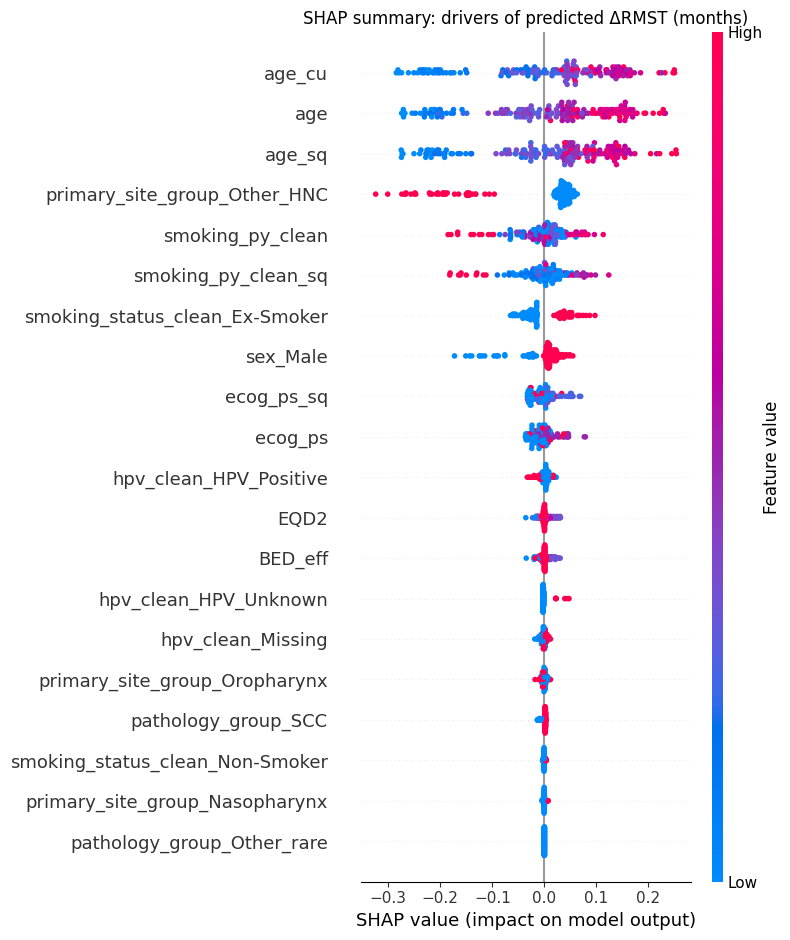

Saved SHAP summary plot.


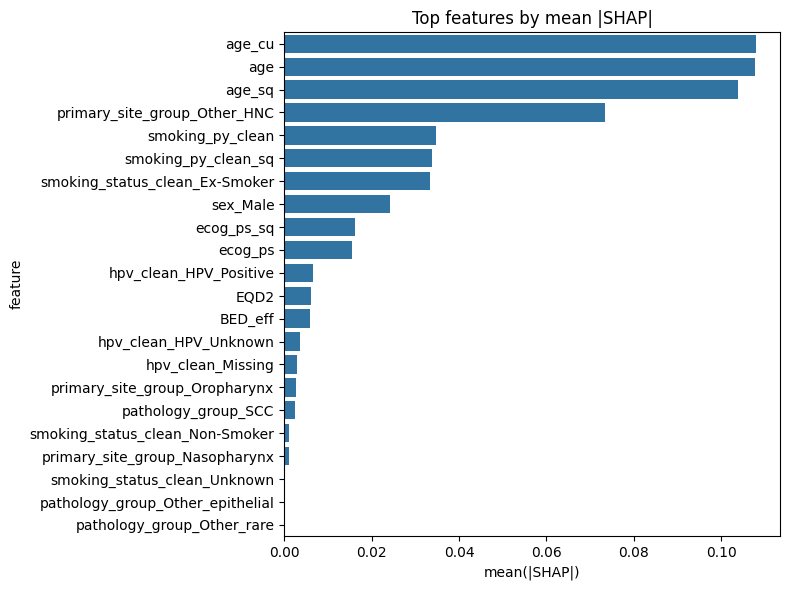

Saved SHAP topbar plot.


<Figure size 600x400 with 0 Axes>

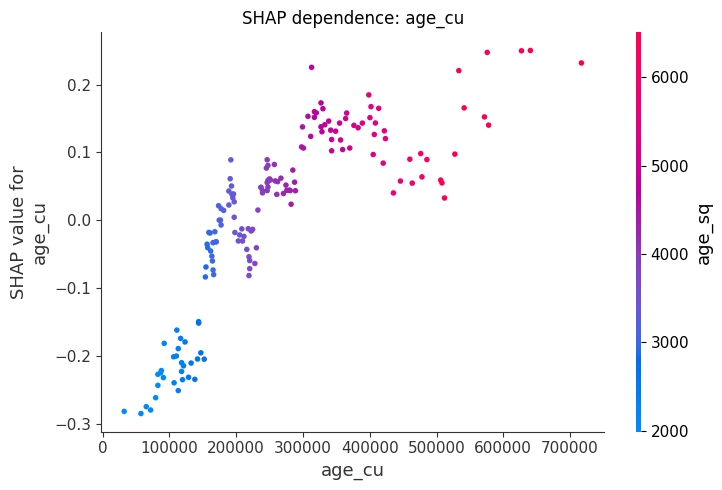

Saved SHAP dependence for age_cu
Saved SHAP objects.
- Model predicts ΔRMST (months). Positive = treated yields MORE RMST (benefit).
- SHAP summary plot saved -> top features driving predicted ΔRMST are: ['age_cu', 'age', 'age_sq', 'primary_site_group_Other_HNC', 'smoking_py_clean', 'smoking_py_clean_sq', 'smoking_status_clean_Ex-Smoker', 'sex_Male', 'ecog_ps_sq', 'ecog_ps']
- For any patient, the SHAP contribution (in months) shows how much that feature shifts the baseline prediction.


In [144]:
# SHAP- RMST
# random seed
rng_seed = 42

# load ΔRMST and patient table
rmst_path = os.path.join(OUTDIR, "cf_vs_logit_rmst_36m_per_patient_fixed.csv")
if not os.path.exists(rmst_path):
    raise RuntimeError(f"{rmst_path} not found. Run RMST computation first.")

df_rmst = pd.read_csv(rmst_path)

# Load patient-level features
if 'test_patients' not in globals():
    # try load from OUTDIR
    tp_path = os.path.join(OUTDIR, "test_patients_with_period_cates.csv")
    if os.path.exists(tp_path):
        test_patients = pd.read_csv(tp_path)
    else:
        raise RuntimeError(f"test_patients not found in globals or {tp_path}; load it into variable test_patients.")

df = test_patients.merge(df_rmst, on=ID_COL, how='left')

# drop patients with missing delta_rmst_days
df = df.dropna(subset=['delta_rmst_days']).reset_index(drop=True)
print("N patients with ΔRMST:", df.shape[0])

# Build feature matrix X and target y
baseline_cat = [c for c in ['sex','smoking_status_clean','primary_site_group','pathology_group','hpv_clean'] if c in df.columns]
baseline_num = [c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in df.columns]

# Create dummies for categorical
X_cat = pd.get_dummies(df[baseline_cat].fillna('Missing').astype(str), drop_first=True)

# Numeric: coerce and fill with train medians (or df median)
X_num = df[baseline_num].copy()
for c in X_num.columns:
    X_num[c] = pd.to_numeric(X_num[c], errors='coerce')
num_fill = X_num.median()
X_num = X_num.fillna(num_fill)

# add quadratic terms
for c in ['age','ecog_ps','smoking_py_clean']:
    if c in X_num.columns:
        X_num[f"{c}_sq"] = X_num[c]**2

# add cubic term for age
if 'age' in X_num.columns:
    X_num['age_cu'] = X_num['age']**3

# Combine
X = pd.concat([X_cat.reset_index(drop=True), X_num.reset_index(drop=True)], axis=1).fillna(0)

# Target
y_days = df['delta_rmst_days'].astype(float).values
y_months = y_days / INTERVAL_DAYS
y = y_months

# sample weights
if 'sample_w_36m' in df.columns:
    sample_w = df['sample_w_36m'].fillna(1.0).astype(float).values
elif 'sw_trunc' in df.columns:
    sample_w = df['sw_trunc'].fillna(1.0).astype(float).values
elif 'sw' in df.columns:
    sample_w = df['sw'].fillna(1.0).astype(float).values
else:
    sample_w = np.ones(len(df))

# Train/test split
X_train, X_hold, y_train, y_hold, w_train, w_hold = train_test_split(
    X, y, sample_w, test_size=0.2, random_state=rng_seed
)
print("Train / hold sizes:", X_train.shape, X_hold.shape)

# Fit a tree model --> RandomForest
rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=6,
    min_samples_leaf=10,
    random_state=rng_seed,
    n_jobs=-1
)
rf.fit(X_train, y_train, sample_weight=w_train)

# quick CV score (weighted by sample weights)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print("CV R^2 (train):", cv_scores.mean(), "std:", cv_scores.std())

# Evaluate holdout
y_pred = rf.predict(X_hold)
rmse = np.sqrt(np.average((y_hold - y_pred)**2, weights=w_hold))
print(f"Holdout RMSE (months, weighted): {rmse:.3f}")

# Save model and columns
joblib.dump(rf, os.path.join(OUTDIR, "rf_delta_rmst_36m.joblib"))
pd.Series(X.columns, name='model_columns').to_csv(
    os.path.join(OUTDIR, "rf_delta_model_columns.csv"), index=False
)
print("Saved RF model and columns.")

# SHAP explanation
explainer = shap.TreeExplainer(rf, feature_perturbation="tree_path_dependent")

# compute shap values on holdout (or on a subsample)
X_explain = X_hold if X_hold.shape[0] <= 5000 else X_hold.sample(3000, random_state=rng_seed)
shap_values = explainer.shap_values(X_explain)

# summary plot (save)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_explain, show=False)
plt.title("SHAP summary: drivers of predicted ΔRMST (months)")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "shap_summary_delta_rmst_36m.png"), dpi=150)
plt.show()
print("Saved SHAP summary plot.")

# Bar plot of mean(|SHAP|)
importances = np.abs(shap_values).mean(axis=0)
imp_df = pd.DataFrame({'feature': X_explain.columns, 'mean_abs_shap': importances})
imp_df = imp_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,6))
sns.barplot(x='mean_abs_shap', y='feature', data=imp_df.head(25))
plt.xlabel("mean(|SHAP|)")
plt.title("Top features by mean |SHAP|")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "shap_topbar_delta_rmst_36m.png"), dpi=150)
plt.show()
print("Saved SHAP topbar plot.")

# Dependence plot for top feature
top_feat = imp_df.loc[0, 'feature']
plt.figure(figsize=(6,4))
shap.dependence_plot(top_feat, shap_values, X_explain, show=False)
plt.title(f"SHAP dependence: {top_feat}")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"shap_dependence_{top_feat}.png"), dpi=150)
plt.show()
print("Saved SHAP dependence for", top_feat)

# Save shap object + X_explain
joblib.dump(
    {'explainer': explainer, 'shap_values': shap_values, 'X_explain': X_explain},
    os.path.join(OUTDIR, "shap_rf_delta_rmst_36m.joblib")
)
print("Saved SHAP objects.")

# ---------- interpretation -------
print(f"- Model predicts ΔRMST (months). Positive = treated yields MORE RMST (benefit).")
print(f"- SHAP summary plot saved -> top features driving predicted ΔRMST are: {imp_df.head(10)['feature'].tolist()}")
print("- For any patient, the SHAP contribution (in months) shows how much that feature shifts the baseline prediction.")


In [ ]:
import itertools


---- Fit 1/12: {'n_estimators': 500, 'min_samples_leaf': 5, 'max_depth': 10} ----

---- Fit 2/12: {'n_estimators': 500, 'min_samples_leaf': 5, 'max_depth': None} ----

---- Fit 3/12: {'n_estimators': 500, 'min_samples_leaf': 10, 'max_depth': 10} ----

---- Fit 4/12: {'n_estimators': 500, 'min_samples_leaf': 10, 'max_depth': None} ----

---- Fit 5/12: {'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 10} ----

---- Fit 6/12: {'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': None} ----

---- Fit 7/12: {'n_estimators': 1000, 'min_samples_leaf': 5, 'max_depth': 10} ----

---- Fit 8/12: {'n_estimators': 1000, 'min_samples_leaf': 5, 'max_depth': None} ----

---- Fit 9/12: {'n_estimators': 1000, 'min_samples_leaf': 10, 'max_depth': 10} ----

---- Fit 10/12: {'n_estimators': 1000, 'min_samples_leaf': 10, 'max_depth': None} ----

---- Fit 11/12: {'n_estimators': 1000, 'min_samples_leaf': 20, 'max_depth': 10} ----

---- Fit 12/12: {'n_estimators': 1000, 'min_samples_leaf': 20,

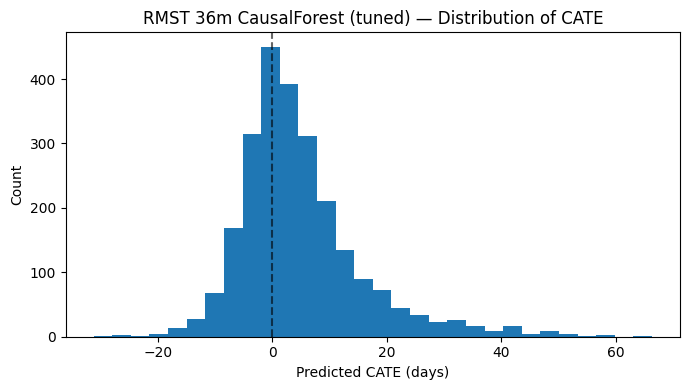

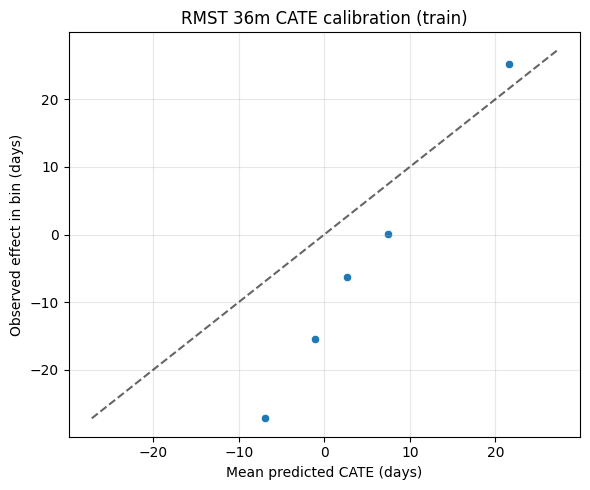

                             bin  mean_pred_cate  observed_effect
0  (-31.237000000000002, -2.991]       -6.904775       -27.181240
1                (-2.991, 0.633]       -1.078846       -15.473493
2                 (0.633, 4.833]        2.648552        -6.210655
3                (4.833, 10.999]        7.486810         0.073320
4               (10.999, 66.311]       21.591930        25.232469

=== Policy evaluation ===
Mean CATE (days): 4.75
Proportion with positive CATE: 63.84%
Policy value - treat none: 0.00 days
Policy value - treat all: 4.75 days
Policy value - treat if CATE > 0: 6.36 days


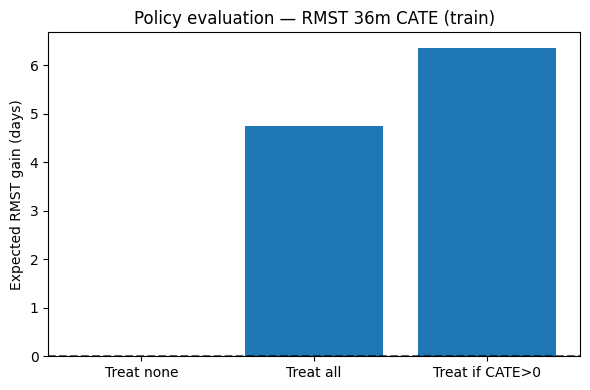

In [145]:
OUTDIR = globals().get("OUTDIR", "outputs2")

def tune_causal_forest_rmst(
    X,
    Y,
    W,
    sample_weight=None,
    param_grid=None,
    test_size=0.3,
    random_state=42
):
    """
    Hyperparameter search for RMST CausalForestDML using a hold-out validation set.
    """

    if param_grid is None:
        param_grid = {
            "n_estimators": [500, 1000],
            "min_samples_leaf": [5, 10, 20],
            "max_depth": [10, None],
        }

    if sample_weight is None:
        sample_weight = np.ones(len(Y))

    # create list of param combinations
    keys = list(param_grid.keys())
    param_list = [dict(zip(keys, vals)) for vals in itertools.product(*param_grid.values())]

    # split into train/validation for tuning
    X_tr, X_val, Y_tr, Y_val, W_tr, W_val, sw_tr, sw_val = train_test_split(
        X, Y, W, sample_weight,
        test_size=test_size,
        random_state=random_state
    )

    results = []
    best_model = None
    best_params = None
    best_policy_gain = -np.inf

    for i, params in enumerate(param_list):
        print(f"\n---- Fit {i+1}/{len(param_list)}: {params} ----")

        cf = CausalForestDML(
            model_y=RandomForestRegressor(
                n_estimators=200,
                min_samples_leaf=10,
                random_state=random_state
            ),
            model_t=RandomForestRegressor(
                n_estimators=200,
                min_samples_leaf=10,
                random_state=random_state
            ),
            discrete_treatment=True,
            random_state=random_state,
            **params
        )

        cf.fit(Y_tr, W_tr, X=X_tr, sample_weight=sw_tr)

        # CATE on validation set
        cate_val = np.asarray(cf.effect(X_val)).flatten()

        # Simple policy: treat if CATE > 0
        treat_policy = cate_val > 0

        # Policy gain proxy: expected RMST gain if we treat those predicted to benefit
        policy_gain = np.average(cate_val * treat_policy, weights=sw_val)

        # Variance of CATEs
        cate_var = float(np.var(cate_val))

        # Correct call: Y, T, X=...
        try:
            r_score = float(cf.score(Y_val, W_val, X=X_val, sample_weight=sw_val))
        except TypeError:
            r_score = np.nan

        results.append({
            **params,
            "policy_gain": policy_gain,
            "cate_var": cate_var,
            "r_score": r_score
        })

        if policy_gain > best_policy_gain:
            best_policy_gain = policy_gain
            best_model = cf
            best_params = params.copy()

    results_df = pd.DataFrame(results).sort_values("policy_gain", ascending=False)
    print("\n=== Hyperparameter search results (sorted by policy_gain) ===")
    print(results_df)

    return best_model, best_params, results_df


def refit_best_cf_on_full_data(best_params, X, Y, W, sample_weight=None, random_state=42):
    """
    Refit a CausalForestDML with the chosen best hyperparameters on ALL training data.
    """
    if sample_weight is None:
        sample_weight = np.ones(len(Y))

    cf_full = CausalForestDML(
        model_y=RandomForestRegressor(
            n_estimators=200,
            min_samples_leaf=10,
            random_state=random_state
        ),
        model_t=RandomForestRegressor(
            n_estimators=200,
            min_samples_leaf=10,
            random_state=random_state
        ),
        discrete_treatment=True,
        random_state=random_state,
        **best_params
    )

    cf_full.fit(Y, W, X=X, sample_weight=sample_weight)
    return cf_full


def plot_cate_calibration(cf, X, Y, W, sample_weight=None, n_bins=5, title="CATE calibration (RMST days)"):

    if sample_weight is None:
        sample_weight = np.ones(len(Y))

    cate = np.asarray(cf.effect(X)).flatten()
    df = pd.DataFrame({
        "cate_hat": cate,
        "Y": Y,
        "W": W,
        "w": sample_weight
    })

    # bin by predicted CATE into quantiles
    df["bin"] = pd.qcut(df["cate_hat"], q=n_bins, duplicates='drop')

    rows = []
    for b, g in df.groupby("bin"):
        if g["W"].nunique() < 2:
            continue

        mean_cate = np.average(g["cate_hat"], weights=g["w"])

        # observed effect in this bin: weighted difference in Y between treated vs control
        mask_t = g["W"] == 1
        mask_c = g["W"] == 0
        if mask_t.sum() == 0 or mask_c.sum() == 0:
            continue

        obs_t = np.average(g.loc[mask_t, "Y"], weights=g.loc[mask_t, "w"])
        obs_c = np.average(g.loc[mask_c, "Y"], weights=g.loc[mask_c, "w"])
        obs_eff = obs_t - obs_c

        rows.append({
            "bin": str(b),
            "mean_pred_cate": mean_cate,
            "observed_effect": obs_eff
        })

    cal_df = pd.DataFrame(rows)
    if cal_df.empty:
        print("Calibration: not enough variation in W within bins.")
        return cal_df

    plt.figure(figsize=(6,5))
    sns.scatterplot(data=cal_df, x="mean_pred_cate", y="observed_effect")
    max_val = np.max(np.abs(cal_df[["mean_pred_cate", "observed_effect"]].values))
    plt.plot([-max_val, max_val], [-max_val, max_val], 'k--', alpha=0.6)
    plt.xlabel("Mean predicted CATE (days)")
    plt.ylabel("Observed effect in bin (days)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(cal_df)
    return cal_df


def policy_evaluation_dashboard(cf, X, Y, W, sample_weight=None, title="Policy evaluation (RMST CATE)"):
    """
    Evaluate simple treatment policies based on CATE:
      - Treat none
      - Treat all
      - Treat if CATE > 0

    Uses CATE as pseudo RMST gain (in days).
    """
    if sample_weight is None:
        sample_weight = np.ones(len(Y))

    cate = np.asarray(cf.effect(X)).flatten()

    # policy 0: treat none
    value_none = 0.0

    # policy 1: treat all
    value_all = np.average(cate, weights=sample_weight)

    # policy 2: treat if CATE > 0
    policy_indicator = cate > 0
    value_policy = np.average(cate * policy_indicator, weights=sample_weight)

    print("\n=== Policy evaluation ===")
    print(f"Mean CATE (days): {np.average(cate, weights=sample_weight):.2f}")
    print(f"Proportion with positive CATE: {np.mean(cate > 0):.2%}")
    print(f"Policy value - treat none: {value_none:.2f} days")
    print(f"Policy value - treat all: {value_all:.2f} days")
    print(f"Policy value - treat if CATE > 0: {value_policy:.2f} days")

    labels = ["Treat none", "Treat all", "Treat if CATE>0"]
    values = [value_none, value_all, value_policy]

    plt.figure(figsize=(6,4))
    plt.bar(labels, values)
    plt.ylabel("Expected RMST gain (days)")
    plt.title(title)
    plt.axhline(0, color='k', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return {
        "value_none": value_none,
        "value_all": value_all,
        "value_policy": value_policy,
        "mean_cate": np.average(cate, weights=sample_weight)
    }


def causal_forest_performance_report(cf, X, Y, W, sample_weight=None, name="CausalForest RMST 36m"):
    if sample_weight is None:
        sample_weight = np.ones(len(Y))

    cate = np.asarray(cf.effect(X)).flatten()
    mean_cate = np.average(cate, weights=sample_weight)
    var_cate = np.average((cate - mean_cate)**2, weights=sample_weight)

    print(f"\n===== {name} Performance Report =====")
    print(f"N samples: {len(Y)}")
    print(f"Mean CATE (days): {mean_cate:.2f}")
    print(f"Std CATE (days): {np.sqrt(var_cate):.2f}")
    print(f"Min CATE: {np.min(cate):.2f}  Max CATE: {np.max(cate):.2f}")
    print(f"Proportion CATE > 0: {np.mean(cate > 0):.2%}")


    try:
        r_score = cf.score(Y, W, X=X, sample_weight=sample_weight)
        print(f"Global R-score (higher better): {r_score:.4f}")
    except TypeError:
        print("Global R-score not available for this model / econml version.")

    plt.figure(figsize=(7,4))
    plt.hist(cate, bins=30)
    plt.xlabel("Predicted CATE (days)")
    plt.ylabel("Count")
    plt.title(f"{name} — Distribution of CATE")
    plt.axvline(0, color='k', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Tune on training data
best_cf_partial, best_params, cf_search_results = tune_causal_forest_rmst(
    X=Xtr.values,
    Y=Ytr,
    W=Wtr,
    sample_weight=sw_tr,
    random_state=42
)

# Refit best on full training data
best_cf_rmst = refit_best_cf_on_full_data(
    best_params,
    X=Xtr.values,
    Y=Ytr,
    W=Wtr,
    sample_weight=sw_tr,
    random_state=42
)

# Save tuned model + results
cf_search_results.to_csv(os.path.join(OUTDIR, "cf_rmst_36m_tuning_results.csv"), index=False)
joblib.dump(best_cf_rmst, os.path.join(OUTDIR, "cf_rmst_36m_tuned.joblib"))
print("Saved tuned causal forest model to", os.path.join(OUTDIR, "cf_rmst_36m_tuned.joblib"))

#Evaluate on training set
causal_forest_performance_report(
    best_cf_rmst,
    Xtr.values,
    Ytr,
    Wtr,
    sample_weight=sw_tr,
    name="RMST 36m CausalForest (tuned)"
)

cal_df = plot_cate_calibration(
    best_cf_rmst,
    Xtr.values,
    Ytr,
    Wtr,
    sample_weight=sw_tr,
    n_bins=5,
    title="RMST 36m CATE calibration (train)"
)

policy_stats = policy_evaluation_dashboard(
    best_cf_rmst,
    Xtr.values,
    Ytr,
    Wtr,
    sample_weight=sw_tr,
    title="Policy evaluation — RMST 36m CATE (train)"
)


feature         group     n  mean_CATE_days  \
21               ecog_ps           2.0   140       15.940284   
22               ecog_ps           3.0    30       15.772514   
20               ecog_ps           1.0   741        8.445545   
19               ecog_ps           0.0  1538        1.125823   
6              hpv_clean  HPV_Negative   240        8.341761   
7              hpv_clean  HPV_Positive   743        4.439436   
8              hpv_clean   HPV_Unknown   104        2.729023   
15    primary_site_group    Oropharynx  1087        5.105416   
16    primary_site_group     Other_HNC   445        4.006685   
13    primary_site_group        Larynx   658        3.969322   
14    primary_site_group   Nasopharynx   263        1.844765   
17                   sex        Female   509        5.396298   
18                   sex          Male  1944        4.106039   
10  smoking_status_clean     Ex-Smoker   947        5.637379   
9   smoking_status_clean       Current   828        4.702017   
11  smoking_status_clean    Non-Smoker   642        2.299564   
12  smoking_status_clean       Unknown    36        2.014845   
5                  stage           IVB   219        6.846737   
2                  stage            II   313        4.803833   
3                  stage           III   433        4.535706   
4                  stage           IVA  1156        4.172664   
1                  stage             I   259        2.609378   
0                  stage             0    35       -0.414793   

    mean_CATE_months   std_CATE  
21          0.531343   9.228876  
22          0.525750   8.562564  
20          0.281518  11.639996  
19          0.037527   7.368594  
6           0.278059  11.028025  
7           0.147981   9.124183  
8           0.090967   7.537216  
15          0.170181   9.589150  
16          0.133556   9.539516  
13          0.132311  12.366803  
14          0.061492   6.713409  
17          0.179877   9.426180  
18          0.136868  10.233758  
10          0.187913  11.627458  
9           0.156734   9.494379  
11          0.076652   7.957439  
12          0.067162  10.239024  
5           0.228225  12.190258  
2           0.160128  11.633171  
3           0.151190  10.564080  
4           0.139089   8.545256  
1           0.086979  12.335349  
0          -0.013826  12.891998

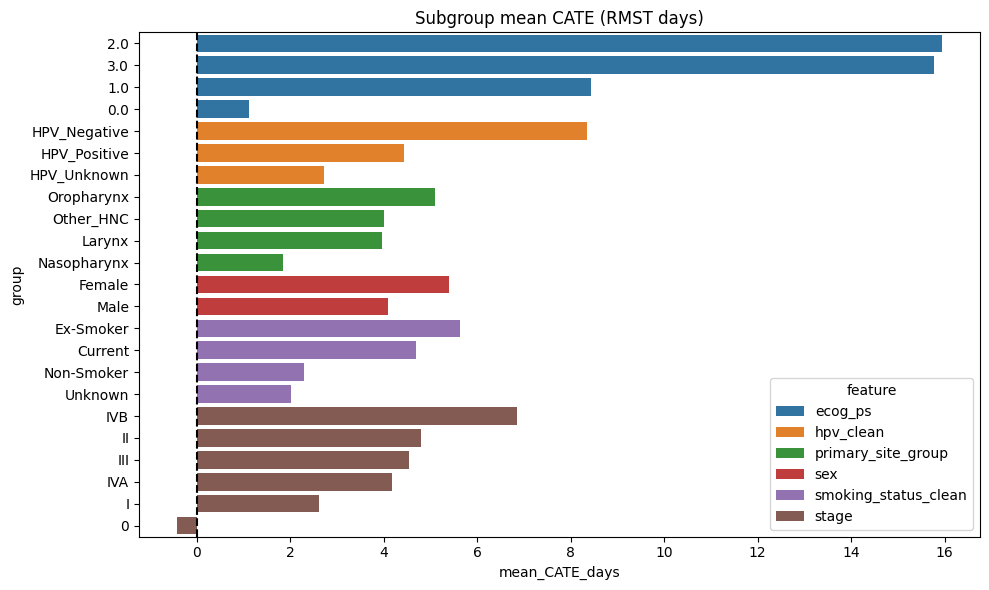

In [148]:
def subgroup_cate_summary(
    cf,
    df_pat,
    feature_cols,
    cate_col_name="CATE_rmst_36m_days",
    sample_weight_col=None,
    min_group_size=20
):
    """
    Computes subgroup-level average CATEs for categorical clinical features.

    cf                = fitted causal forest
    df_pat            = patient-level dataframe containing features and treatment/covariates
    feature_cols      = list of categorical columns/subgroups to summarize (e.g. ['stage','hpv_clean'])
    cate_col_name     = optional: if CATEs already computed. If not, computes using cf.effect.
    sample_weight_col = optional weight column
    """

    df = df_pat.copy()

    # compute CATE if not already present
    if cate_col_name not in df.columns:
        print("Computing CATEs for subgroup analysis...")
        df[cate_col_name] = cf.effect(df[cf.feature_names_in_]).flatten()

    # compute weights
    if sample_weight_col and sample_weight_col in df.columns:
        w = df[sample_weight_col].fillna(1.0).values
    else:
        w = np.ones(len(df))

    rows = []

    # loop through each feature
    for col in feature_cols:
        if col not in df.columns:
            print(f"Column '{col}' missing — skipping.")
            continue

        for level, g in df.groupby(col):
            if len(g) < min_group_size:
                continue

            # weighted mean CATE
            cate_vals = g[cate_col_name].values
            weights = np.ones(len(g)) if sample_weight_col is None else g[sample_weight_col].values

            mean_cate = np.average(cate_vals, weights=weights)
            sd_cate = np.sqrt(np.average((cate_vals - mean_cate)**2, weights=weights))

            rows.append({
                "feature": col,
                "group": level,
                "n": len(g),
                "mean_CATE_days": mean_cate,
                "mean_CATE_months": mean_cate / 30.0,
                "std_CATE": sd_cate
            })

    return pd.DataFrame(rows).sort_values(["feature","mean_CATE_days"], ascending=[True, False])
subgroup_features = [
    "stage",
    "hpv_clean",
    "smoking_status_clean",
    "primary_site_group",
    "sex",
    "ecog_ps"
]

subgroup_df = subgroup_cate_summary(
    cf=best_cf_rmst,
    df_pat=train_pat,        # or test_pat
    feature_cols=subgroup_features,
    sample_weight_col="sw_logit_spline_tuned",  # or your preferred weight
    min_group_size=20
)

display(subgroup_df)
plt.figure(figsize=(10,6))
sns.barplot(
    data=subgroup_df,
    x="mean_CATE_days",
    y="group",
    hue="feature",
    dodge=False
)
plt.axvline(0, color='k', linestyle='--')
plt.title("Subgroup mean CATE (RMST days)")
plt.tight_layout()
plt.show()


Chemo-RT gives the biggest absolute survival benefit in:

  ECOG 2–3

  HPV-negative

  Heavy or ex-smokers

  Stage III–IVB

Chemo-RT gives the smallest benefit in:

  ECOG 0

 HPV-positive

 Never-smokers

  Stage I or 0

 Nasopharynx

# Time-varying effects visualization
period hazards
 HR
cumulative ΔRMST
 smoothed HR)

Running cluster bootstrap to get HR CIs (may take a while)...


bootstrap:   0%|          | 0/300 [00:00<?, ?it/s]

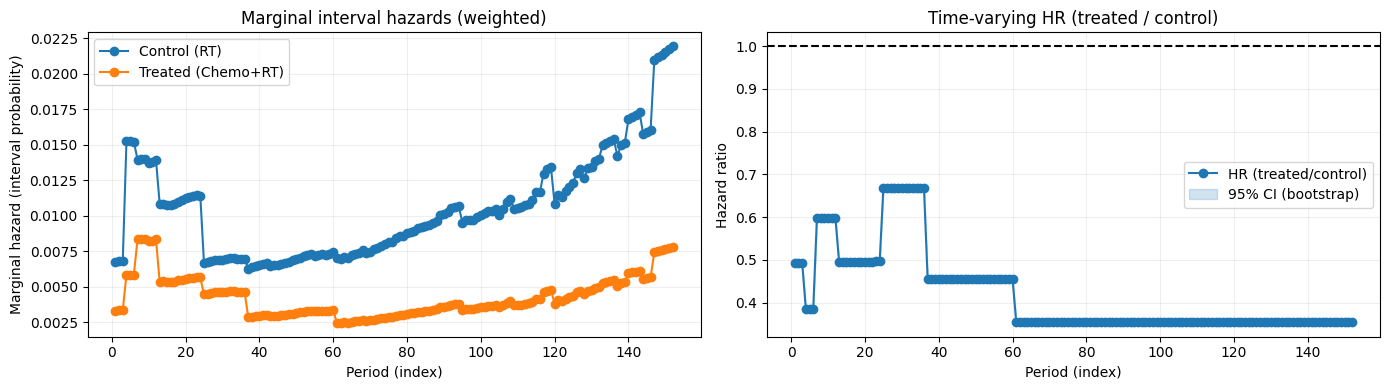

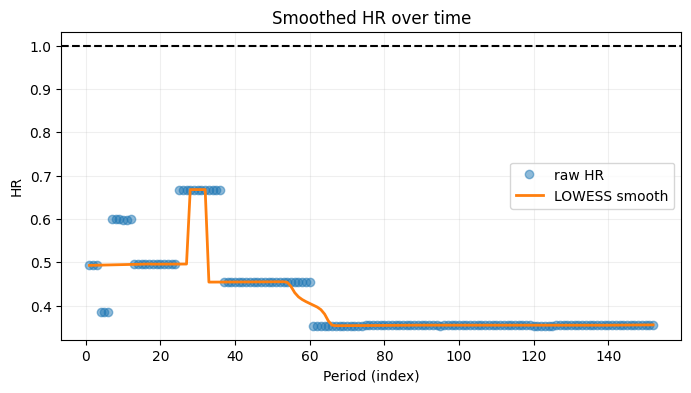

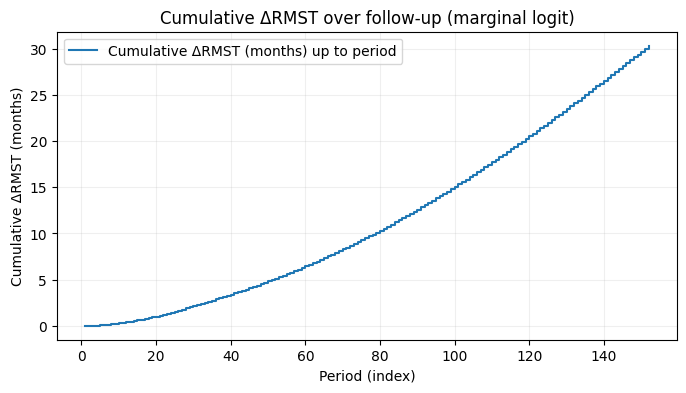

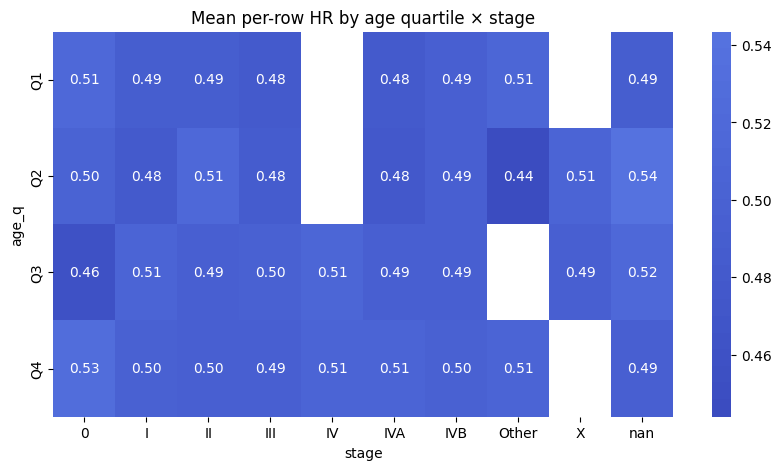

Saved timevarying_summary_by_period.csv and plots to outputs2


In [149]:
# Time-varying effects visualization (period hazards, HR, cumulative ΔRMST, smoothed HR)

# Horizon in days from global config
TAU_DAYS = TAU_MONTHS * INTERVAL_DAYS

# Required objects
if 'pp_test' not in globals():
    raise RuntimeError("pp_test not found in workspace. You need pp_test person-period table.")

if 'logit' not in globals():
    # try to load *tuned* pooled-logit from OUTDIR
    tuned_path = os.path.join(OUTDIR, "pooled_logit_logreg_saga_l2_tuned.joblib")
    if os.path.exists(tuned_path):
        logit = joblib.load(tuned_path)
        print("Loaded tuned pooled-logit from", tuned_path)
    else:
        fallback_path = os.path.join(OUTDIR, "pooled_logit_logreg_saga.joblib")
        if os.path.exists(fallback_path):
            logit = joblib.load(fallback_path)
            print("Loaded (untuned) pooled-logit from", fallback_path)
        else:
            raise RuntimeError("pooled-logit model not found in workspace or OUTDIR.")

if 'build_X_for_pp' not in globals():
    raise RuntimeError("build_X_for_pp function not found. Define or load it.")

pp = pp_test.copy().reset_index(drop=True)

# Build X for pp_test aligned to pooled-logit and predict hazards under treated/control
X_pp = build_X_for_pp(pp)

# If pooled-logit expects model_columns, reindex X_pp
if 'model_columns' in globals() and model_columns is not None:
    X_pp = X_pp.reindex(columns=model_columns, fill_value=0.0)

# create two counterfactual feature tables
X_t = X_pp.copy(); X_t[TREAT_COL] = 1
X_c = X_pp.copy(); X_c[TREAT_COL] = 0

# recompute interactions for period dummies
period_cols = [c for c in X_pp.columns if str(c).startswith('period_bin')]
for pcol in period_cols:
    X_t[f'treat_x_{pcol}'] = X_t[TREAT_COL] * X_t.get(pcol, 0)
    X_c[f'treat_x_{pcol}'] = X_c[TREAT_COL] * X_c.get(pcol, 0)

# make sure columns align to pooled-logit
if 'model_columns' in globals() and model_columns is not None:
    X_t = X_t.reindex(columns=model_columns, fill_value=0.0)
    X_c = X_c.reindex(columns=model_columns, fill_value=0.0)

pp['p_treated'] = logit.predict_proba(X_t)[:, 1]
pp['p_control'] = logit.predict_proba(X_c)[:, 1]

# prefer a weight column if present
if 'sw' in pp.columns:
    pp['w_for_agg'] = pp['sw'].fillna(1.0).astype(float)
elif 'sw_trunc' in pp.columns:
    pp['w_for_agg'] = pp['sw_trunc'].fillna(1.0).astype(float)
else:
    pp['w_for_agg'] = 1.0

# Aggregate marginal hazards by period (weighted)
periods = sorted(pp['period'].unique())
haz_treated = []
haz_control = []
period_len = []   # mean length or INTERVAL_DAYS

for p in periods:
    g = pp[pp['period'] == p]
    if g.shape[0] == 0:
        haz_treated.append(np.nan)
        haz_control.append(np.nan)
        period_len.append(INTERVAL_DAYS)
        continue
    wt = g['w_for_agg'].values
    haz_treated.append(np.average(g['p_treated'].values, weights=wt))
    haz_control.append(np.average(g['p_control'].values, weights=wt))
    if 'period_length' in g.columns:
        period_len.append(int(g['period_length'].dropna().median()))
    else:
        period_len.append(INTERVAL_DAYS)

haz_treated = np.array(haz_treated)
haz_control = np.array(haz_control)
period_len = np.array(period_len)

# compute period-level HR
with np.errstate(divide='ignore', invalid='ignore'):
    hr_period = np.divide(haz_treated, haz_control)
    hr_period[~np.isfinite(hr_period)] = np.nan

# Cluster bootstrap for HR CIs (by patient)
def bootstrap_hr(pp_df, build_fn, model, model_cols=None, n_boot=200, seed=42):
    rng = np.random.RandomState(seed)
    pids = pp_df[ID_COL].unique()
    n_p = len(pids)
    boot_hrs = []
    for b in tqdm(range(n_boot), desc="bootstrap"):
        sampled = rng.choice(pids, size=n_p, replace=True)
        boot_pp = pd.concat(
            [pp_df[pp_df[ID_COL] == pid] for pid in sampled],
            ignore_index=True
        )
        Xb = build_fn(boot_pp)
        if model_cols is not None:
            Xb = Xb.reindex(columns=model_cols, fill_value=0.0)
        Xt = Xb.copy(); Xt[TREAT_COL] = 1
        Xc = Xb.copy(); Xc[TREAT_COL] = 0
        for pcol in [c for c in Xb.columns if c.startswith('period_bin')]:
            Xt[f'treat_x_{pcol}'] = Xt[TREAT_COL] * Xt.get(pcol, 0)
            Xc[f'treat_x_{pcol}'] = Xc[TREAT_COL] * Xc.get(pcol, 0)
        if model_cols is not None:
            Xt = Xt.reindex(columns=model_cols, fill_value=0.0)
            Xc = Xc.reindex(columns=model_cols, fill_value=0.0)
        pt = model.predict_proba(Xt)[:, 1]
        pc = model.predict_proba(Xc)[:, 1]
        boot_pp['pt'] = pt
        boot_pp['pc'] = pc
        # weighted average per period
        w_series = boot_pp.get('sw', boot_pp.get('sw_trunc', pd.Series(1.0, index=boot_pp.index)))
        pm_t = boot_pp.groupby('period').apply(
            lambda g: np.average(g['pt'], weights=g.get('sw', g.get('sw_trunc', pd.Series(1.0, index=g.index))).fillna(1.0))
        )
        pm_c = boot_pp.groupby('period').apply(
            lambda g: np.average(g['pc'], weights=g.get('sw', g.get('sw_trunc', pd.Series(1.0, index=g.index))).fillna(1.0))
        )
        ph_t = np.array([pm_t.get(p, 0.0) for p in periods])
        ph_c = np.array([pm_c.get(p, 0.0) for p in periods])
        with np.errstate(divide='ignore', invalid='ignore'):
            hr = ph_t / ph_c
            hr[~np.isfinite(hr)] = np.nan
        boot_hrs.append(hr)
    return np.vstack(boot_hrs)   # shape (n_boot, n_periods)

# toggle boots
RUN_BOOT = True
N_BOOT = 300
hr_lo = hr_up = None
if RUN_BOOT:
    print("Running cluster bootstrap to get HR CIs (may take a while)...")
    boot_hr = bootstrap_hr(
        pp,
        build_X_for_pp,
        logit,
        model_cols=(model_columns if 'model_columns' in globals() else None),
        n_boot=N_BOOT,
        seed=42
    )
    hr_lo = np.nanpercentile(boot_hr, 2.5, axis=0)
    hr_up = np.nanpercentile(boot_hr, 97.5, axis=0)
else:
    hr_lo = np.full_like(hr_period, np.nan)
    hr_up = np.full_like(hr_period, np.nan)

# 4) Plot hazard curves and HR with CI
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = axes[0]
ax.plot(periods, haz_control, marker='o', label='Control (RT)')
ax.plot(periods, haz_treated, marker='o', label='Treated (Chemo+RT)')
ax.set_xlabel('Period (index)')
ax.set_ylabel('Marginal hazard (interval probability)')
ax.set_title('Marginal interval hazards (weighted)')
ax.legend()
ax.grid(alpha=0.2)

ax2 = axes[1]
ax2.plot(periods, hr_period, marker='o', label='HR (treated/control)')
if RUN_BOOT:
    ax2.fill_between(periods, hr_lo, hr_up, color='C0', alpha=0.2, label='95% CI (bootstrap)')
ax2.axhline(1.0, color='k', linestyle='--')
ax2.set_xlabel('Period (index)')
ax2.set_ylabel('Hazard ratio')
ax2.set_title('Time-varying HR (treated / control)')
ax2.legend()
ax2.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "timevarying_hazards_hr.png"), dpi=150)
plt.show()

# Lowess-smoothed HR (helps identify peaks/troughs)
valid_idx = ~np.isnan(hr_period)
if valid_idx.sum() > 3:
    lo = lowess(hr_period[valid_idx], np.array(periods)[valid_idx], frac=0.2, return_sorted=False)
    plt.figure(figsize=(8, 4))
    plt.plot(periods, hr_period, 'o', alpha=0.5, label='raw HR')
    plt.plot(np.array(periods)[valid_idx], lo, '-', linewidth=2, label='LOWESS smooth')
    plt.axhline(1.0, color='k', linestyle='--')
    plt.xlabel('Period (index)')
    plt.ylabel('HR')
    plt.title('Smoothed HR over time')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.savefig(os.path.join(OUTDIR, "smoothed_hr.png"), dpi=150)
    plt.show()

# Cumulative ΔRMST over time (marginalized)
S_t = np.cumprod(1.0 - haz_treated)
S_c = np.cumprod(1.0 - haz_control)
S_prev_t = np.concatenate(([1.0], S_t[:-1]))
S_prev_c = np.concatenate(([1.0], S_c[:-1]))
delta_rmst_by_period = (S_prev_t - S_prev_c) * period_len  # days gained per period
cumul_delta = np.cumsum(delta_rmst_by_period)  # days

plt.figure(figsize=(8, 4))
plt.step(periods, cumul_delta / INTERVAL_DAYS, where='post', label='Cumulative ΔRMST (months) up to period')
plt.xlabel('Period (index)')
plt.ylabel('Cumulative ΔRMST (months)')
plt.title('Cumulative ΔRMST over follow-up (marginal logit)')
plt.grid(alpha=0.2)
plt.legend()
plt.savefig(os.path.join(OUTDIR, "cumulative_delta_rmst.png"), dpi=150)
plt.show()

# Heatmap ---> HR by age quartile × stage
if 'age' in pp.columns and 'stage' in pp.columns:
    pp['age_q'] = pd.qcut(pp['age'].fillna(pp['age'].median()), q=4, labels=['Q1','Q2','Q3','Q4'])
    pp['hr_row'] = pp['p_treated'] / pp['p_control']
    pp.loc[~np.isfinite(pp['hr_row']), 'hr_row'] = np.nan
    heat = pp.groupby(['age_q', 'stage'])['hr_row'].mean().unstack()
    plt.figure(figsize=(10, 5))
    sns.heatmap(heat, annot=True, fmt=".2f", center=1.0, cmap='coolwarm')
    plt.title('Mean per-row HR by age quartile × stage')
    plt.savefig(os.path.join(OUTDIR, "heatmap_hr_age_stage.png"), dpi=150)
    plt.show()
else:
    print("Skipping heatmap: 'age' or 'stage' not present in pp_test.")

# Save numeric summary
summary_df = pd.DataFrame({
    'period': periods,
    'haz_treated': haz_treated,
    'haz_control': haz_control,
    'period_length_days': period_len,
    'hr': hr_period,
    'hr_lo': hr_lo,
    'hr_up': hr_up,
    'S_treated': S_t,
    'S_control': S_c,
    'delta_rmst_period_days': delta_rmst_by_period
})
summary_path = os.path.join(OUTDIR, "timevarying_summary_by_period.csv")
summary_df.to_csv(summary_path, index=False)
print("Saved timevarying_summary_by_period.csv and plots to", OUTDIR)


**Infer new patient**

In [150]:
# model artifacts / global config hooks

def infer_new_patient_fixed(patient_data, return_raw=False):
    """
    nference for a single new patient.
    - patient_data: dict or 1-row DataFrame with baseline covariates (age, sex,...). Include treatment if known.
    - Loads artifacts from OUTDIR if they are not in globals().
    - Returns dict: {'survival_curve': pd.DataFrame, 'CATEs': {months: {'CATE': val, 'error': msg}}}
    """
    #input df
    if isinstance(patient_data, dict):
        df = pd.DataFrame([patient_data])
    else:
        df = patient_data.copy().reset_index(drop=True)

    # patient_id and treatment
    if ID_COL not in df.columns:
        df[ID_COL] = 'new'
    if TREAT_COL not in df.columns:
        df[TREAT_COL] = int(df.get(TREAT_COL, 0))

    # helper loader that checks globals() then OUTDIR files
    def _load_art(name, filenames):
        # try globals first
        if name in globals() and globals()[name] is not None:
            return globals()[name], f"from globals('{name}')"
        # try candidate paths in OUTDIR
        for fn in filenames:
            p = os.path.join(OUTDIR, fn)
            if os.path.exists(p):
                try:
                    val = joblib.load(p)
                    return val, f"from {p}"
                except Exception:
                    try:
                        # maybe csv
                        val = pd.read_csv(p)
                        return val, f"from {p}"
                    except Exception:
                        pass
        return None, None

    # patient_columns (canonical one-hot + numeric column list)
    patient_columns, pc_src = _load_art(
        'patient_columns',
        ['causal_patient_columns.joblib',
         'causal_patient_columns.pkl',
         'causal_patient_columns.npy',
         'causal_patient_columns.csv']
    )
    # patient scaler (for numeric scaling)
    patient_scaler, sc_src = _load_art(
        'patient_scaler',
        ['causal_patient_scaler.joblib',
         'causal_patient_scaler.pkl',
         'causal_patient_scaler.npy']
    )
    # pp_train_medians (train medians for person-period numeric)
    pp_train_medians, pm_src = _load_art(
        'pp_train_medians',
        ['pp_train_medians.joblib',
         'pp_train_medians.pkl',
         'pp_train_medians.csv']
    )
    # pooled-logit model (prefer tuned) + model_columns
    pooled_logit, lp_src = _load_art(
        'logit',
        ['pooled_logit_logreg_saga_l2_tuned.joblib',
         'pooled_logit_logreg_saga.joblib',
         'pooled_logit.joblib',
         'pooled_logit_logreg_saga.pkl']
    )
    model_columns, mc_src = _load_art(
        'model_columns',
        ['pooled_logit_model_columns.csv',
         'pooled_logit_model_columns.joblib',
         'pooled_logit_model_columns.pkl']
    )
    # forests bundle
    forests_bundle, fb_src = _load_art(
        'FORESTS_BUNDLE',
        ['causal_forests_period_horizons_patient_level.joblib',
         'forests_bundle.joblib',
         'causal_forests_period_horizons.joblib']
    )

    if forests_bundle is None:
        for candidate in ['forests', 'forests_bundle', 'FORESTS_BUNDLE', 'causal_forests']:
            if candidate in globals():
                forests_bundle = globals()[candidate]
                fb_src = f"from globals('{candidate}')"
                break

    # Prepare outputs
    cate_results = {}
    survival_df = None
    errors = {}

    # build patient-level person-period rows to feed pooled-logit
    # Determine max_period from pp_test if available
    max_period = None
    if 'pp_test' in globals():
        try:
            max_period = int(globals()['pp_test']['period'].max())
        except Exception:
            max_period = None
    if max_period is None:
        max_period = 12  # conservative fallback

    # create pp rows
    rows = []
    for p in range(1, max_period + 1):
        row = df.iloc[0].to_dict()
        row['period'] = p
        row[ID_COL] = df.iloc[0].get(ID_COL, 'new')
        row[TREAT_COL] = int(row.get(TREAT_COL, 0))
        rows.append(row)
    df_pp_new = pd.DataFrame(rows)

    # predict hazards & survival using pooled-logit if available
    if pooled_logit is None or model_columns is None:
        errors['pooled_logit'] = "pooled-logit model or model_columns missing; cannot compute survival."
    else:
        try:
            # use build_X_for_pp if available
            if 'build_X_for_pp' in globals():
                X_pp = build_X_for_pp(df_pp_new.copy())
            else:
                # minimal manual mapping
                X_pp = pd.DataFrame(index=df_pp_new.index)
                if pp_train_medians is not None:
                    for c in pp_train_medians.keys():
                        if c in df_pp_new.columns:
                            X_pp[c] = pd.to_numeric(df_pp_new[c], errors='coerce').fillna(pp_train_medians[c])
                        else:
                            X_pp[c] = pp_train_medians[c]
                if patient_columns is not None:
                    for c in patient_columns:
                        if c not in X_pp.columns:
                            X_pp[c] = 0.0
                X_pp[TREAT_COL] = pd.to_numeric(df_pp_new[TREAT_COL], errors='coerce').fillna(0).astype(int).values

            # align to pooled-logit model_columns
            if isinstance(model_columns, pd.DataFrame):
                cols_req = model_columns.iloc[:, 0].astype(str).tolist()
            elif isinstance(model_columns, (pd.Series, np.ndarray, list)):
                cols_req = list(model_columns)
            else:
                cols_req = model_columns
            X_pp = X_pp.reindex(columns=cols_req, fill_value=0.0)

            # create counterfactuals
            X_t = X_pp.copy(); X_t[TREAT_COL] = 1
            X_c = X_pp.copy(); X_c[TREAT_COL] = 0
            for pcol in [c for c in X_t.columns if str(c).startswith('period_bin')]:
                X_t[f'treat_x_{pcol}'] = X_t[TREAT_COL] * X_t.get(pcol, 0)
                X_c[f'treat_x_{pcol}'] = X_c[TREAT_COL] * X_c.get(pcol, 0)

            probs_t = pooled_logit.predict_proba(X_t)[:, 1]
            probs_c = pooled_logit.predict_proba(X_c)[:, 1]
            S_t = np.cumprod(1 - probs_t)
            S_c = np.cumprod(1 - probs_c)
            survival_df = pd.DataFrame({
                'period': np.arange(1, len(S_t) + 1),
                'S_control': S_c,
                'S_treat': S_t
            })
            survival_df['days'] = survival_df['period'] * INTERVAL_DAYS
        except Exception as e:
            errors['pooled_logit'] = f"pipelined survival predict failed: {e}"

    # build patient-level X for CF prediction (patient_columns canonical)
    Xpatient = None
    if patient_columns is None:
        errors['patient_columns'] = "patient_columns artifact missing. CF prediction will be impossible without canonical patient feature names."
    else:
        try:
            if isinstance(patient_columns, (pd.Series, np.ndarray)):
                pcols = list(patient_columns)
            elif isinstance(patient_columns, dict):
                if 'columns' in patient_columns:
                    pcols = list(patient_columns['columns'])
                else:
                    pcols = list(patient_columns.keys())
            else:
                pcols = list(patient_columns)

            Xpatient = pd.DataFrame(np.zeros((1, len(pcols))), columns=pcols)

            for c in pcols:
                if c in df.columns:
                    Xpatient.at[0, c] = df.at[0, c]
                else:
                    if '_' in c:
                        root, tail = c.split('_', 1)
                        if root in df.columns and str(df.at[0, root]) == tail:
                            Xpatient.at[0, c] = 1.0

            # numeric scaling if scaler
            if patient_scaler is not None:
                try:
                    Xnum = Xpatient.select_dtypes(include=[np.number])
                    if Xnum.shape[1] > 0:
                        Xnum_scaled = pd.DataFrame(
                            patient_scaler.transform(Xnum),
                            columns=Xnum.columns,
                            index=Xpatient.index
                        )
                        Xpatient[Xnum.columns] = Xnum_scaled
                except Exception:
                    errors['scaler'] = "scaler exists but failed to transform Xpatient; proceeding without scaling"

            Xpatient = Xpatient.reindex(columns=pcols, fill_value=0.0)
        except Exception as e:
            errors['Xpatient'] = f"Failed to construct Xpatient: {e}"
            Xpatient = None

    # Predict CATEs using forests in bundle
    if forests_bundle is None:
        errors['forests_bundle'] = "forests bundle not found in outputs or globals."
        for lab in PERIOD_LABELS:
            # convert label to months
            if HORIZON_MAP and lab in HORIZON_MAP:
                months = HORIZON_MAP[lab]
            else:
                try:
                    months = int(lab.split('-')[-1].replace('+', ''))
                except Exception:
                    months = lab
            cate_results[months] = {'CATE': np.nan, 'error': errors['forests_bundle']}
    else:
        for lab, est in forests_bundle.items():
            # resolve months int for the label
            if HORIZON_MAP and lab in HORIZON_MAP:
                months = HORIZON_MAP[lab]
            else:
                try:
                    if '+' in lab:
                        months = int(lab.replace('+', '').split('-')[-1])
                    else:
                        months = int(lab.split('-')[-1])
                except Exception:
                    months = lab

            if Xpatient is None:
                cate_results[months] = {'CATE': np.nan, 'error': 'Xpatient not built'}
                continue

            try:
                candidate_est = est
                if isinstance(est, dict):
                    for v in est.values():
                        if hasattr(v, 'effect'):
                            candidate_est = v
                            break

                if hasattr(candidate_est, "feature_names_in_"):
                    req = list(candidate_est.feature_names_in_)
                    Xfor = Xpatient.reindex(columns=req, fill_value=0.0)
                    Xfor_in = Xfor.values
                else:
                    Xfor_in = Xpatient.values

                eff = np.asarray(candidate_est.effect(Xfor_in)).flatten()
                val = float(eff[0]) if eff.size > 0 else np.nan
                cate_results[months] = {'CATE': val, 'error': None}
            except Exception as e:
                cate_results[months] = {'CATE': np.nan, 'error': str(e)}

    # order cate_results by months if numeric
    try:
        cate_results = dict(sorted(
            cate_results.items(),
            key=lambda kv: (
                float(kv[0])
                if isinstance(kv[0], (int, float, str)) and str(kv[0]).replace('.', '', 1).isdigit()
                else 1e9
            )
        ))
    except Exception:
        pass

    out = {'survival_curve': survival_df, 'CATEs': cate_results, 'errors': errors}
    if return_raw:
        out['artifacts_sources'] = dict(
            patient_columns=pc_src,
            patient_scaler=sc_src,
            pp_train_medians=pm_src,
            pooled_logit=lp_src,
            model_columns=mc_src,
            forests_bundle=fb_src
        )
    return out

# new patient test:
new_patient = {
    'age': 62,
    'sex': 'F',
    'primary_site_group': 'Oropharynx',
    'pathology_group': 'Squamous',
    'hpv_clean': 'HPV_Positive',
    TREAT_COL: 0
}
out = infer_new_patient_fixed(new_patient, return_raw=True)
print(out['CATEs'])


{3: {'CATE': -0.012602025883243016, 'error': None}, 6: {'CATE': -0.014019916099972815, 'error': None}, 12: {'CATE': 0.0776867936189627, 'error': None}, 24: {'CATE': 0.053926363223594405, 'error': None}, 36: {'CATE': -0.051922867405309985, 'error': None}, 60: {'CATE': -0.042571601845970225, 'error': None}, 156: {'CATE': 0.12338912658120456, 'error': None}}


In [151]:
#Dummy patients

sample_data = [
    ["P001",55,"M",1,0,"Nonsmoker",2,0,"Oropharynx","Tonsil","T2","N1","M0","III",0,0,0,0,"Positive",0,0,"SCC",0,0,70,68,70,1,820,1],
    ["P002",61,"F",0,0,"Former",15,0,"Larynx","Glottic","T3","N0","M0","III",0,0,0,0,"Negative",0,0,"SCC",0,0,66,64,66,0,620,0],
    ["P003",48,"M",1,0,"Current",32,0,"Oropharynx","BaseTongue","T2","N2","M0","IVA",0,0,0,0,"Positive",0,1,"SCC",0,0,74,72,74,1,900,1],
    ["P004",70,"M",2,0,"Nonsmoker",0,0,"OralCavity","Tongue","T4","N1","M0","IVB",0,0,0,0,"Negative",0,0,"SCC",1,0,60,58,60,0,400,1],
    ["P005",58,"F",1,0,"Former",20,0,"Hypopharynx","Pyriform","T3","N2","M0","IVA",0,0,0,0,"Positive",0,0,"SCC",0,1,68,66,68,1,670,0],
    ["P006",65,"M",0,0,"Current",45,0,"Oropharynx","SoftPalate","T1","N1","M0","II",0,0,0,0,"Positive",0,0,"SCC",0,0,70,68,70,0,760,0],
    ["P007",72,"F",2,0,"Nonsmoker",0,0,"Larynx","Supraglottic","T3","N2","M0","IVA",0,0,0,0,"Negative",0,0,"SCC",0,1,66,64,66,1,480,1],
    ["P008",52,"M",1,0,"Former",10,0,"Oropharynx","Tonsil","T1","N1","M0","II",0,0,0,0,"Positive",0,0,"SCC",0,0,70,68,70,0,900,0],
    ["P009",60,"M",0,0,"Nonsmoker",0,0,"OralCavity","FloorMouth","T2","N0","M0","III",0,0,0,0,"Negative",0,0,"SCC",1,0,60,58,60,1,550,1],
    ["P010",45,"F",1,0,"Current",25,0,"Oropharynx","BaseTongue","T2","N1","M0","III",0,0,0,0,"Positive",0,0,"SCC",0,0,72,70,72,1,880,0],
]

columns = [
    "patient_id","age","sex","ecog_ps","ecog_ps_missing",
    "smoking_status_clean","smoking_py_clean","smoking_py_missing",
    "primary_site_group","subsite_clean",
    "t","n","m","stage",
    "t_missing","n_missing","m_missing","stage_missing",
    "hpv_clean","hpv_missing","hpv_specific_tumors",
    "pathology_group","is_non_tnm","tnm_structural_missing",
    "BED_eff","EQD2","BED",
    "treatment","time_os_days","event_os"
]

df = pd.DataFrame(sample_data, columns=columns)
df.to_csv("sample_patient_data.csv", index=False)

df.head(2)


patient_id  age sex  ecog_ps  ecog_ps_missing smoking_status_clean  \
0       P001   55   M        1                0            Nonsmoker   
1       P002   61   F        0                0               Former   

   smoking_py_clean  smoking_py_missing primary_site_group subsite_clean   t  \
0                 2                   0         Oropharynx        Tonsil  T2   
1                15                   0             Larynx       Glottic  T3   

    n   m stage  t_missing  n_missing  m_missing  stage_missing hpv_clean  \
0  N1  M0   III          0          0          0              0  Positive   
1  N0  M0   III          0          0          0              0  Negative   

   hpv_missing  hpv_specific_tumors pathology_group  is_non_tnm  \
0            0                    0             SCC           0   
1            0                    0             SCC           0   

   tnm_structural_missing  BED_eff  EQD2  BED  treatment  time_os_days  \
0                       0       70    68   70          1           820   
1                       0       66    64   66          0           620   

   event_os  
0         1  
1         0

In [152]:
!find /content -type f -name "*.joblib"

/content/outputs2/rf_delta_rmst_36m.joblib
/content/outputs2/cf_rmst_36m_tuned.joblib
/content/outputs2/ps_logit_spline_tuned.joblib
/content/outputs2/pooled_logit_logreg_saga_l2_tuned.joblib
/content/outputs2/ps_super.joblib
/content/outputs2/pp_collapse_maps.joblib
/content/outputs2/shap_rf_delta_rmst_36m.joblib
/content/outputs2/causal_patient_scaler.joblib
/content/outputs2/km_censor_train.joblib
/content/outputs2/preprocessor.joblib
/content/outputs2/causal_patient_columns.joblib
/content/outputs2/ps_enet.joblib
/content/outputs2/cf_rmst_36m_patient_level.joblib
/content/outputs2/causal_forests_period_horizons_patient_level.joblib
/content/outputs2/pp_scaler.joblib
/content/outputs2/ps_logistic_model.joblib
/content/outputs2/ps_gbm_tuned.joblib
/content/outputs2/pp_train_medians.joblib
/content/outputs2/ps_preprocessor.joblib
